In [1]:
#%matplotlib notebook
%matplotlib inline

import ROOT
import uuid
import math
import sys
sys.path.insert(0, '..')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
#import clusterTools as clAlgo

#with open('tc_dump_ev_0.json') as data_file:    
#    data = json.load(data_file)

event = 1


tcs = pd.read_json('../tc_dump_ev_{}.json'.format(event))
cl2d = pd.read_json('../2dc_dump_ev_{}.json'.format(event))
mcl2d = pd.read_json('../m2dc_dump_ev_{}.json'.format(event))



Welcome to JupyROOT 6.10/08


In [2]:
# %load ../clusterTools.py
import pandas as pd
import numpy as np
import json
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import math


def buildDBSCANClustersUnpack(arg):
    return buildDBSCANClusters(sel_layer=arg[0], sel_zside=arg[1], tcs=arg[2])


def buildDBSCANClusters(sel_layer, sel_zside, tcs):
    tcs_layer = tcs[(tcs.layer == sel_layer) & (tcs.zside == sel_zside)]
    new2Dcls = pd.DataFrame()

    if len(tcs_layer['x']) == 0:
        return new2Dcls

    X = tcs_layer[['x', 'y']]
    # tuned on 25GeV e-
    #densities = [0.05, 0.05, 0.1, 0.25, 0.3, 0.3, 0.5, 0.45, 0.4, 0.35, 0.4, 0.25, 0.25, 0.15, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.15]

    densities = [0.1, 0.2, 0.5, 0.5, 1.1, 1.3, 1.7, 1.8, 2.0, 2.2, 2.6, 2.0, 1.8, 1.4, 1.2, 0.8, 0.6, 0.4, 0.2, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
    # photon Pt35 tunes (no selection on unconverted)
    # densities = [0.05, 0.05, 0.05, 0.1, 0.25, 0.45, 1.1, 1.6, 2.5, 3.55, 4.85, 4.6, 4.35, 3.55, 3.15, 2.25, 1.8, 1.05, 1.0, 0.65, 0.5, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.2]
    db = DBSCAN(eps=2.5,
                min_samples=densities[sel_layer-1]*100,
                algorithm='kd_tree',
                n_jobs=3).fit(X, sample_weight=tcs_layer['energy']*100)
    labels = db.labels_
    unique_labels = set(labels)
    tcs_layer['dbs_label'] = labels
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    tcs_layer['core'] = core_samples_mask
    # print db.core_sample_indices_
    # print tcs_layer

    for label in unique_labels:
        if label == -1:
            continue
        components = tcs_layer[tcs_layer.dbs_label == label]
        cl = pd.DataFrame()
        cl['energy'] = [components.energy.sum()]

        cl['energyCore'] = [components[components.core].energy.sum()]
        cl['x'] = [np.sum(components.x*components.energy)/components.energy.sum()]
        cl['y'] = [np.sum(components.y*components.energy)/components.energy.sum()]
        cl['z'] = [components.z.iloc[0]]
        cl['layer'] = [int(sel_layer)]
        cl['zside'] = [int(sel_zside)]
        cl['eta'] = [math.asinh(cl.z/math.sqrt(cl.x**2+cl.y**2))]
        # if cl.x.item() > 0:
        cl['phi'] = [math.atan2(cl.y, cl.x)]
        # elif cl.x.item() < 0:
        #     cl['phi'] = [math.pi - math.asin(cl.y/math.sqrt(cl.x**2+cl.y**2))]
        # else:
        #     cl['phi'] = [0]
        cl['cells'] = [np.array(components.index)]
        cl['ncells'] = [components.shape[0]]
        cl['nCoreCells'] = [components[components.core].shape[0]]
        new2Dcls = new2Dcls.append(cl.copy(), ignore_index=True)
    return new2Dcls


def build3DClustersEtaPhi(cl2D):
    X = cl2D[['eta', 'phi']]
    db = DBSCAN(eps=0.015,  # 0.03
                algorithm='kd_tree',
                min_samples=10,
                n_jobs=3).fit(X, sample_weight=cl2D['energy'])
    labels = db.labels_
    unique_labels = set(labels)
    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # print '# of 3D clusters: {}'.format(n_clusters_ )
    cl2D['dbs_labels'] = labels
    new3DCls = pd.DataFrame()
    for label in unique_labels:
        if label == -1:
            continue
        # print tcs_layer[tcs_layer.dbs_label == label].indexsi s
        cl3D = pd.DataFrame()
        calib_factor = 1.084
        components = cl2D[cl2D.dbs_labels == label]
        cl3D['energy'] = [components.energy.sum()*calib_factor]
        cl3D['energyCore'] = [components.energyCore.sum()*calib_factor]
        cl3D['energyCentral'] = [components[(components.layer > 9) & (components.layer < 21)].energy.sum()*calib_factor]

        # print components

        cl3D['eta'] = [np.sum(components.eta*components.energy)/components.energy.sum()]
        cl3D['phi'] = [np.sum(components.phi*components.energy)/components.energy.sum()]
        #print cl3D.energy/np.cosh(cl3D.eta)
        #print type(cl3D.energy/np.cosh(cl3D.eta))
        cl3D['pt'] = [(cl3D.energy/np.cosh(cl3D.eta)).values[0]]
        cl3D['ptCore'] = [(cl3D.energyCore/np.cosh(cl3D.eta)).values[0]]
        cl3D['layers'] = [components.layer.values]
        cl3D['clusters'] = [np.array(components.index)]
        cl3D['nclu'] = [components.shape[0]]
        cl3D['firstlayer'] = [np.min(components.layer.values)]
        # FIXME: placeholder
        cl3D['showerlength'] = [1]
        cl3D['seetot'] = [1]
        cl3D['seemax'] = [1]
        cl3D['spptot'] = [1]
        cl3D['sppmax'] = [1]
        cl3D['szz'] = [1]
        cl3D['emaxe'] = [1]
        # cl3D['color'] = [np.random.rand(3,)]

        # print cl3D
        new3DCls = new3DCls.append(cl3D, ignore_index=True)
    return new3DCls


def build3DClustersEtaPhi2(cl2D):
    X = cl2D[['eta', 'phi']]
    db = DBSCAN(eps=0.015,  # 0.03
                algorithm='kd_tree',
                min_samples=3,
                n_jobs=3).fit(X)
    labels = db.labels_
    unique_labels = set(labels)
    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # print '# of 3D clusters: {}'.format(n_clusters_ )
    cl2D['dbs_labels'] = labels
    new3DCls = pd.DataFrame()
    for label in unique_labels:
        if label == -1:
            continue
        # print tcs_layer[tcs_layer.dbs_label == label].indexsi s
        cl3D = pd.DataFrame()
        calib_factor = 1.084
        components = cl2D[cl2D.dbs_labels == label]
        cl3D['energy'] = [components.energy.sum()*calib_factor]
        # print components
        cl3D['eta'] = [np.sum(components.eta*components.energy)/components.energy.sum()]
        cl3D['phi'] = [np.sum(components.phi*components.energy)/components.energy.sum()]
        #print cl3D.energy/np.cosh(cl3D.eta)
        #print type(cl3D.energy/np.cosh(cl3D.eta))
        cl3D['pt'] = [(cl3D.energy/np.cosh(cl3D.eta)).values[0]]

        cl3D['layers'] = [components.layer.values]
        cl3D['clusters'] = [np.array(components.index)]
        cl3D['nclu'] = [components.shape[0]]
        cl3D['firstlayer'] = [np.min(components.layer.values)]
        # FIXME: placeholder
        cl3D['showerlength'] = [1]
        cl3D['seetot'] = [1]
        cl3D['seemax'] = [1]
        cl3D['spptot'] = [1]
        cl3D['sppmax'] = [1]
        cl3D['szz'] = [1]
        cl3D['emaxe'] = [1]
        # cl3D['color'] = [np.random.rand(3,)]

        # print cl3D
        new3DCls = new3DCls.append(cl3D, ignore_index=True)
    return new3DCls


def build3DClustersProj(cl2D):
    cl2D['projx'] = cl2D.x/cl2D.z
    cl2D['projy'] = cl2D.y/cl2D.z

    X = cl2D[['projx', 'projy']]
    db = DBSCAN(eps=0.005,  # 0.03
                algorithm='kd_tree',
                min_samples=3,
                n_jobs=3).fit(X)
    labels = db.labels_
    unique_labels = set(labels)
    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # print '# of 3D clusters: {}'.format(n_clusters_ )
    cl2D['dbs_labels'] = labels
    new3DCls = pd.DataFrame()
    for label in unique_labels:
        if label == -1:
            continue
        # print tcs_layer[tcs_layer.dbs_label == label].indexsi s
        cl3D = pd.DataFrame()
        calib_factor = 1.084
        components = cl2D[cl2D.dbs_labels == label]
        cl3D['energy'] = [components.energy.sum()*calib_factor]
        # print components
        cl3D['eta'] = [np.sum(components.eta*components.energy)/components.energy.sum()]
        cl3D['phi'] = [np.sum(components.phi*components.energy)/components.energy.sum()]
        cl3D['energyCore'] = [components.energyCore.sum()*calib_factor]
        cl3D['energyCentral'] = [components[(components.layer > 9) & (components.layer < 21)].energy.sum()*calib_factor]

        #print cl3D.energy/np.cosh(cl3D.eta)
        #print type(cl3D.energy/np.cosh(cl3D.eta))
        cl3D['pt'] = [(cl3D.energy/np.cosh(cl3D.eta)).values[0]]
        cl3D['ptCore'] = [(cl3D.energyCore/np.cosh(cl3D.eta)).values[0]]

        cl3D['layers'] = [components.layer.values]
        cl3D['clusters'] = [np.array(components.index)]
        cl3D['nclu'] = [components.shape[0]]
        cl3D['firstlayer'] = [np.min(components.layer.values)]
        # FIXME: placeholder
        cl3D['showerlength'] = [1]
        cl3D['seetot'] = [1]
        cl3D['seemax'] = [1]
        cl3D['spptot'] = [1]
        cl3D['sppmax'] = [1]
        cl3D['szz'] = [1]
        cl3D['emaxe'] = [1]
        # cl3D['color'] = [np.random.rand(3,)]

        # print cl3D
        new3DCls = new3DCls.append(cl3D, ignore_index=True)
    return new3DCls


In [3]:
# define some utility functions
ROOT.enableJSVis()

from drawingTools import *

# some useful globals, mainly to deal with ROOT idiosyncrasies
c_idx = 0
p_idx = 0
colors = [1,2,3,4,5]
stuff = []

    


def plotLayer(sel_layer, zside, tcs, cl2d, mcl2d, xmin=-150, xmax=150, ymin=-150, ymax=150):
    plt.figure(figsize=(12,12))
    plt.title('Layer {}'.format(sel_layer))
    tcs_layer = tcs[(tcs.layer == sel_layer) & (tcs.zside == zside)]
    plt.scatter(tcs_layer['x'], tcs_layer['y'], label='all', marker="s", c="tab:gray",edgecolor="w",linewidth=0.3,
            s=100*tcs_layer['energy']**0.5,alpha = 0.2)
    plt.xlabel("X [cm]")
    plt.ylabel("y [cm]")

    selection = None
    if zside > 0:
        selection = (cl2d.layer == sel_layer) & (cl2d.eta > 0)
        selection1 = (mcl2d.layer == sel_layer) & (mcl2d.eta > 0)
    else:
        selection = (cl2d.layer == sel_layer) & (cl2d.eta < 0)
        selection1 = (mcl2d.layer == sel_layer) & (mcl2d.eta < 0)
    cl2d_layer = cl2d[selection]


    for index, cluster in cl2d_layer.iterrows(): 
        #print type(cluster.cells)
        #print cluster.cells
        cluster_cells = tcs[tcs.index.isin(cluster.cells)]
        plt.scatter(cluster_cells['x'], cluster_cells['y'], label='all', marker="s", c=np.random.rand(3,),edgecolor="w",linewidth=0.3,
                    s=100*cluster_cells['energy'],alpha = 0.8)

    
    mcl2d_layer = mcl2d[selection1]
    for index, cluster in mcl2d_layer.iterrows(): 
        cluster_cells = tcs[tcs.index.isin(cluster.cells)]
        print '# layer {}, matched cells: {}'.format(sel_layer, cluster_cells.shape[0])
        plt.scatter(cluster_cells['x'], cluster_cells['y'], label='all', marker="o", facecolors='none', edgecolors='r',linewidth=0.6,
                    s=100*cluster_cells['energy'],alpha =1)

        
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.show()

    
from mpl_toolkits.mplot3d import Axes3D

    
    

# Trigger Cells

In [4]:
tcsl4 = tcs[(tcs.zside==1) & (tcs.layer == 10)]
tcsl4


cell   data    energy       eta          id  layer   n       phi  subdet  \
184    45    210  0.065412  1.733823  1733608749     10 NaN -1.003397       3   
185     1    188  0.058560  1.696979  1733621761     10 NaN -1.008207       3   
186     2  21424  6.673300  1.688018  1733621762     10 NaN -0.994666       3   
187     3   1611  0.501806  1.678796  1733621763     10 NaN -0.978331       3   
188     5    304  0.094692  1.704679  1733621765     10 NaN -0.991021       3   
189     6   3674  1.144404  1.695390  1733621766     10 NaN -0.977094       3   
190     7    306  0.095315  1.685942  1733621767     10 NaN -0.962346       3   
191     9    563  0.175367  1.712322  1733621769     10 NaN -0.975812       3   
192    21    142  0.044231  1.642028  1733621781     10 NaN -1.009216       3   
193    34    146  0.045477  1.671282  1733621794     10 NaN -0.959866       3   
194    35    163  0.050772  1.664299  1733621795     10 NaN -0.975623       3   

     wafer  wafertype          x           y           z  zside  
184    197          1  64.548904 -101.284035  329.425018      1  
185    248          1  66.629311 -105.666512  329.425018      1  
186    248          1  68.709732 -105.763901  329.425018      1  
187    248          1  71.127495 -105.666512  329.425018      1  
188    248          1  67.874344 -103.649178  329.425018      1  
189    248          1  70.002953 -103.718742  329.425018      1  
190    248          1  72.252045 -103.718742  329.425018      1  
191    248          1  68.878410 -101.770973  329.425018      1  
192    248          1  70.565231 -112.159081  329.425018      1  
193    248          1  73.657730 -105.179573  329.425018      1  
194    248          1  72.533180 -107.127335  329.425018      1

In [5]:
print 'eps={}'.format(math.sqrt((tcsl4.iloc[0].x-tcsl4.iloc[1].x)**2+(tcsl4.iloc[0].y-tcsl4.iloc[1].y)**2))
print 'Sum E= {}'.format(tcsl4.energy.sum())

eps=4.85120530091
Sum E= 8.949336715


# NN 2D clusters

In [6]:
cl2d[cl2d.layer==4]

cells    energy       eta  layer   n  ncells       phi        pt
1            [2, 3]  0.535907 -1.657092      4 NaN       2  2.156471  0.197215
26  [155, 156, 157]  0.718098  1.689416      4 NaN       3 -0.990073  0.256419

Matched to GEN info

In [7]:
mcl2d

cells    energy       eta  \
3457  [19627, 19628, 19629, 19631, 19632, 19633, 196...  2.895131  2.666106   
4084  [23328, 23329, 23330, 23331, 23321, 23178, 232...  7.849671  2.746754   
4275  [24581, 24448, 24449, 24450, 24587, 24588, 245...  6.480850  2.721597   
4459  [25609, 25610, 25611, 25612, 25613, 25614, 256...  7.181823  2.737401   
4633  [26666, 26667, 26634, 26635, 26636, 26637, 266...  7.847145  2.766805   
5061  [29160, 29161, 29162, 29163, 29164, 29165, 291...  6.789948  2.791156   
5164  [29761, 29762, 29763, 29764, 29777, 29778, 297...  5.958000  2.779765   
5256  [30295, 30304, 30306, 30308, 30309, 30305, 30307]  3.656126  2.771759   
5330  [30749, 30742, 30743, 30752, 30753, 30754, 30755]  6.650643  2.752867   
5444         [31409, 31410, 31420, 31419, 31421, 31422]  3.183196  2.782088   

      layer   n  ncells       phi        pt  
3457      3 NaN      13  0.526209  0.400585  
4084      6 NaN      21  0.529098  1.002580  
4275      7 NaN      18  0.503790  0.848737  
4459      8 NaN      22  0.568236  0.925911  
4633      9 NaN      21  0.569116  0.982598  
5061     12 NaN      12  0.565157  0.829964  
5164     13 NaN      13  0.552833  0.736559  
5256     14 NaN       7  0.574696  0.455599  
5330     15 NaN       7  0.604426  0.844433  
5444     17 NaN       6  0.571133  0.392627

In [8]:


#plt.figure(figsize=(12,12))
#plt.axvspan(320.75, 350.40, alpha=0.1, color="0.8",linewidth=0)
#plt.axvspan(350.40, 410, alpha=0.1, color='0.5',linewidth=0)
#plt.axvspan(410, 500, alpha=0.1, color='0.1',linewidth=0)

# Build 2D clusters with DBSCAN

In [9]:
new2Dcls = pd.DataFrame(columns=['energy','layer','eta','cells'])

zside = 1

for slayer in range(1, 29):
    new2Dcls = new2Dcls.append(buildDBSCANClusters(slayer, zside, tcs), ignore_index=True)
#print new2Dcls



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
zside = -1

for layer in range(1, 29):
    new2Dcls = new2Dcls.append(buildDBSCANClusters(layer, zside, tcs), ignore_index=True)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
new2Dcls[new2Dcls.energy != new2Dcls.energyCore]

cells     energy  energyCore  \
3                      [165, 166, 167, 168, 169, 170]   5.103606    5.056444   
6            [185, 186, 187, 188, 189, 190, 191, 194]   8.794216    8.472761   
7       [195, 196, 197, 198, 199, 200, 201, 202, 203]  10.290899   10.231651   
9            [212, 213, 214, 215, 216, 217, 218, 221]   9.711463    9.548177   
10                [226, 227, 228, 229, 230, 231, 232]   6.619961    6.522977   
11      [233, 234, 235, 236, 238, 239, 240, 242, 243]   6.165017    5.957648   
12                [244, 245, 246, 248, 249, 250, 251]   4.411897    4.065575   
13  [252, 253, 254, 255, 256, 259, 260, 261, 262, ...   3.378928    2.603760   
16                               [274, 276, 277, 278]   0.966315    0.912709   
36                       [18, 19, 20, 21, 22, 23, 24]   4.762523    4.587069   
37                                       [26, 29, 30]   5.849105    5.755347   
38                           [32, 33, 34, 36, 37, 38]   8.132914    8.048626   
41               [57, 58, 59, 60, 61, 62, 63, 64, 65]   6.873531    6.820983   
42           [66, 67, 68, 69, 70, 71, 72, 73, 74, 75]   8.612897    8.337110   
43                   [77, 78, 79, 80, 81, 82, 83, 84]   7.032585    6.971220   
44   [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]   6.240841    6.133982   
46  [105, 106, 107, 108, 109, 110, 111, 112, 113, ...   4.757513    4.697912   

         eta  layer  nCoreCells  ncells       phi          x           y  \
3   1.689018    7.0         5.0     6.0 -0.978516  69.750584 -103.662313   
6   1.689026   10.0         5.0     8.0 -0.990672  69.056963 -105.374867   
7   1.689499   11.0         8.0     9.0 -0.989308  69.440769 -105.645757   
9   1.689160   13.0         7.0     8.0 -0.982168  70.681642 -105.878749   
10  1.688927   14.0         6.0     7.0 -0.982905  70.805640 -106.234183   
11  1.689344   15.0         7.0     9.0 -0.986102  70.710620 -106.830108   
12  1.689099   16.0         5.0     7.0 -0.985373  70.990898 -107.083852   
13  1.688835   17.0         6.0    10.0 -0.983244  71.516705 -107.379677   
16  1.695572   19.0         3.0     4.0 -0.987267  71.029608 -107.583952   
36 -1.660888    9.0         4.0     7.0  2.155237 -71.478267  108.049343   
37 -1.661666   10.0         2.0     3.0  2.154284 -71.478340  108.273526   
38 -1.663627   11.0         5.0     6.0  2.157884 -72.001578  108.216780   
41 -1.660924   14.0         8.0     9.0  2.155806 -72.649153  109.683687   
42 -1.662130   15.0         8.0    10.0  2.156101 -72.872324  109.949942   
43 -1.662767   16.0         7.0     8.0  2.157858 -73.204962  110.031570   
44 -1.663265   17.0        11.0    12.0  2.157532 -73.415021  110.425369   
46 -1.663498   19.0         9.0    10.0  2.157951 -73.917604  111.080311   

             z  zside  
3   326.695007    1.0  
6   329.425018    1.0  
7   330.735016    1.0  
9   332.915009    1.0  
10  333.785004    1.0  
11  335.095001    1.0  
12  335.965027    1.0  
13  337.275024    1.0  
16  339.455017    1.0  
36 -328.675018   -1.0  
37 -329.425018   -1.0  
38 -330.735016   -1.0  
41 -333.785004   -1.0  
42 -335.095001   -1.0  
43 -335.965027   -1.0  
44 -337.275024   -1.0  
46 -339.455017   -1.0

# Build 3D clusters with DBSCAN

In [12]:
cl3D = pd.DataFrame()

cl3D = cl3D.append(build3DClustersProj(new2Dcls[new2Dcls.eta>0]))
cl3D = cl3D.append(build3DClustersProj(new2Dcls[new2Dcls.eta<0]))

colorlist = [np.random.rand(3,) for aaa in range(0, cl3D.shape[0])]
cl3D['color'] = colorlist

cl3D.sort(columns='energy', ascending=False)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

energy       eta       phi  energyCore  energyCentral         pt  \
0  98.158047 -1.662441  2.156497   97.171976      76.886879  35.943201   
0  95.103868  1.689076 -0.984969   92.859337      68.204178  33.970742   

      ptCore                                             layers  \
0  35.582124  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   
0  33.169004  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   

                                            clusters  nclu  firstlayer  \
0  [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...    22         4.0   
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...    25         4.0   

   showerlength  seetot  seemax  spptot  sppmax  szz  emaxe  \
0             1       1       1       1       1    1      1   
0             1       1       1       1       1    1      1   

                                              color  
0  [0.225306901082, 0.463646429268, 0.591749223713]  
0   [0.68818445819, 0.777995353042, 0.778875546678]

In [13]:
cl3D1 = pd.DataFrame()

cl3D1 = cl3D1.append(build3DClustersEtaPhi(new2Dcls[new2Dcls.eta>0]))
cl3D1 = cl3D1.append(build3DClustersEtaPhi(new2Dcls[new2Dcls.eta<0]))

colorlist = [np.random.rand(3,) for aaa in range(0, cl3D1.shape[0])]
cl3D1['color'] = colorlist

cl3D1.sort(columns='energy', ascending=False)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


energy  energyCore  energyCentral       eta       phi         pt  \
0  98.158047   97.171976      76.886879 -1.662441  2.156497  35.943201   
0  95.103868   92.859337      68.204178  1.689076 -0.984969  33.970742   

      ptCore                                             layers  \
0  35.582124  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   
0  33.169004  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   

                                            clusters  nclu  firstlayer  \
0  [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...    22         4.0   
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...    25         4.0   

   showerlength  seetot  seemax  spptot  sppmax  szz  emaxe  \
0             1       1       1       1       1    1      1   
0             1       1       1       1       1    1      1   

                                               color  
0  [0.0811728842205, 0.969532795912, 0.0228496241...  
0   [0.226330834813, 0.511446328061, 0.585486132614]

In [14]:
cl3D2 = pd.DataFrame()

cl3D2 = cl3D2.append(build3DClustersEtaPhi2(new2Dcls[new2Dcls.eta>0]))
cl3D2 = cl3D2.append(build3DClustersEtaPhi2(new2Dcls[new2Dcls.eta<0]))

colorlist = [np.random.rand(3,) for aaa in range(0, cl3D2.shape[0])]
cl3D2['color'] = colorlist

cl3D2.sort(columns='energy', ascending=False)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


energy       eta       phi         pt  \
0  98.158047 -1.662441  2.156497  35.943201   
0  95.298034  1.689021 -0.985002  34.041833   

                                              layers  \
0  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   
0  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   

                                            clusters  nclu  firstlayer  \
0  [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...    22         4.0   
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...    26         4.0   

   showerlength  seetot  seemax  spptot  sppmax  szz  emaxe  \
0             1       1       1       1       1    1      1   
0             1       1       1       1       1    1      1   

                                               color  
0  [0.433150666713, 0.0878171531436, 0.716391892086]  
0  [0.0267450137455, 0.207657841093, 0.298660638838]

# Draw clusters

In [15]:

def plot3D(zside, tcs, cl2d, cl3d, xmin=-150, xmax=150, ymin=-150, ymax=150):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Z side {}'.format(zside))
    
    tcs_zside = tcs[(tcs.zside == zside)]
    ax.scatter(tcs_zside['x'], tcs_zside['y'], tcs_zside['z'], 
                   label='all', marker="o", c="tab:gray", edgecolor="w",linewidth=0.3, alpha=0.5)
               #s=100,alpha = 100*tcs_zside['energy']**0.5)
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    ax.set_zlabel('Z [cm]')

    cl3d_zside = cl3d[zside*cl3d.eta > 0]
    print cl3d_zside
    for idx, cl in cl3d_zside.iterrows():
        print '----------------'
        print cl
        print cl.clusters
        cl3d_components = cl2d.loc[cl.clusters]
        print cl3d_components
        for index, cluster in cl3d_components.iterrows():
            cluster_cells = tcs[tcs.index.isin(cluster.cells)]
            print cluster_cells
            ax.scatter(cluster_cells['x'], cluster_cells['y'], cluster_cells['z'],
                       label='all', marker="o", c='b', edgecolor="w",linewidth=0.3,alpha = 0.8)
    
    
    
#     selection = None
#     if zside > 0:
#         selection = (cl2d.layer == sel_layer) & (cl2d.eta > 0)
#         selection1 = (mcl2d.layer == sel_layer) & (mcl2d.eta > 0)
#     else:
#         selection = (cl2d.layer == sel_layer) & (cl2d.eta < 0)
#         selection1 = (mcl2d.layer == sel_layer) & (mcl2d.eta < 0)
#     cl2d_layer = cl2d[selection]


#     for index, cluster in cl2d_layer.iterrows(): 
#         #print type(cluster.cells)
#         #print cluster.cells
#         cluster_cells = tcs[tcs.index.isin(cluster.cells)]
#         plt.scatter(cluster_cells['x'], cluster_cells['y'], label='all', marker="s", c=np.random.rand(3,),edgecolor="w",linewidth=0.3,
#                     s=100*cluster_cells['energy'],alpha = 0.8)

    
#     mcl2d_layer = mcl2d[selection1]
#     for index, cluster in mcl2d_layer.iterrows(): 
#         cluster_cells = tcs[tcs.index.isin(cluster.cells)]
#         print '# layer {}, matched cells: {}'.format(sel_layer, cluster_cells.shape[0])
#         plt.scatter(cluster_cells['x'], cluster_cells['y'], label='all', marker="o", facecolors='none', edgecolors='r',linewidth=0.6,
#                     s=100*cluster_cells['energy'],alpha =1)

        
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.show()
    
    


      energy       eta       phi  energyCore  energyCentral         pt  \
0  95.103868  1.689076 -0.984969   92.859337      68.204178  33.970742   

      ptCore                                             layers  \
0  33.169004  [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....   

                                            clusters  nclu  firstlayer  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...    25         4.0   

   showerlength  seetot  seemax  spptot  sppmax  szz  emaxe  \
0             1       1       1       1       1    1      1   

                                             color  
0  [0.68818445819, 0.777995353042, 0.778875546678]  
----------------
energy                                                     95.1039
eta                                                        1.68908
phi                                                      -0.984969
energyCore                                                 92.8593
energyCentral                                    

     cell   data    energy       eta          id  layer   n       phi  subdet  \
226     2   1332  0.469756  1.700308  1735718914     14 NaN -0.994666       3   
227     3  11198  3.949194  1.691070  1735718915     14 NaN -0.978331       3   
228     6    165  0.058190  1.707692  1735718918     14 NaN -0.977094       3   
229    19   4299  1.516127  1.681508  1735718931     14 NaN -0.990408       3   
230    23    708  0.249690  1.690015  1735718935     14 NaN -1.005945       3   
231    34    275  0.096984  1.683543  1735718946     14 NaN -0.959866       3   
232    35    794  0.280020  1.676548  1735718947     14 NaN -0.975623       3   

     wafer  wafertype          x           y           z  zside  
226    248          1  68.709732 -105.763901  333.785004      1  
227    248          1  71.127495 -105.666512  333.785004      1  
228    248          1  70.002953 -103.718742  333.785004      1  
229    248          1  70.565224 -107.614281  333.785004      1  
230    248          1

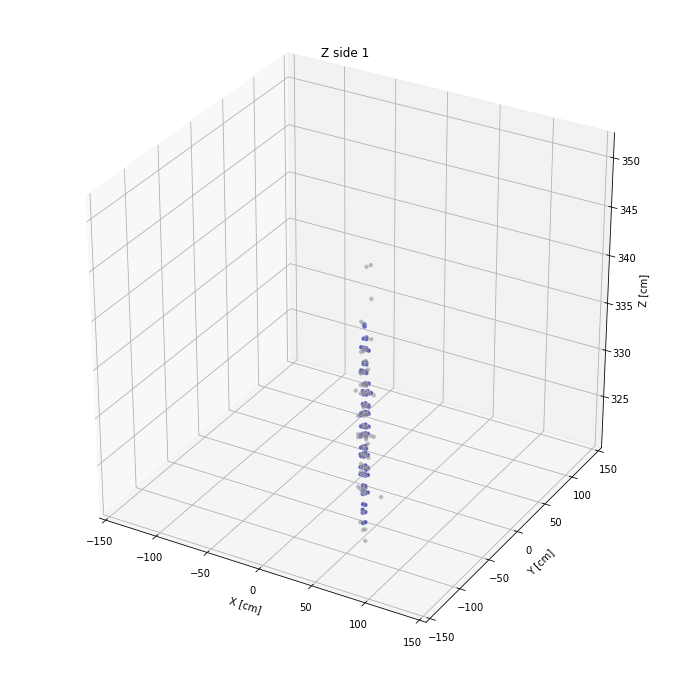

In [17]:

#%matplotlib notebook
plot3D(+1, tcs, new2Dcls, cl3D)

## NN 2D clusters

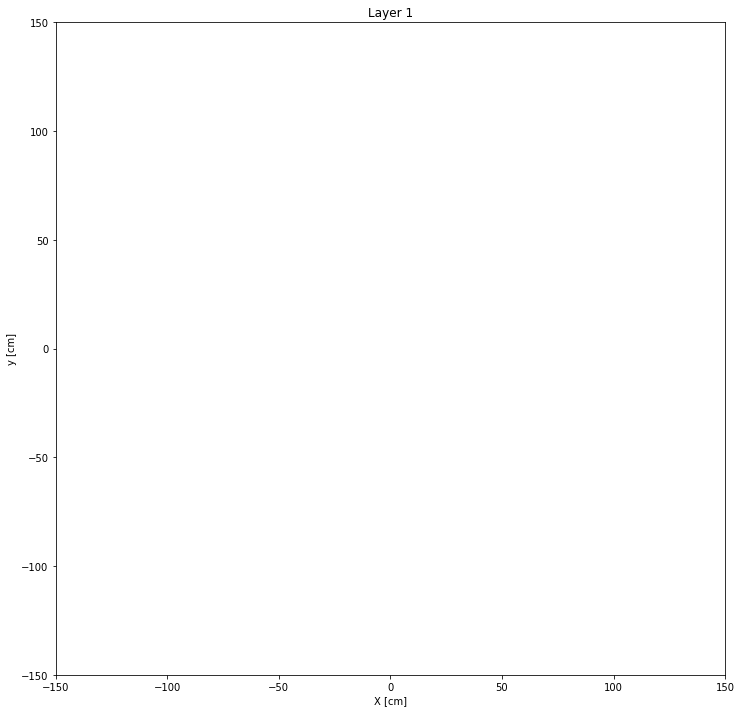

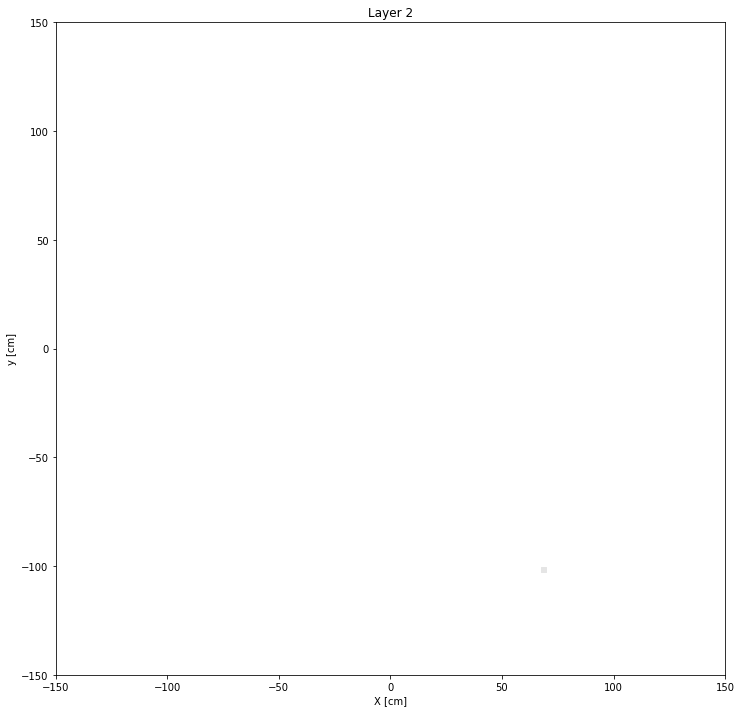

# layer 3, matched cells: 0


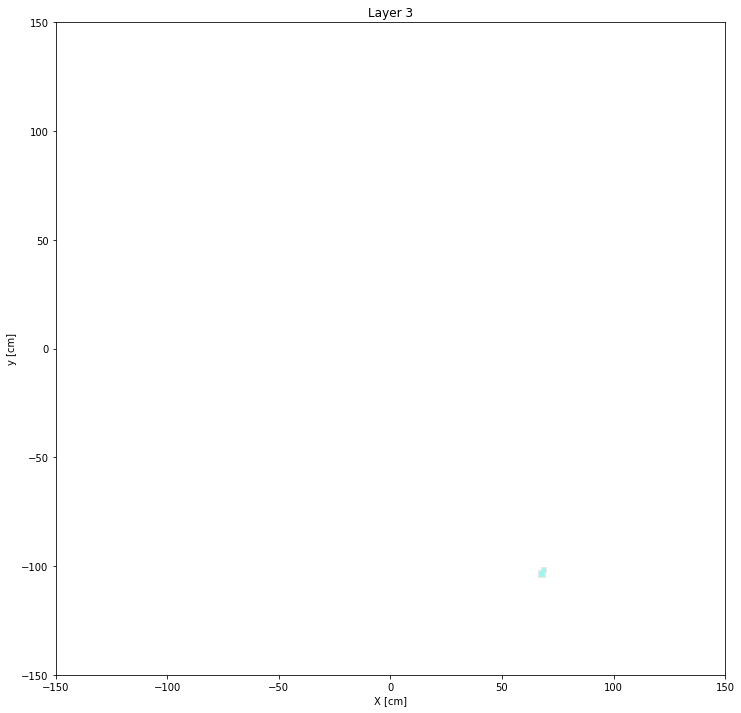

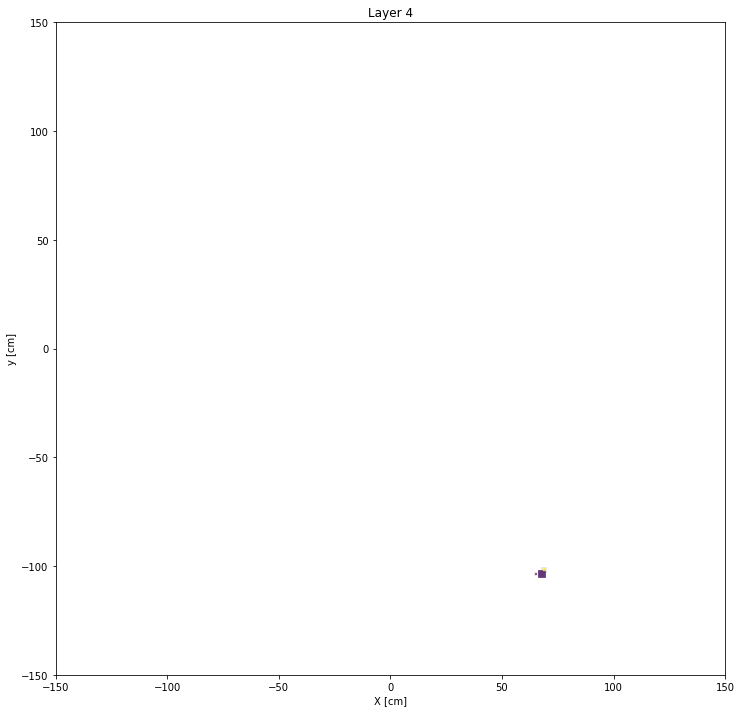

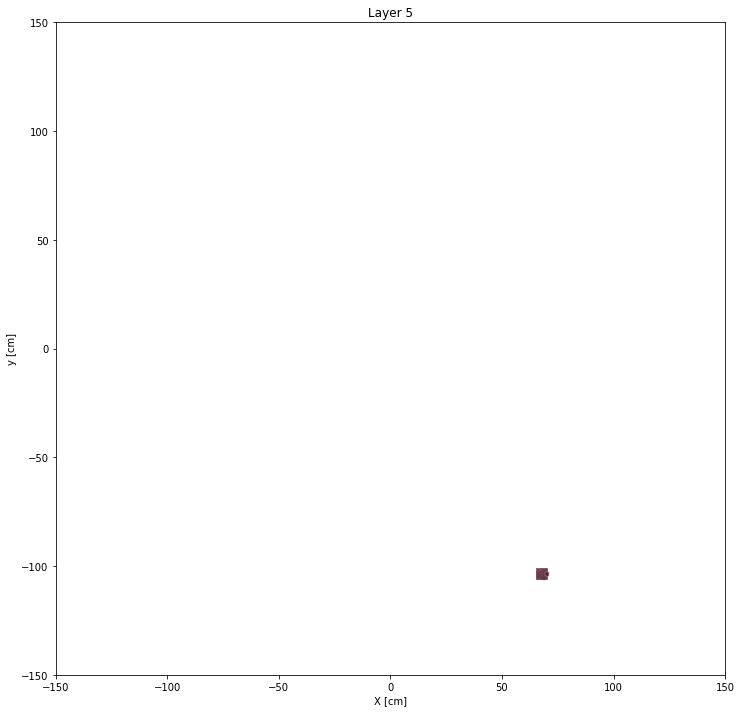

# layer 6, matched cells: 0


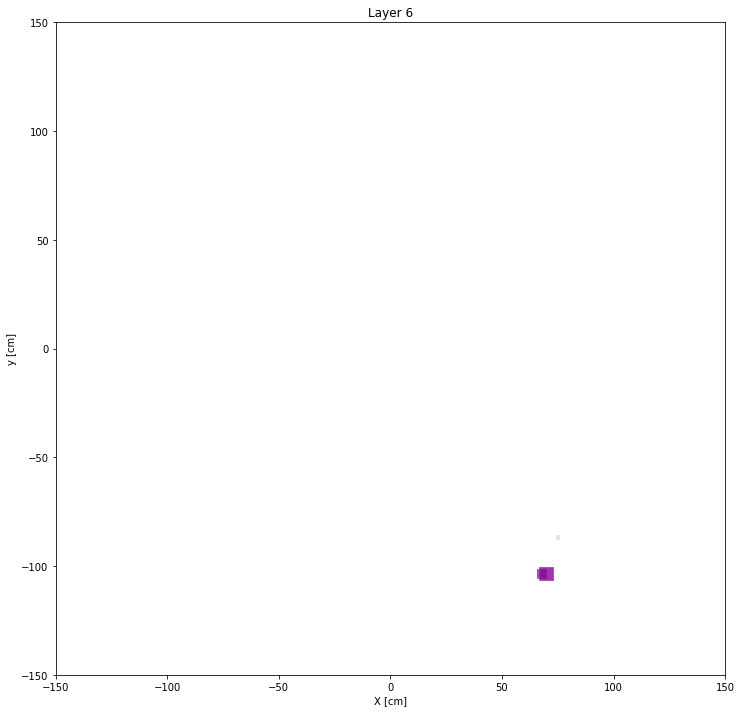

# layer 7, matched cells: 0


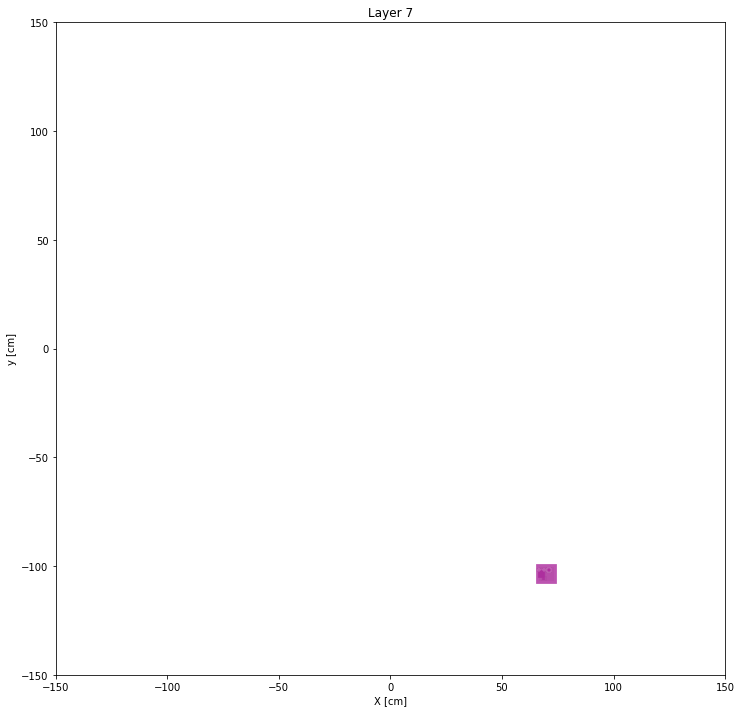

# layer 8, matched cells: 0


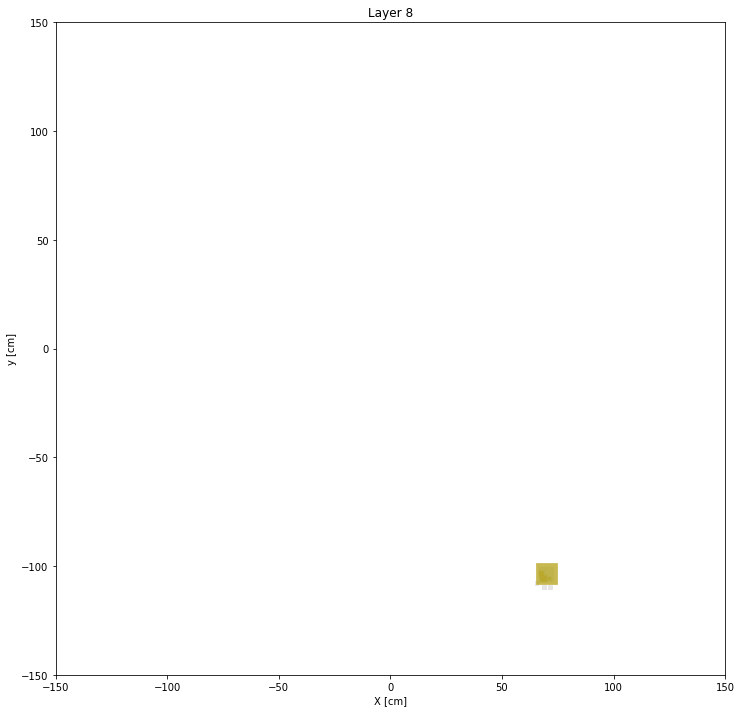

# layer 9, matched cells: 0


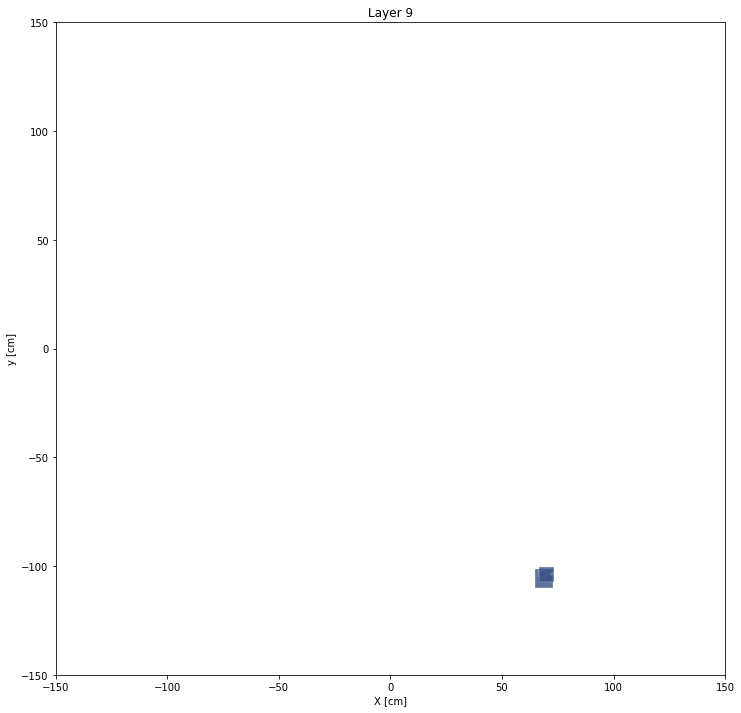

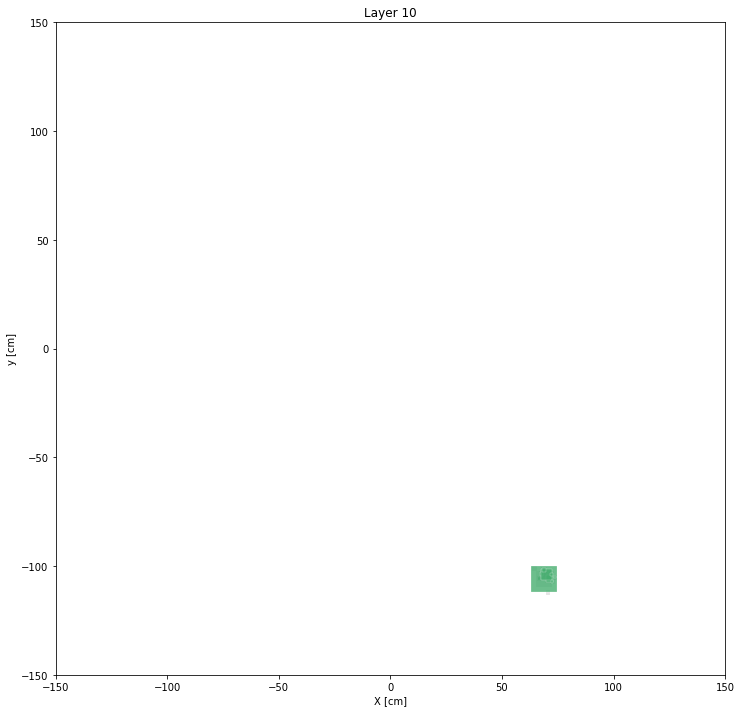

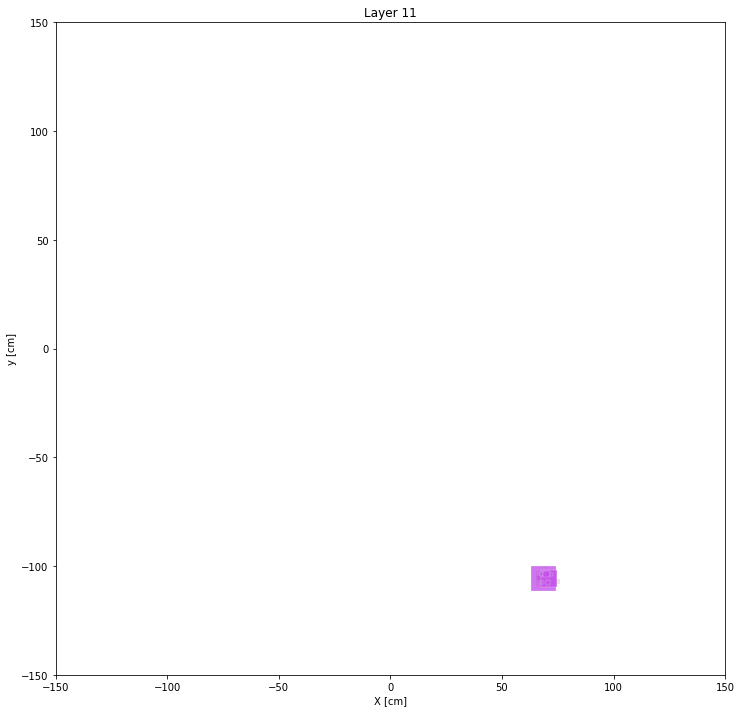

# layer 12, matched cells: 0


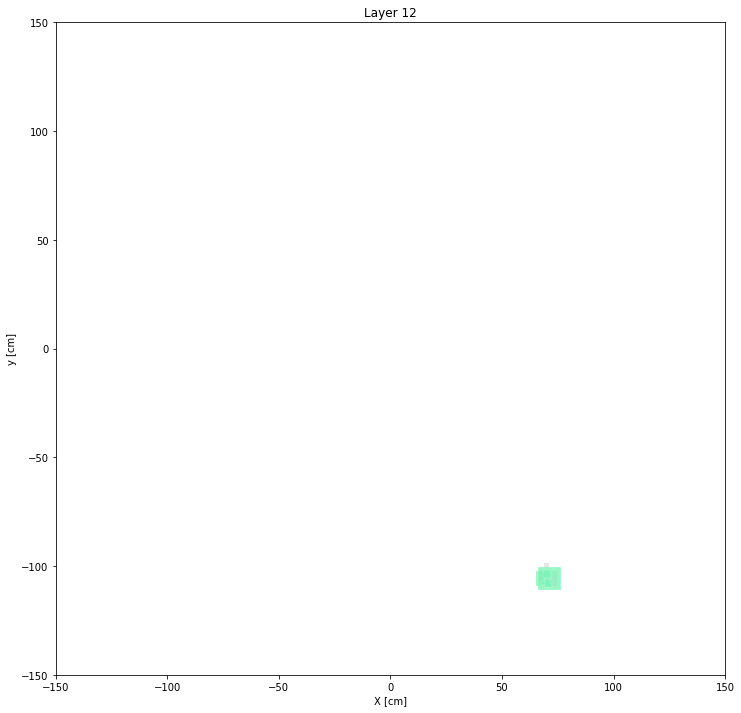

# layer 13, matched cells: 0


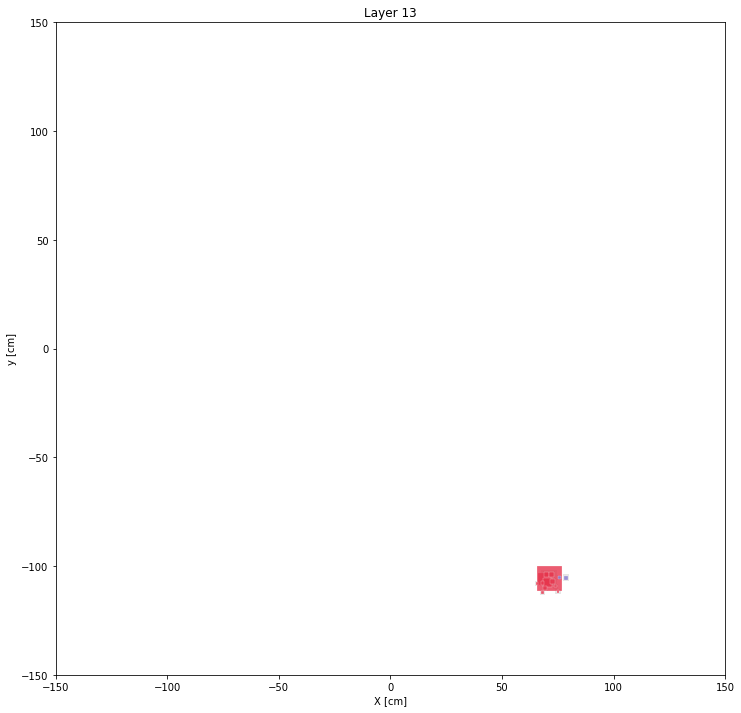

# layer 14, matched cells: 0


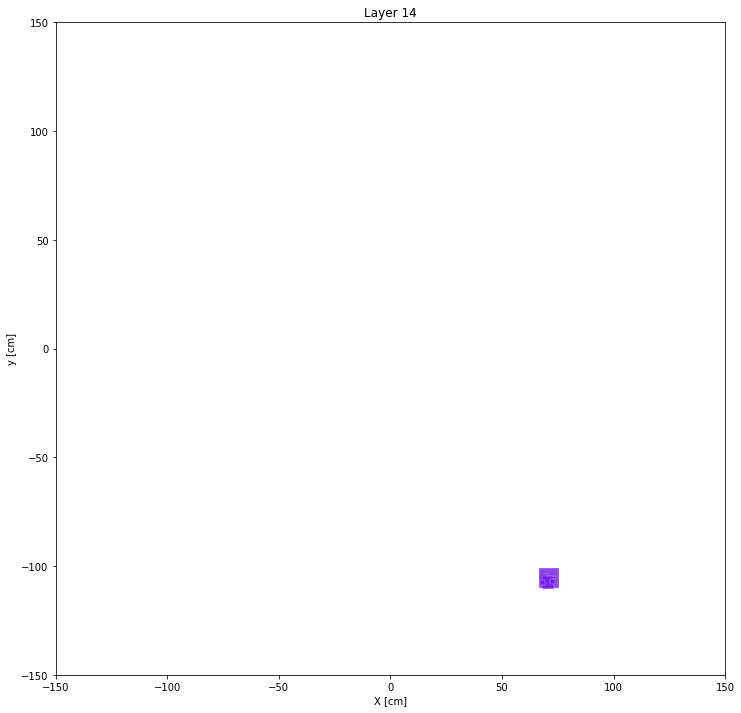

# layer 15, matched cells: 0


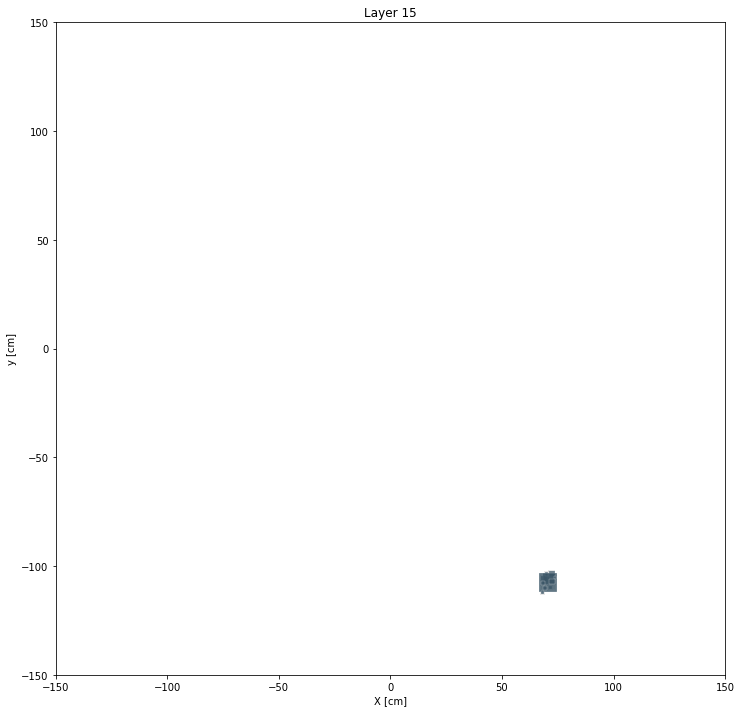

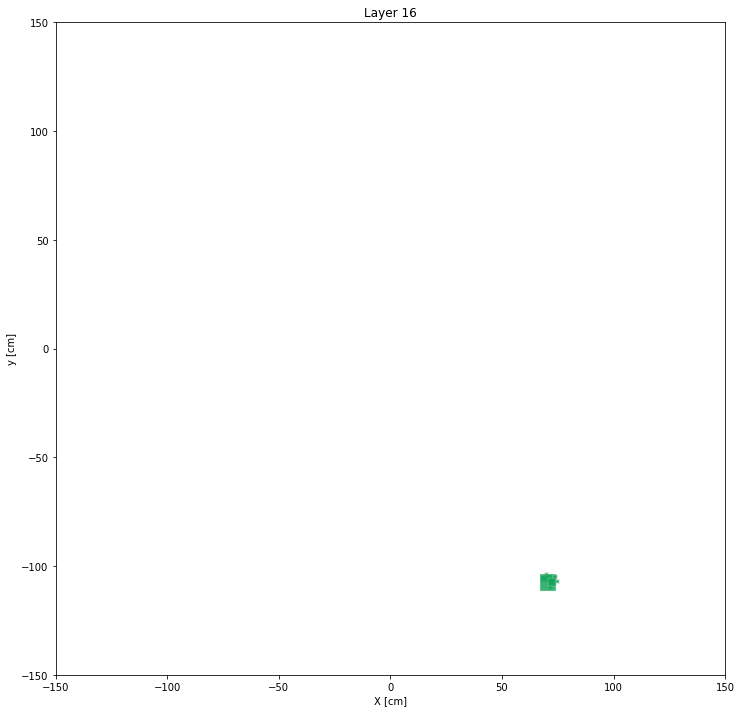

# layer 17, matched cells: 0


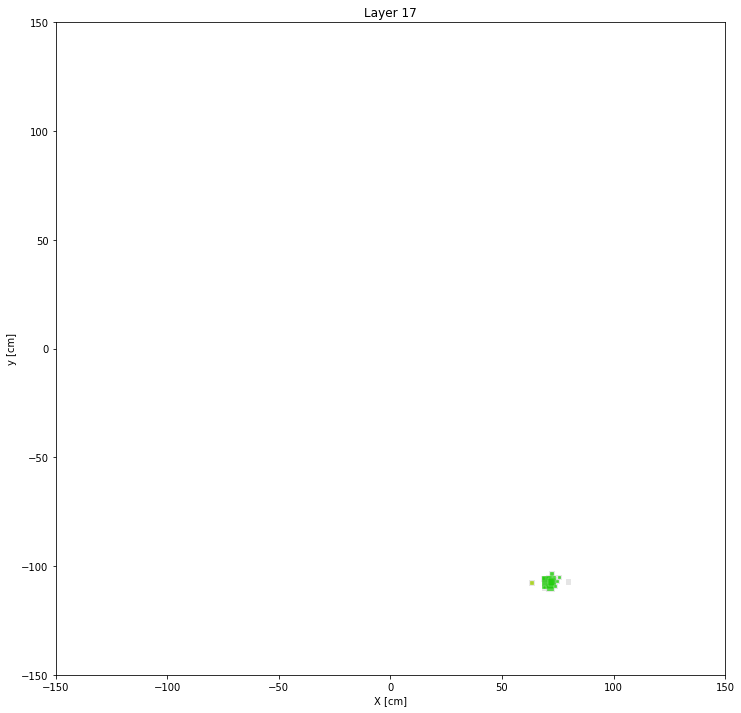

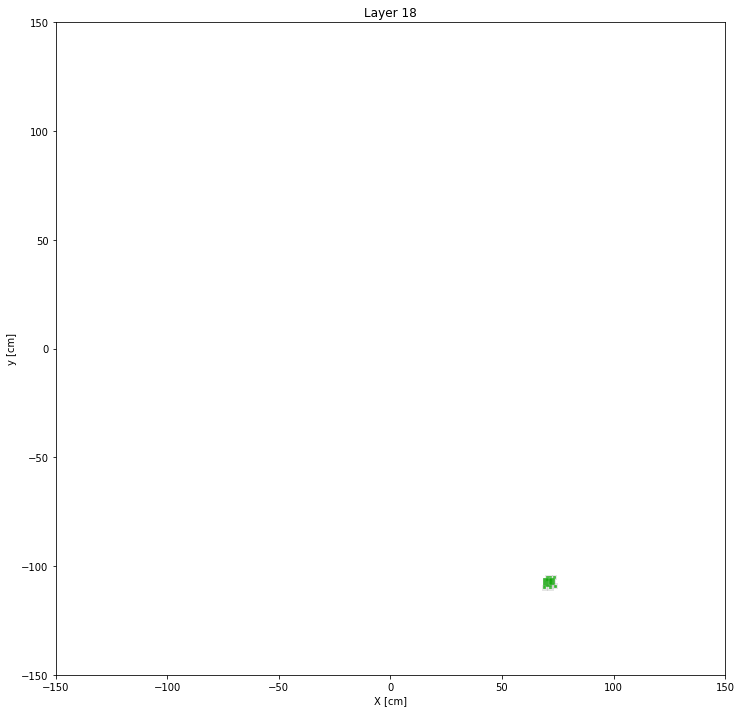

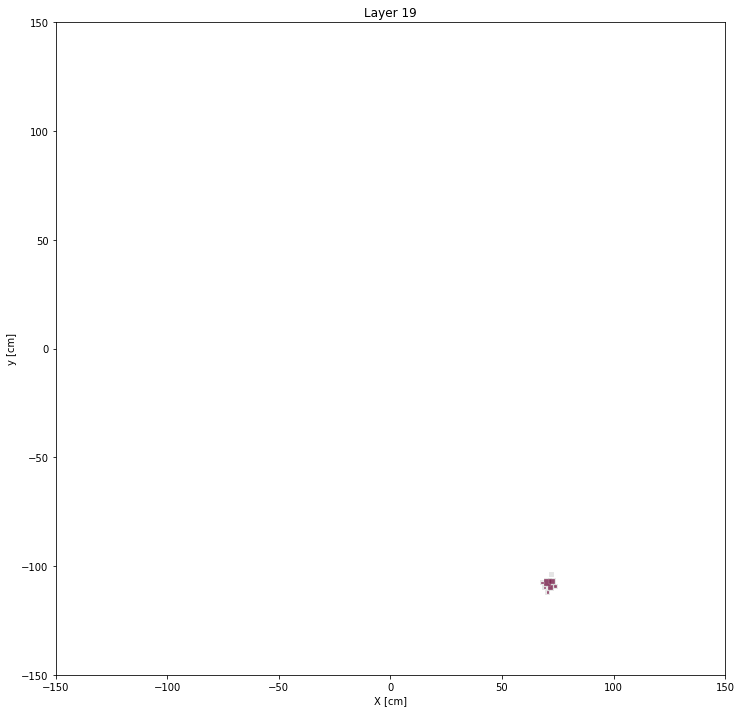

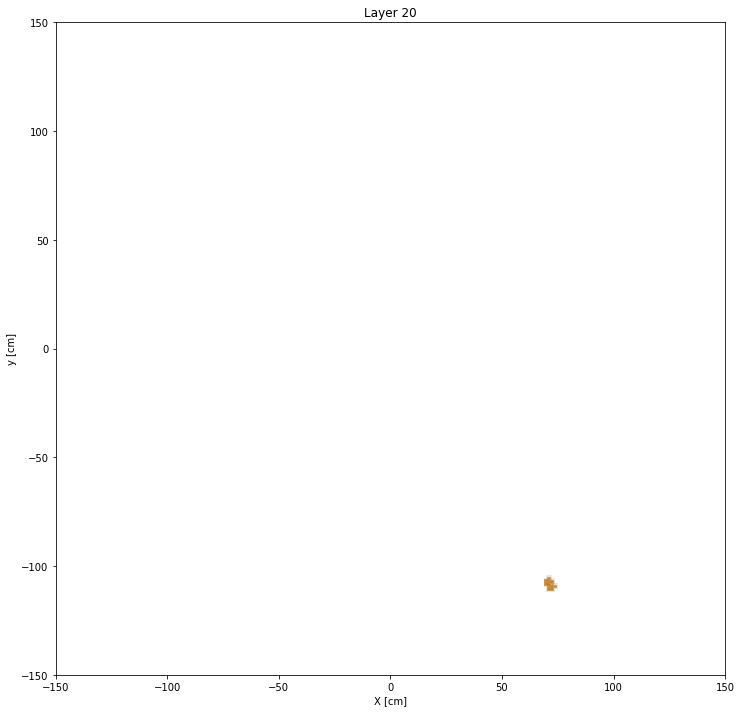

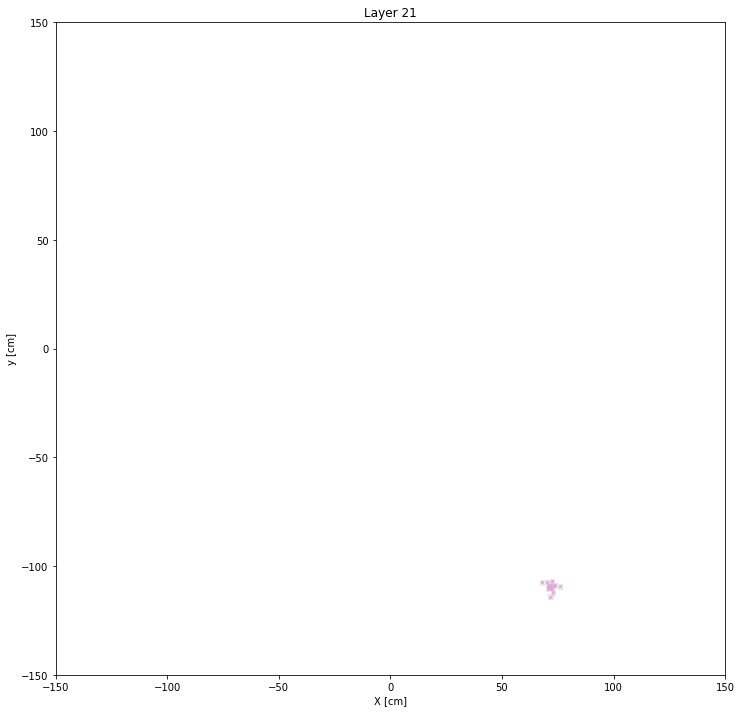

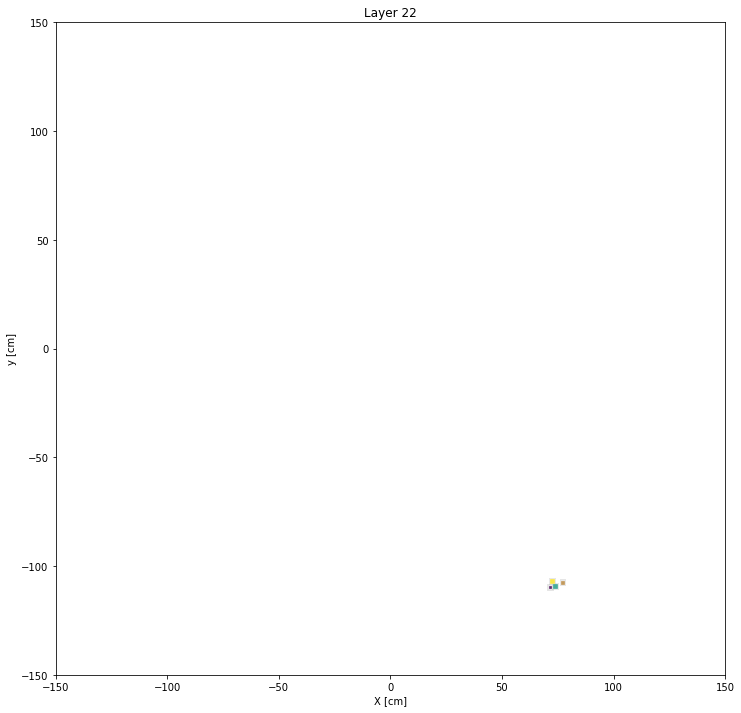

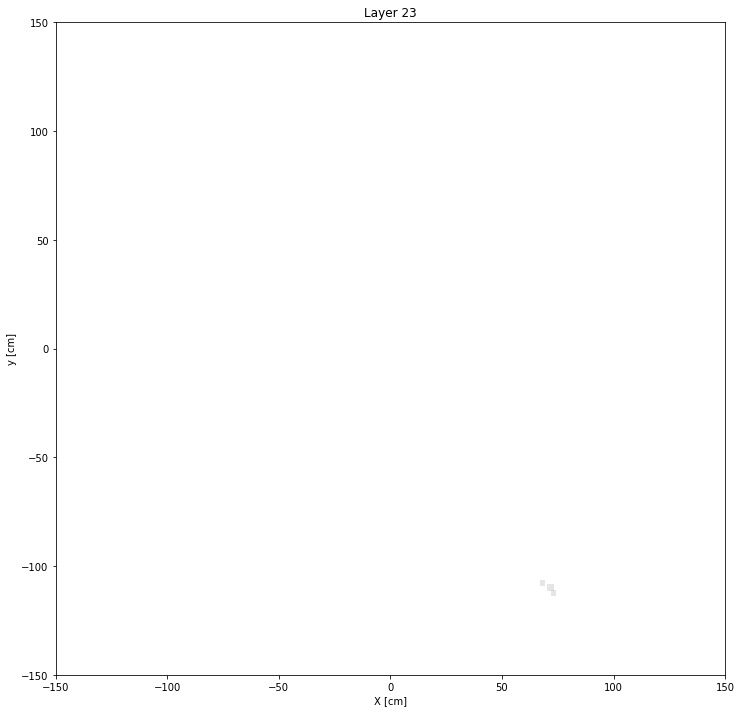

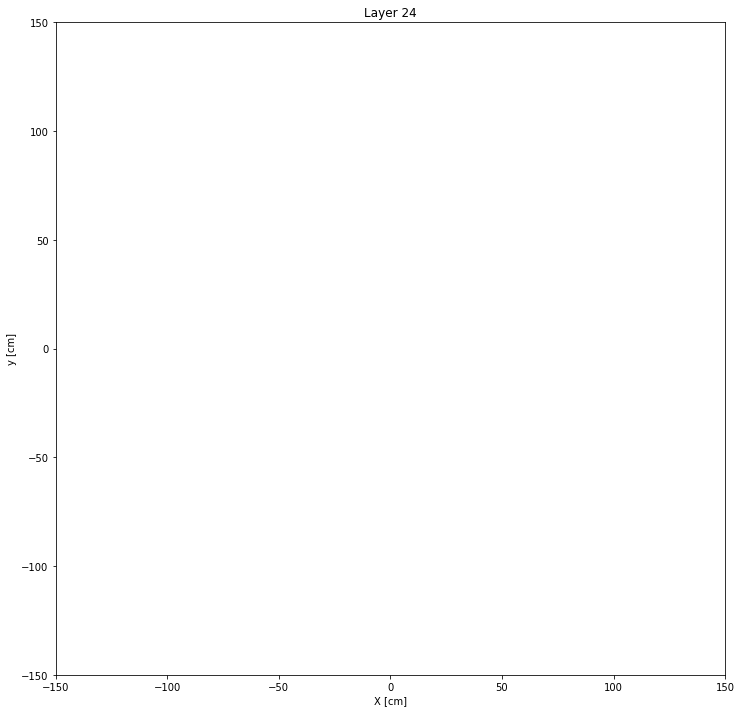

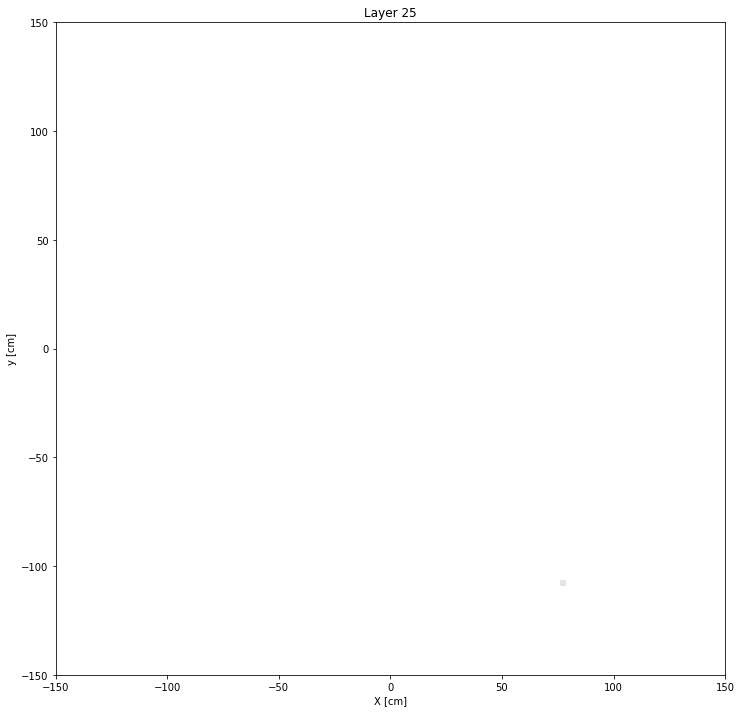

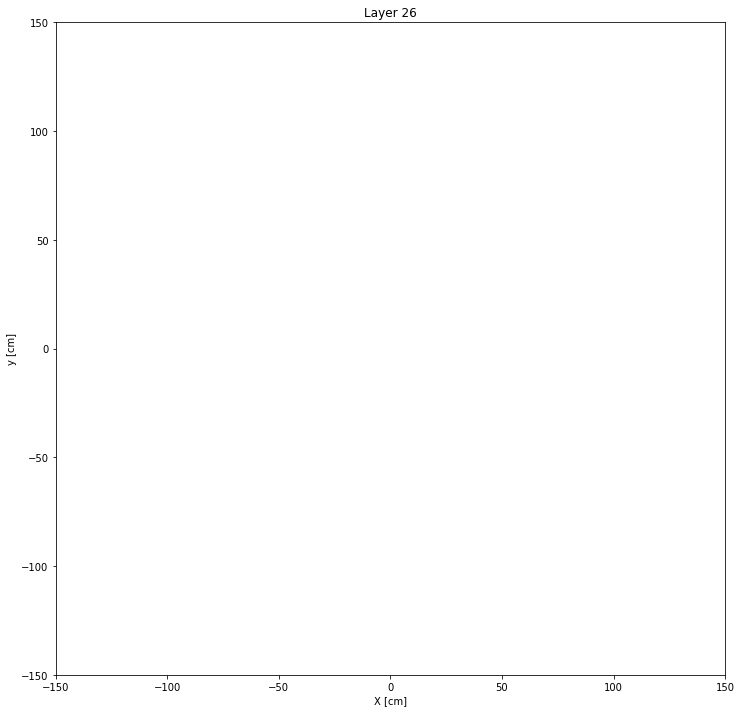

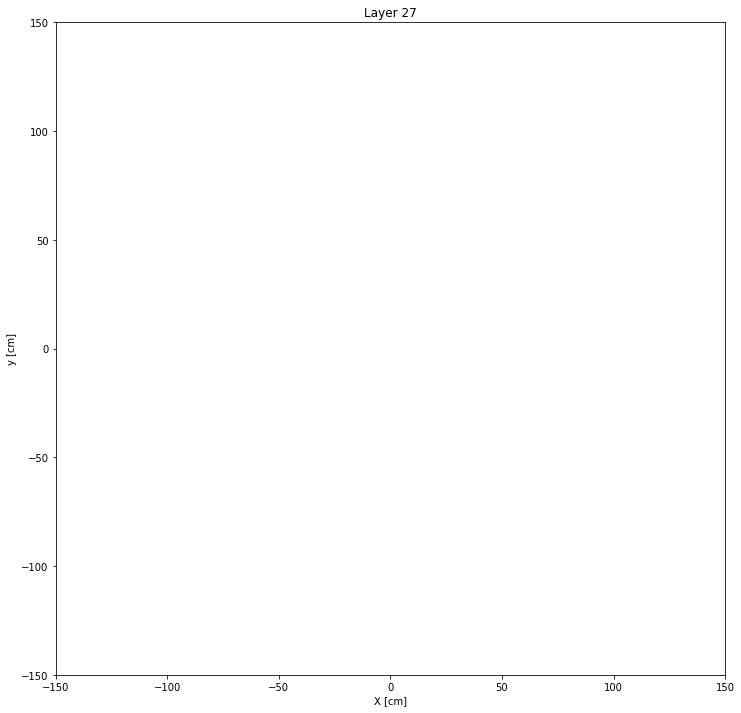

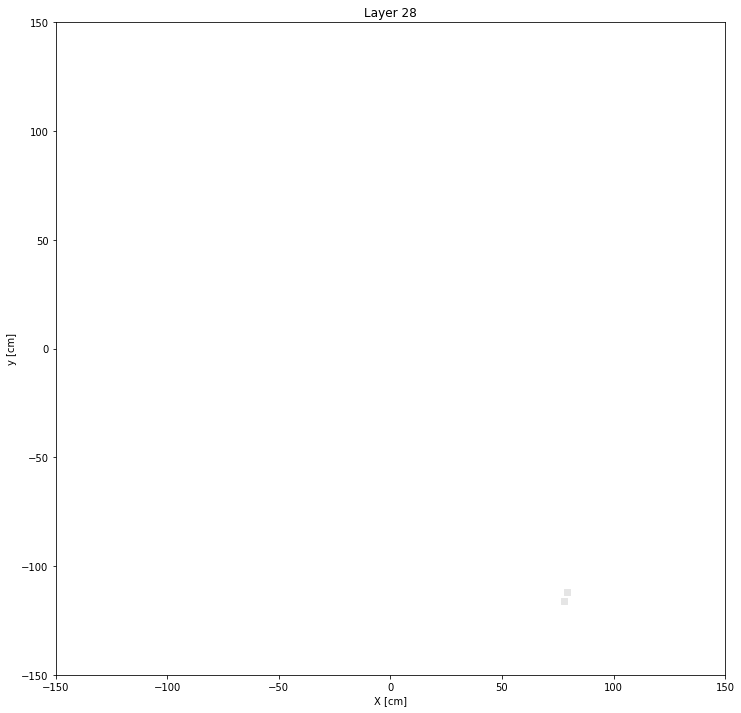

In [19]:
zside = 1
for layer in range(1,29):
    plotLayer(layer, zside, tcs, cl2d, mcl2d)


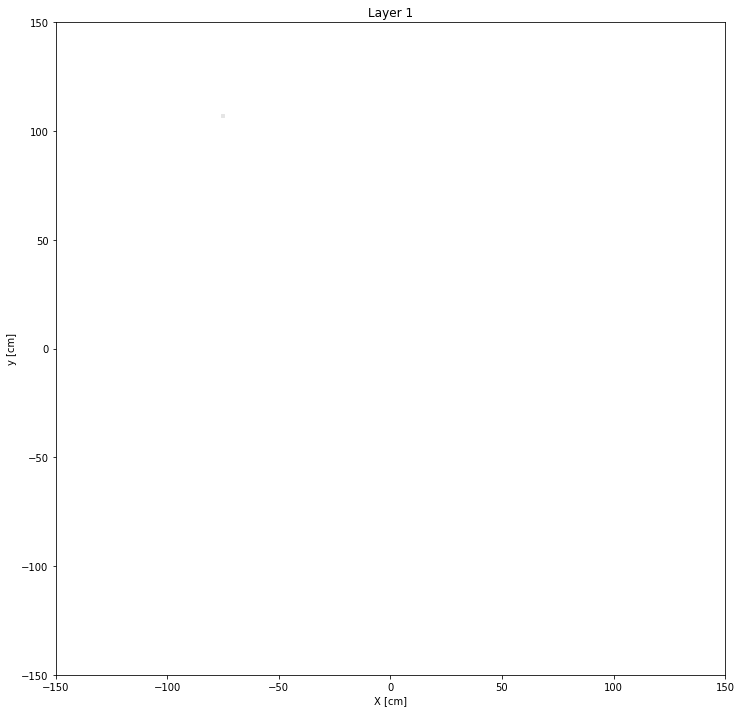

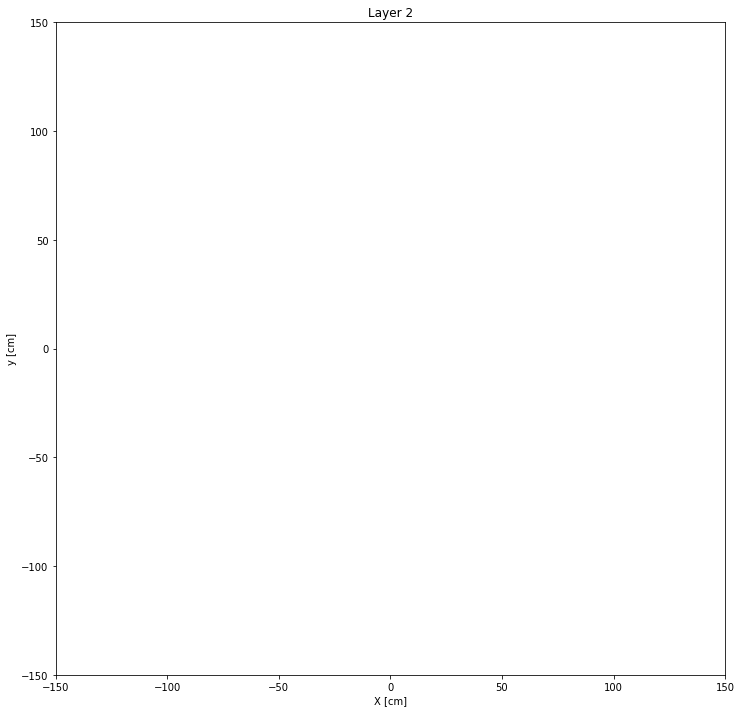

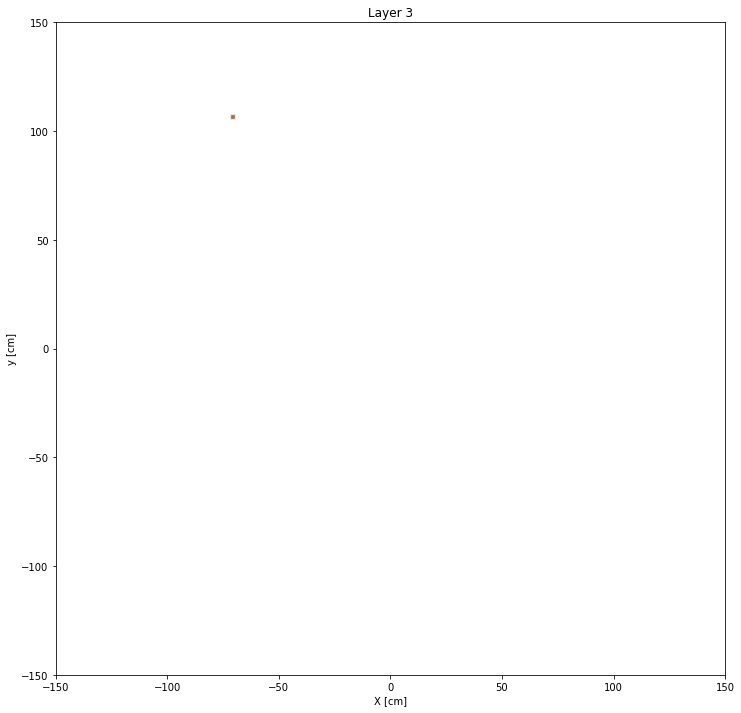

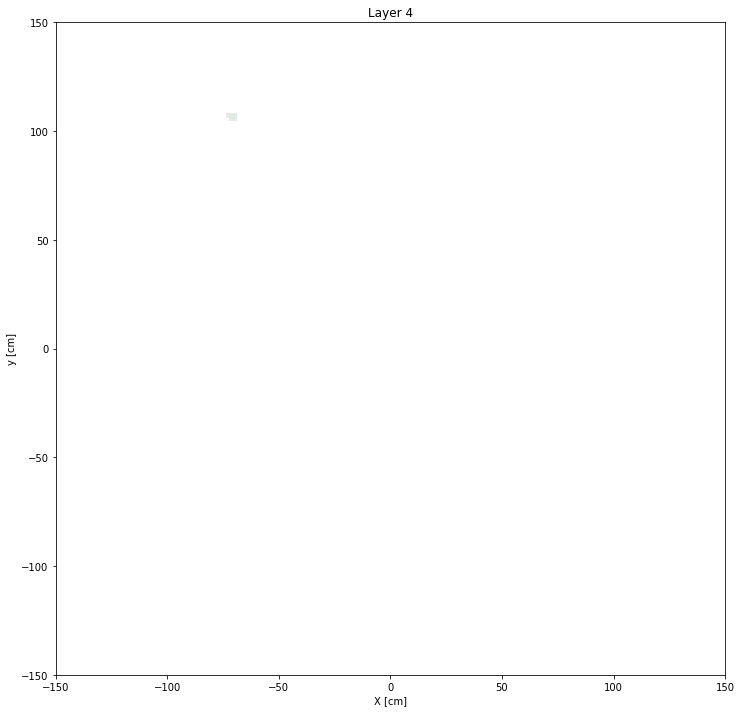

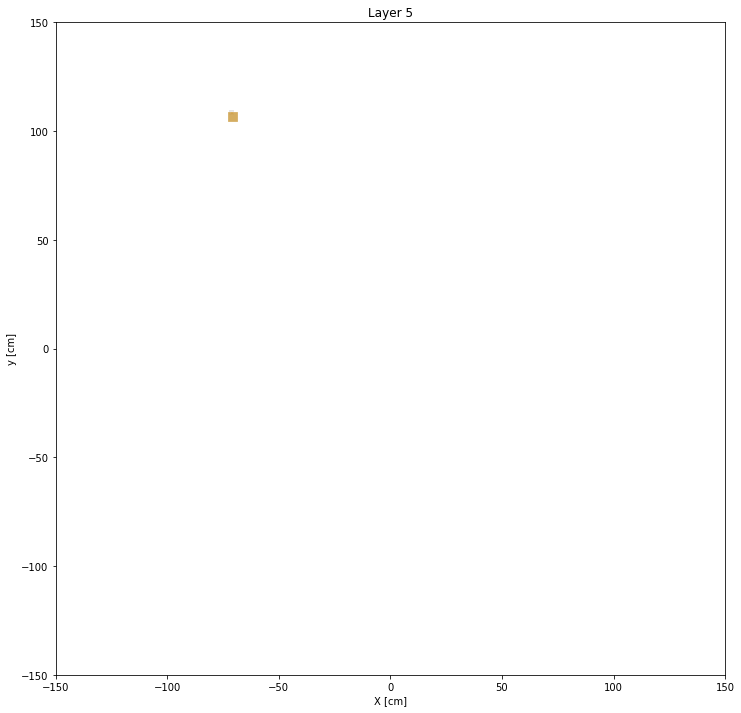

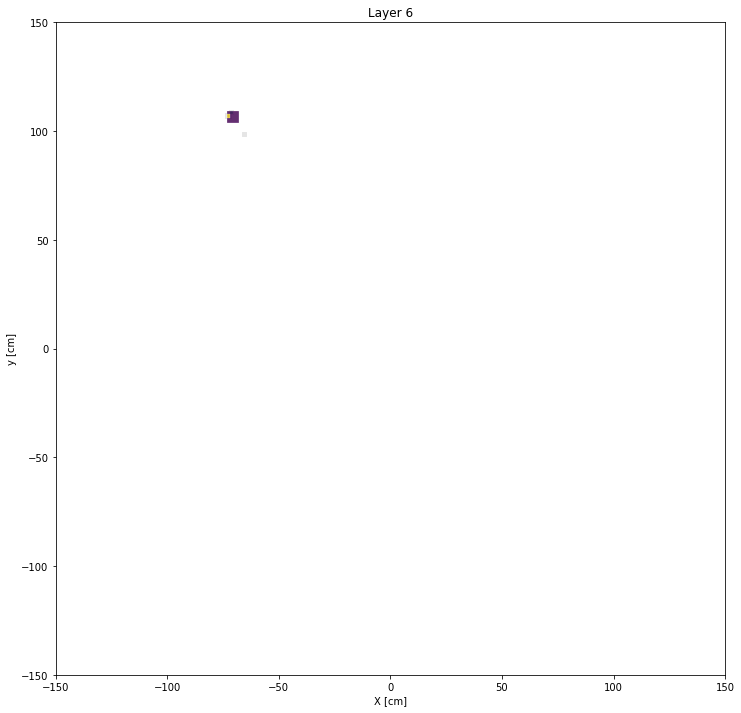

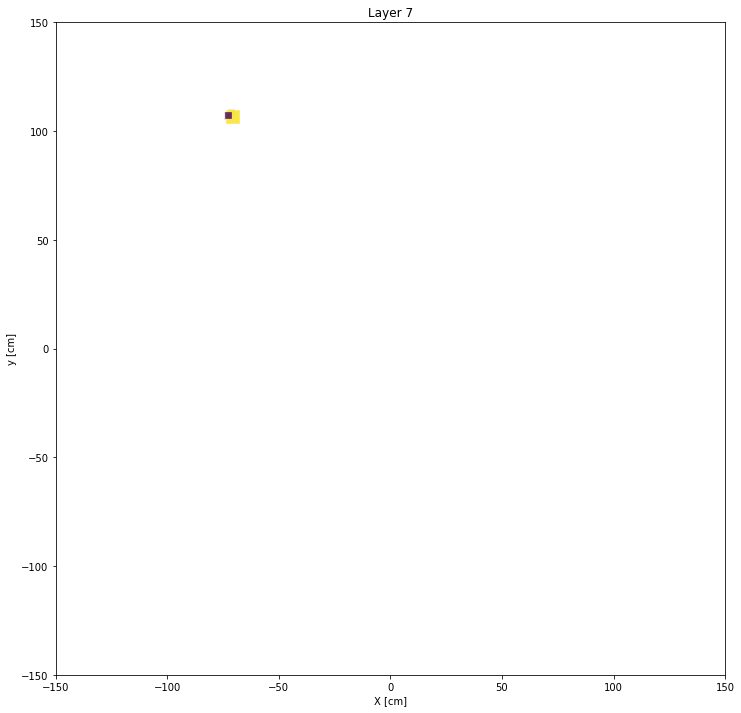

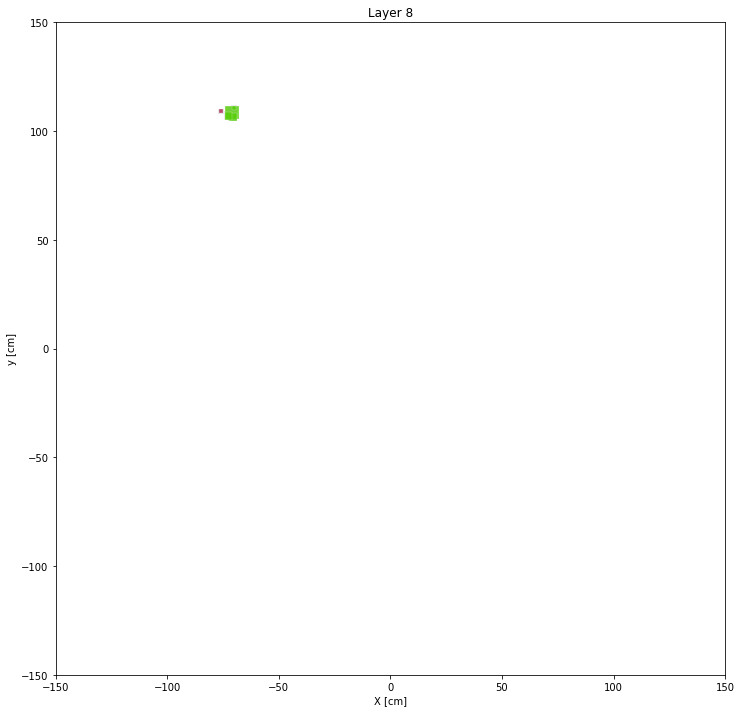

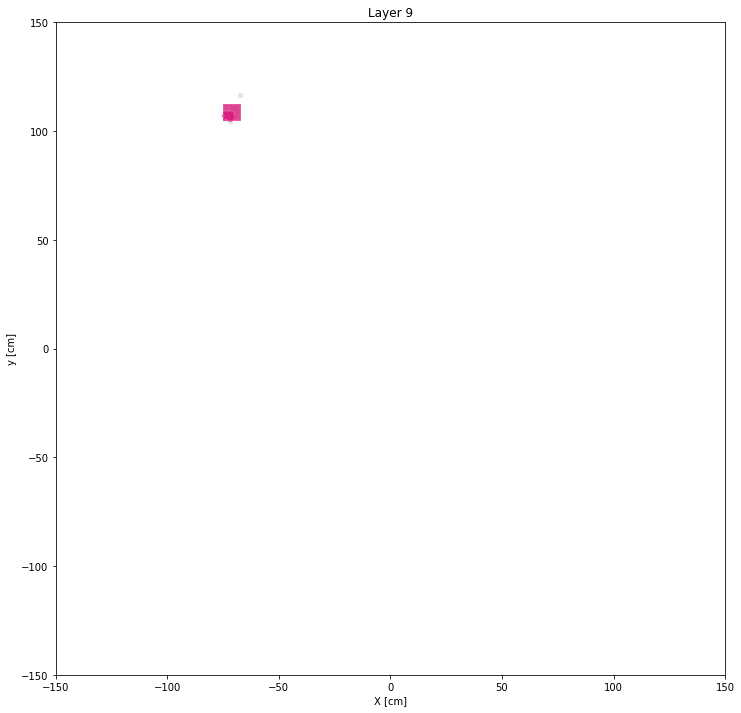

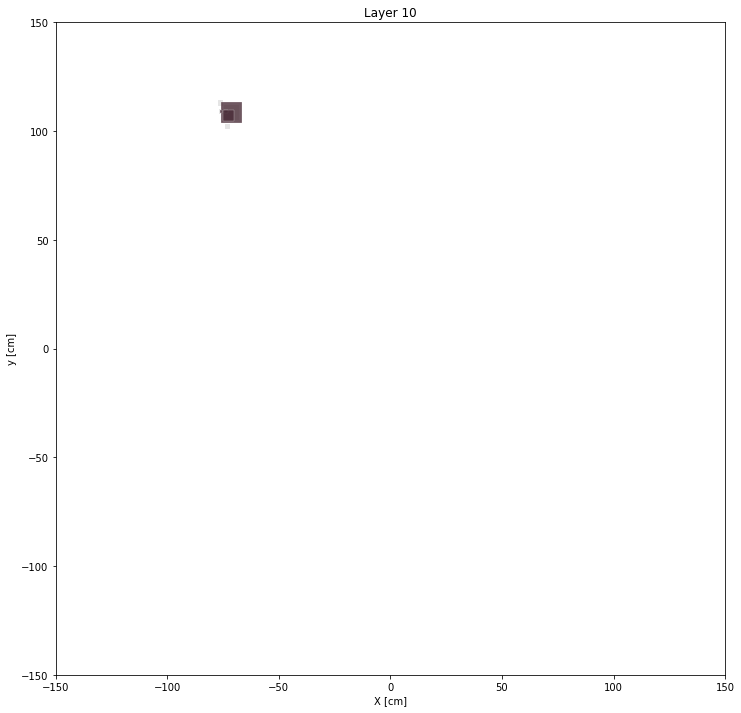

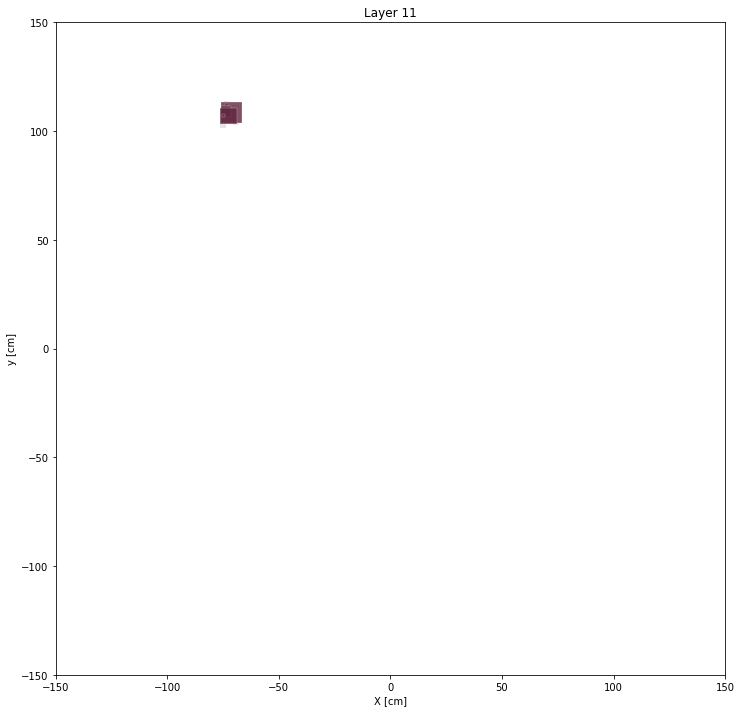

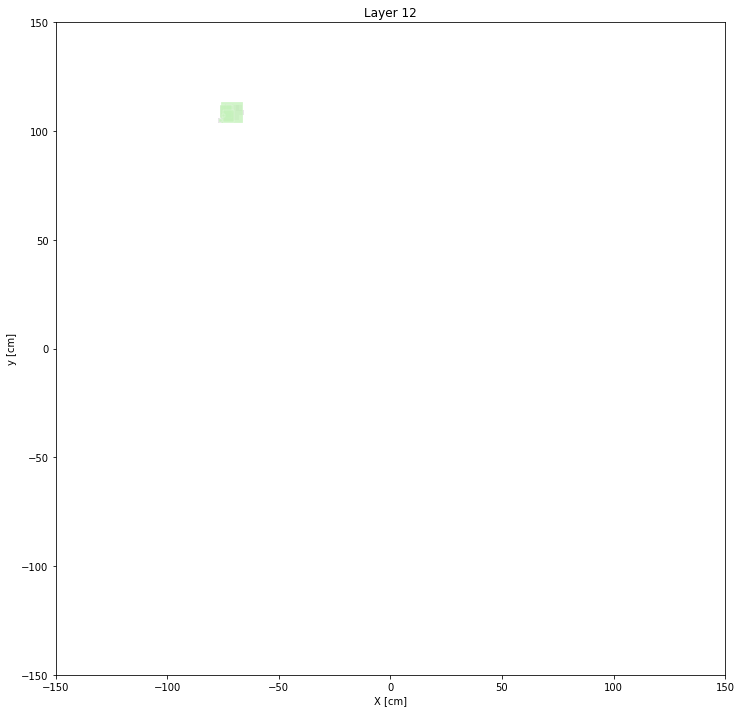

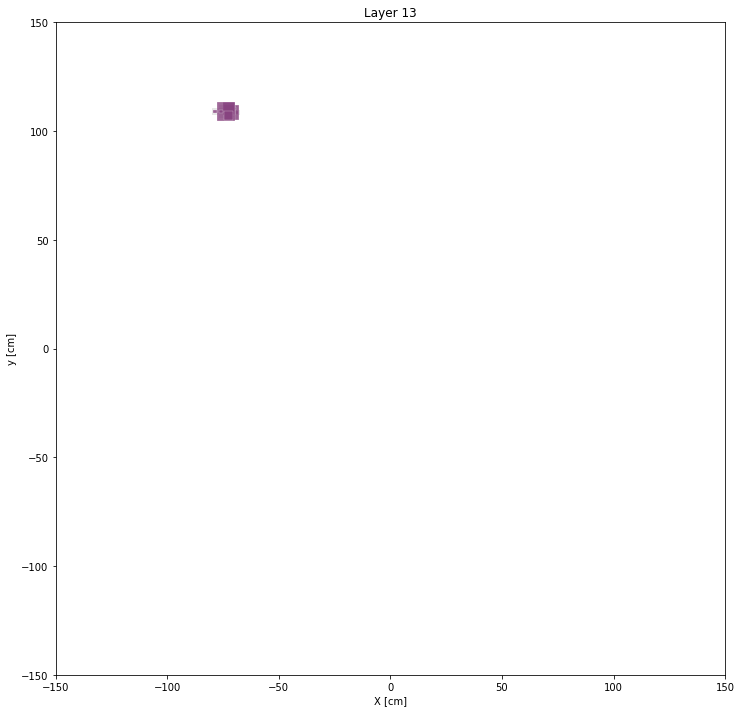

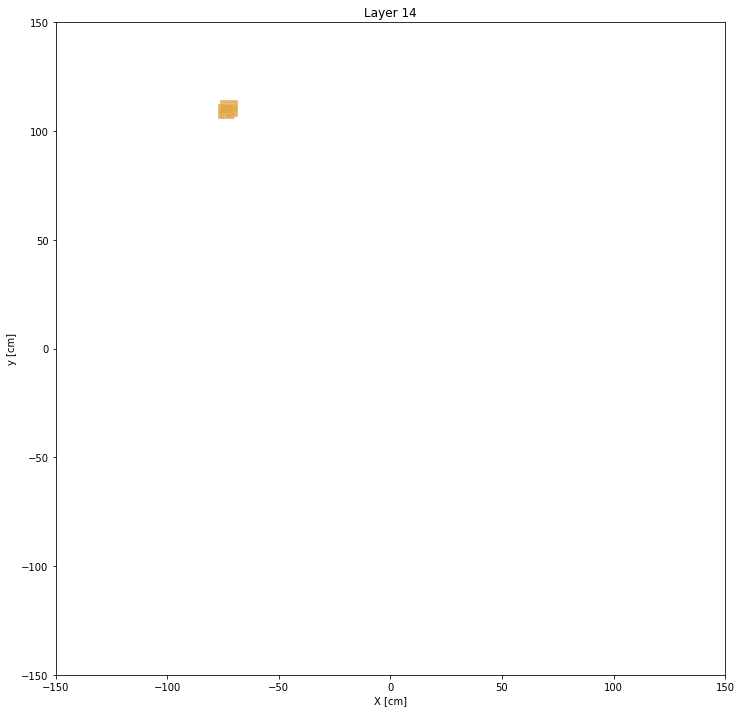

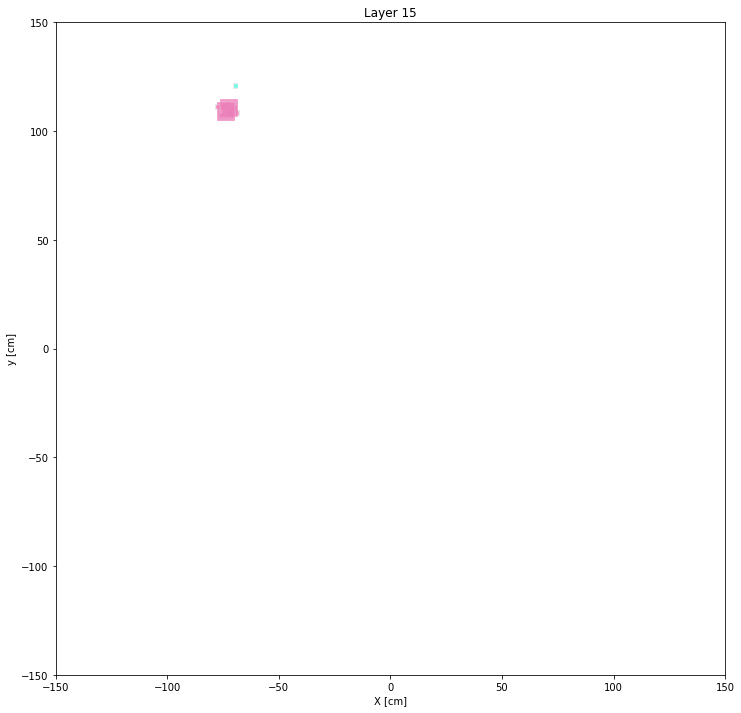

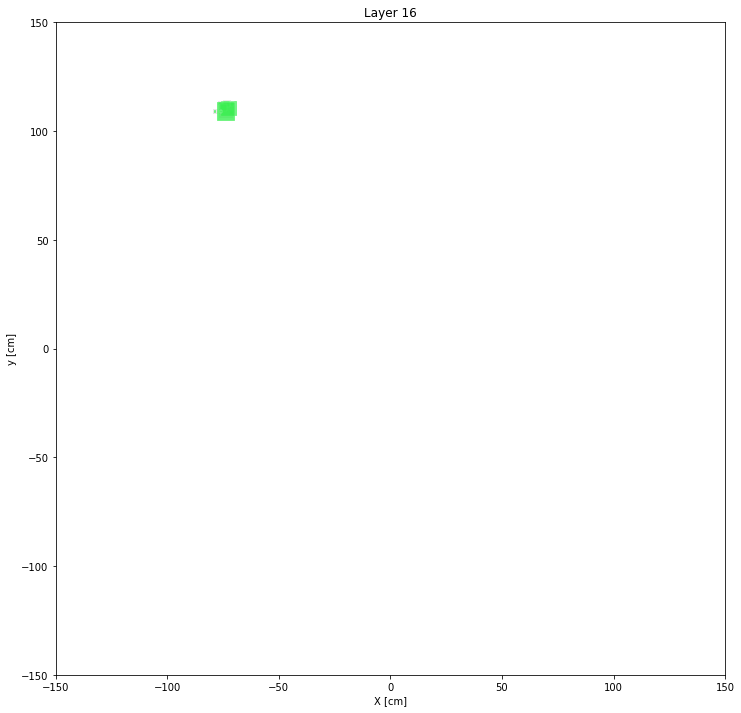

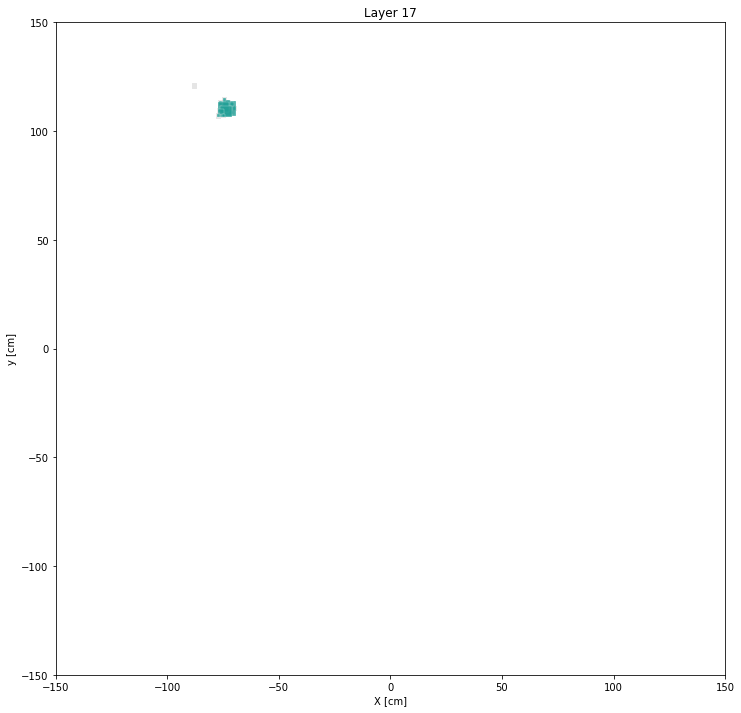

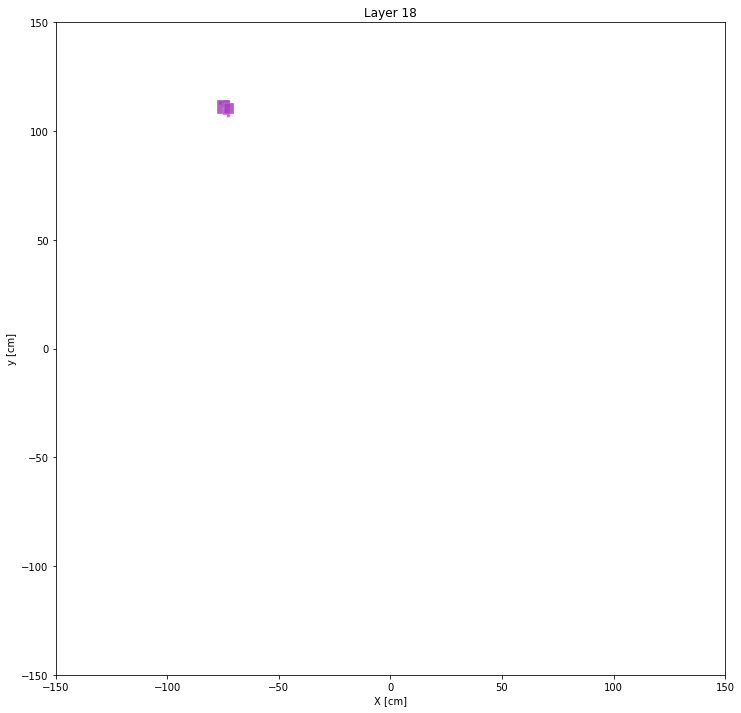

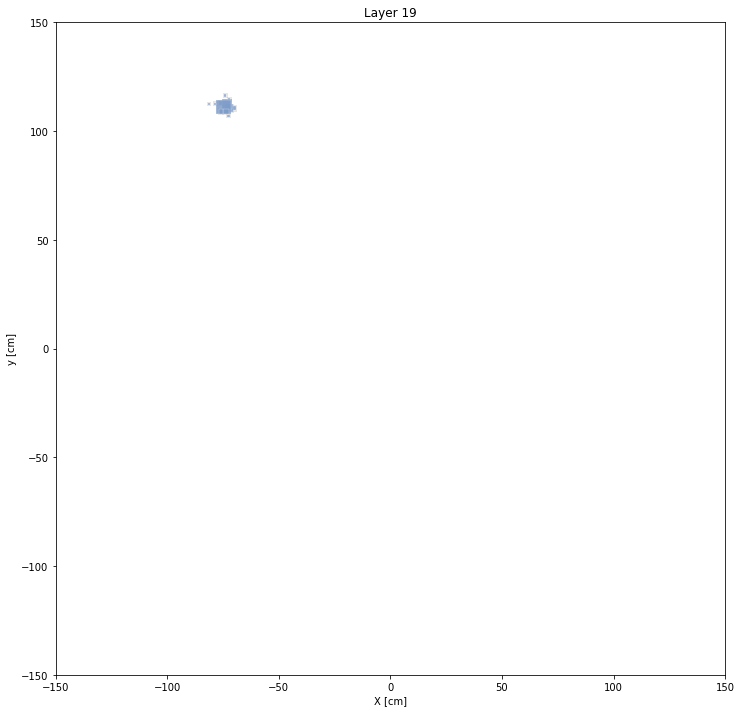

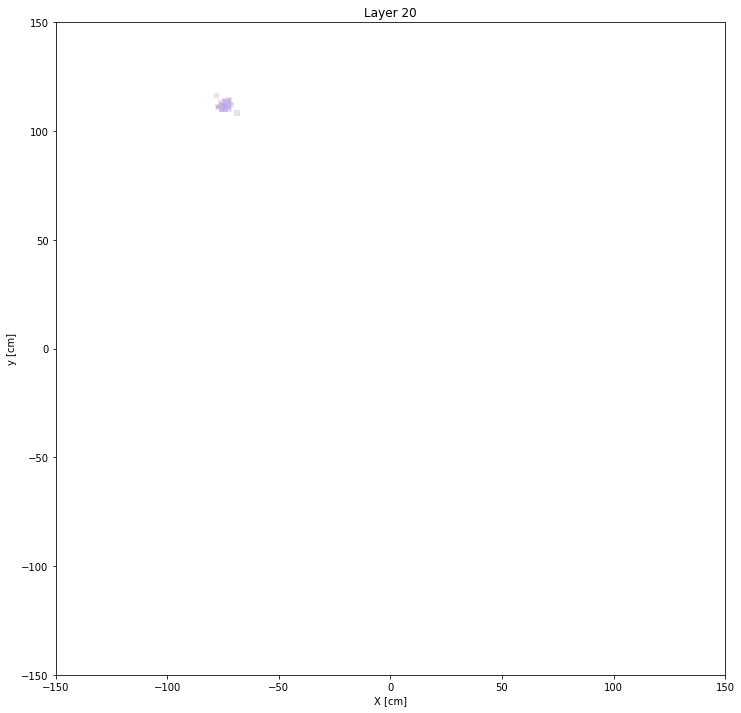

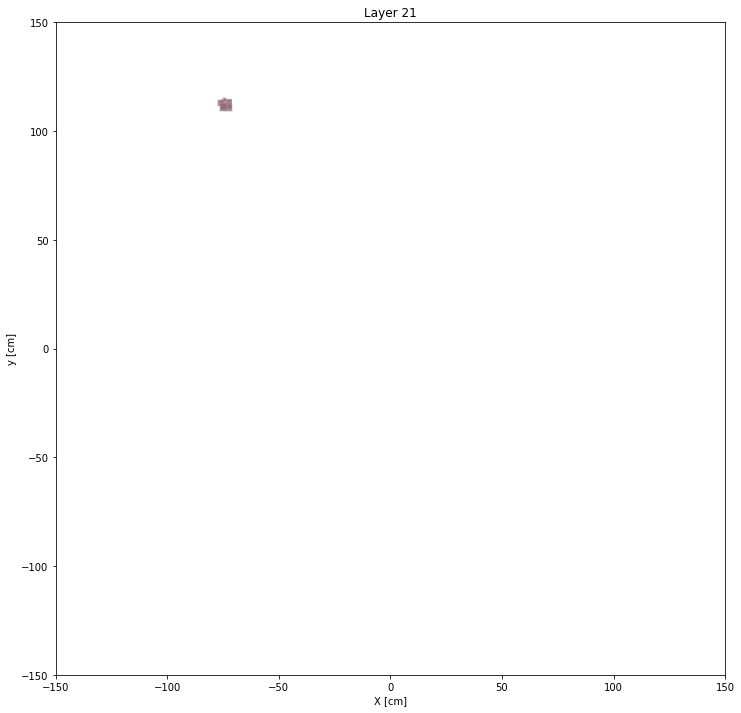

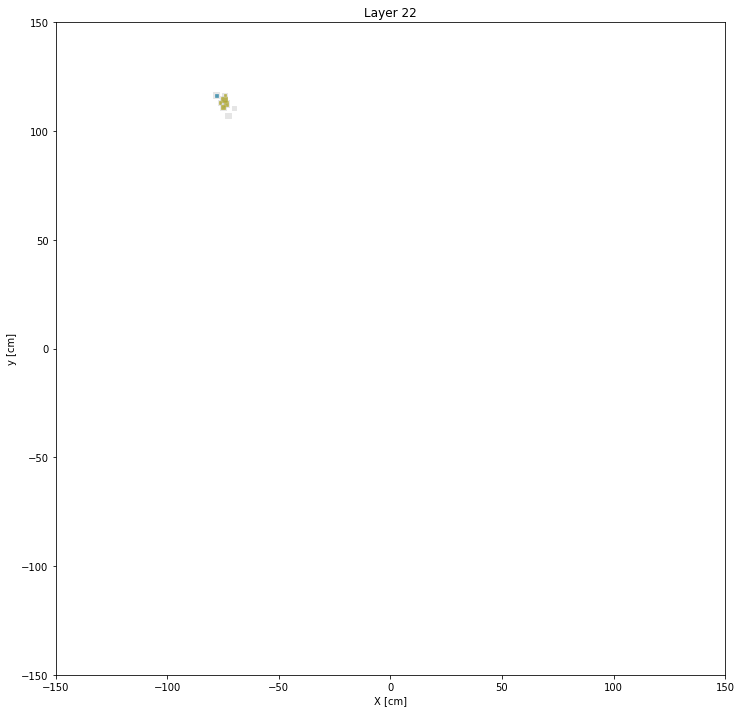

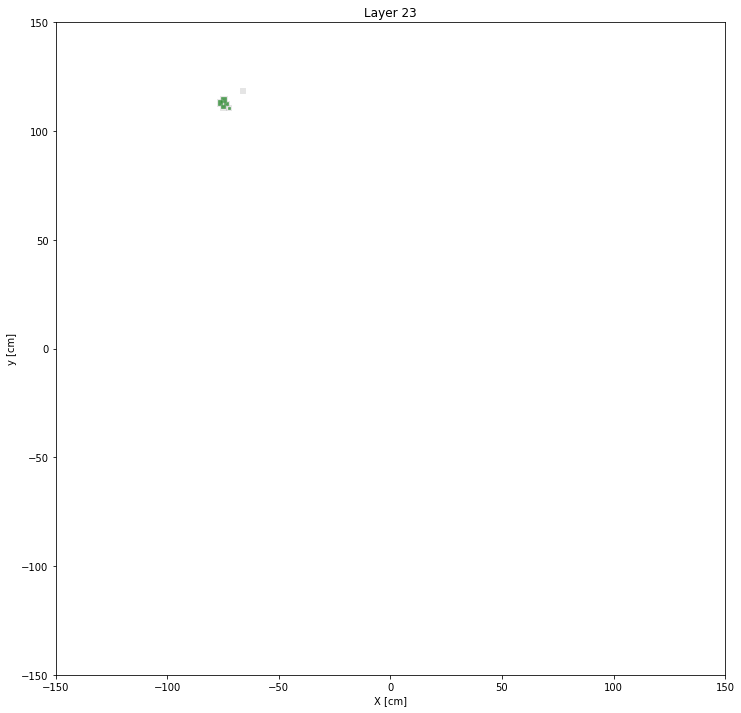

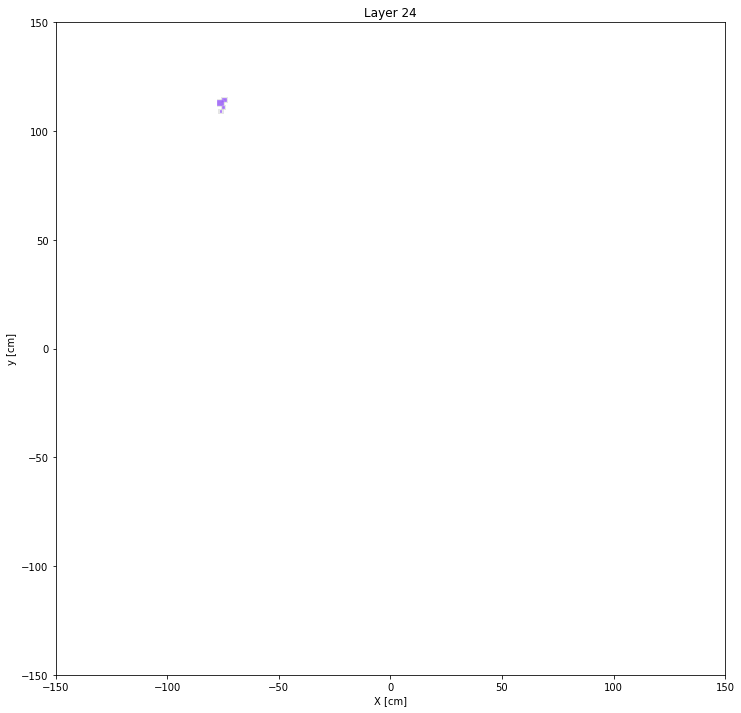

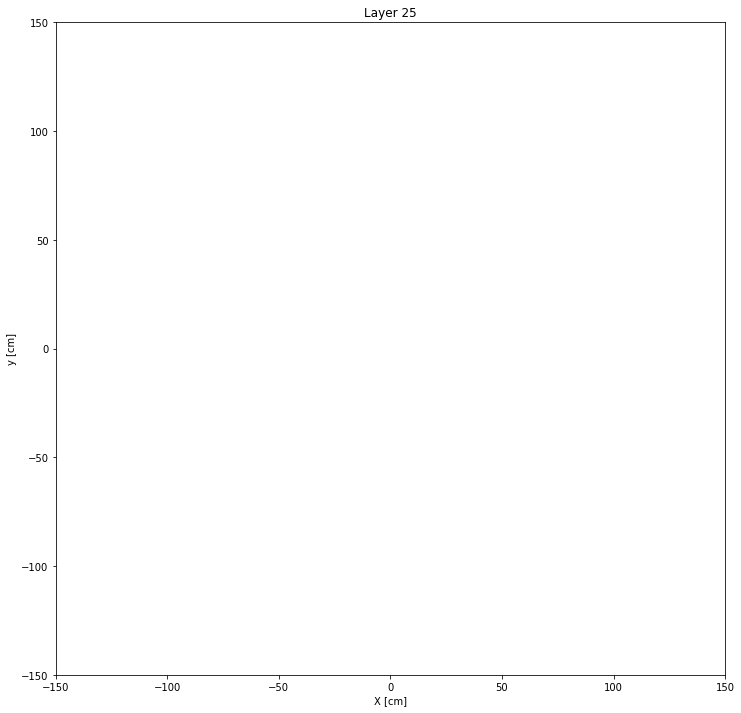

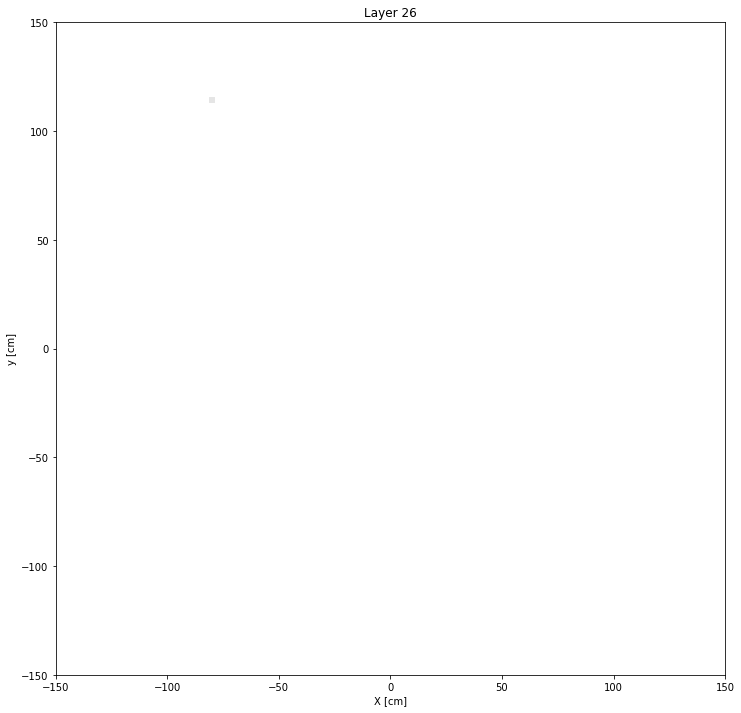

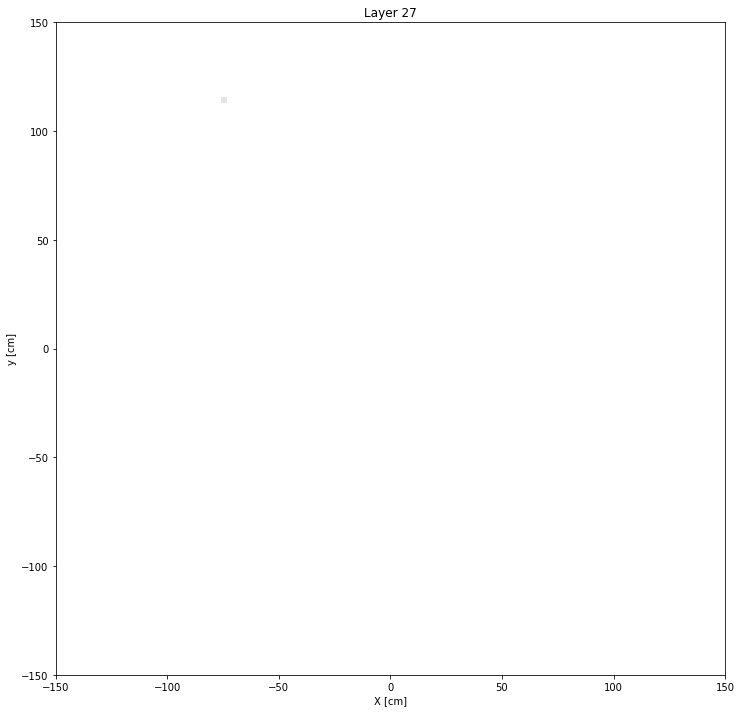

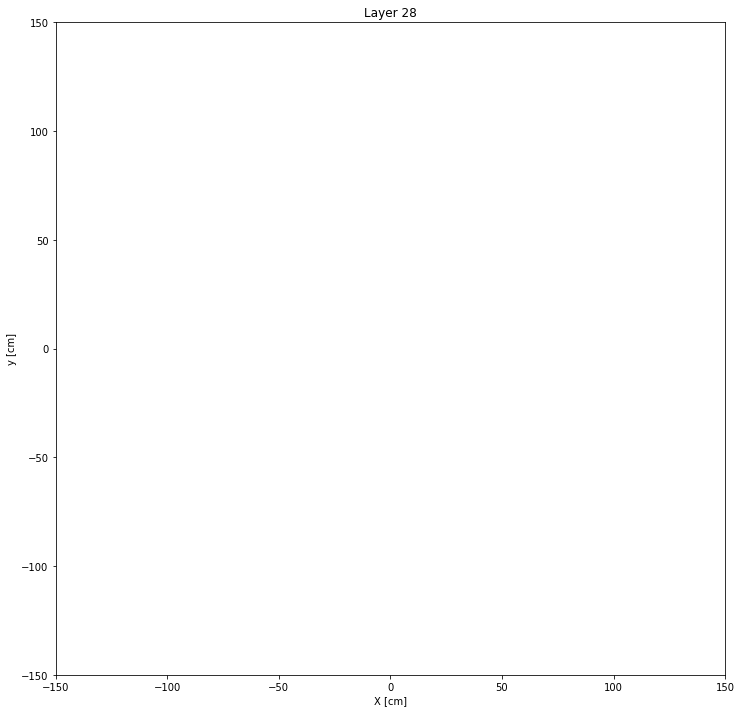

In [17]:
zside = -1
for layer in range(1,29):
    plotLayer(layer, zside, tcs, cl2d, mcl2d)

## DBSCAN 2D clusters

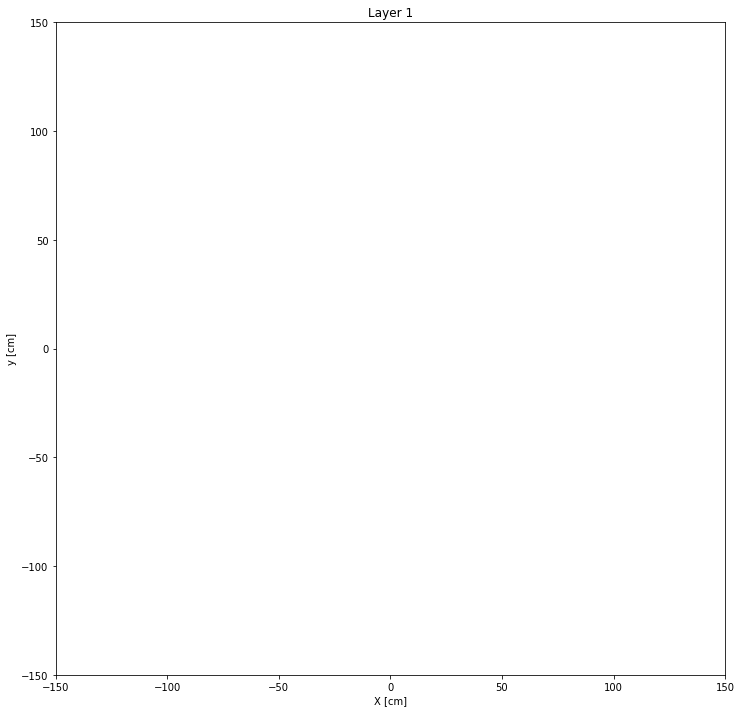

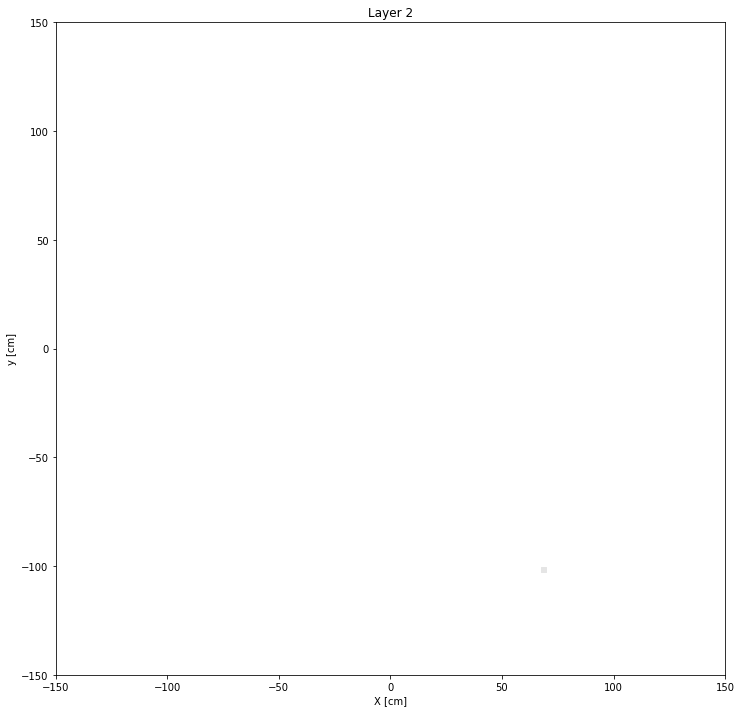

# layer 3, matched cells: 0


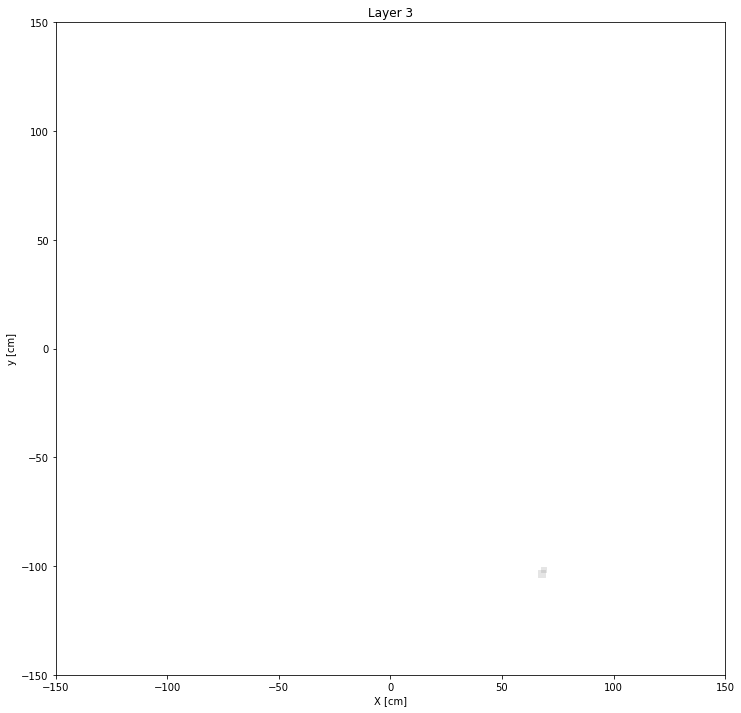

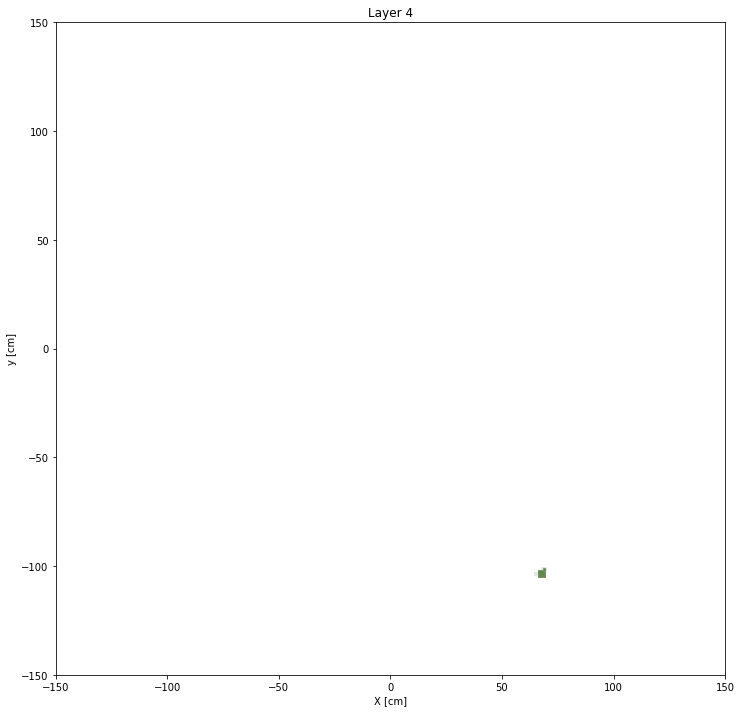

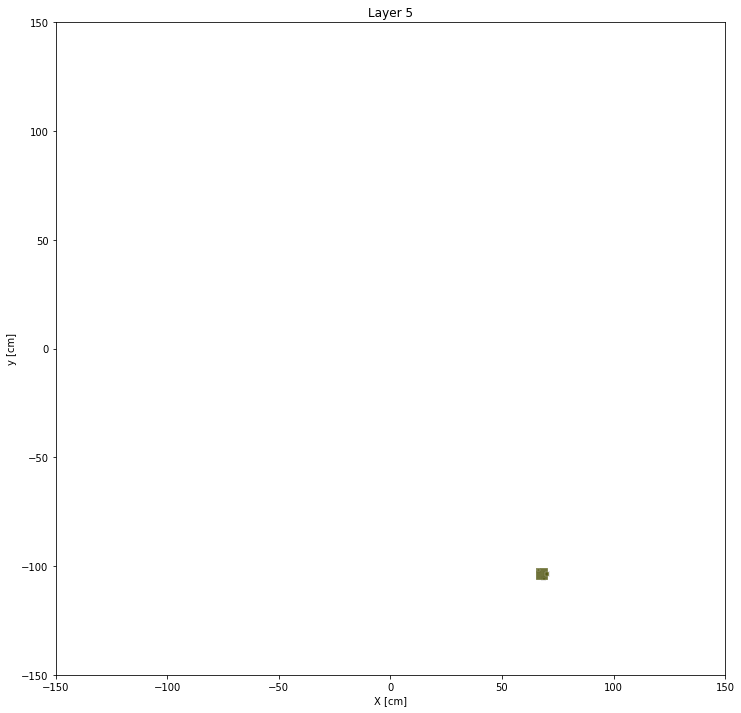

# layer 6, matched cells: 0


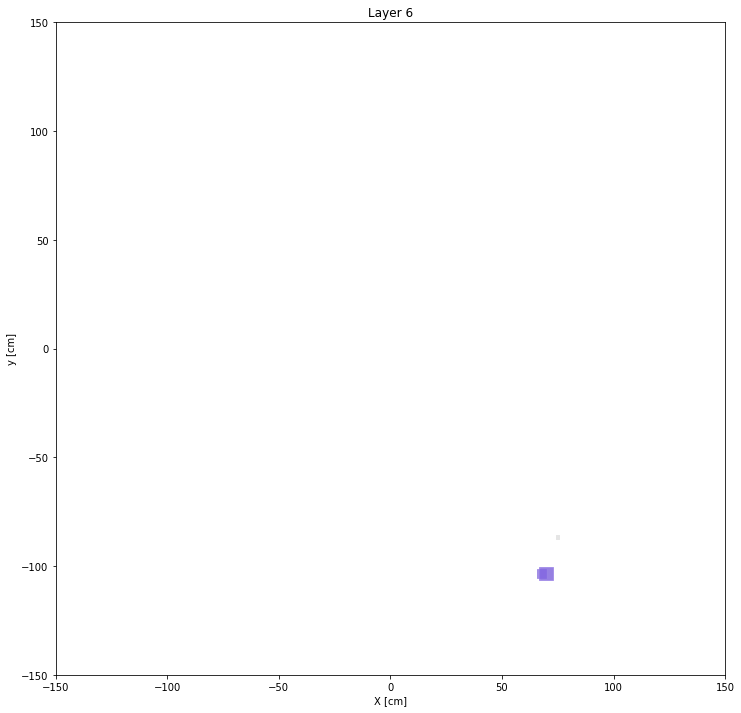

# layer 7, matched cells: 0


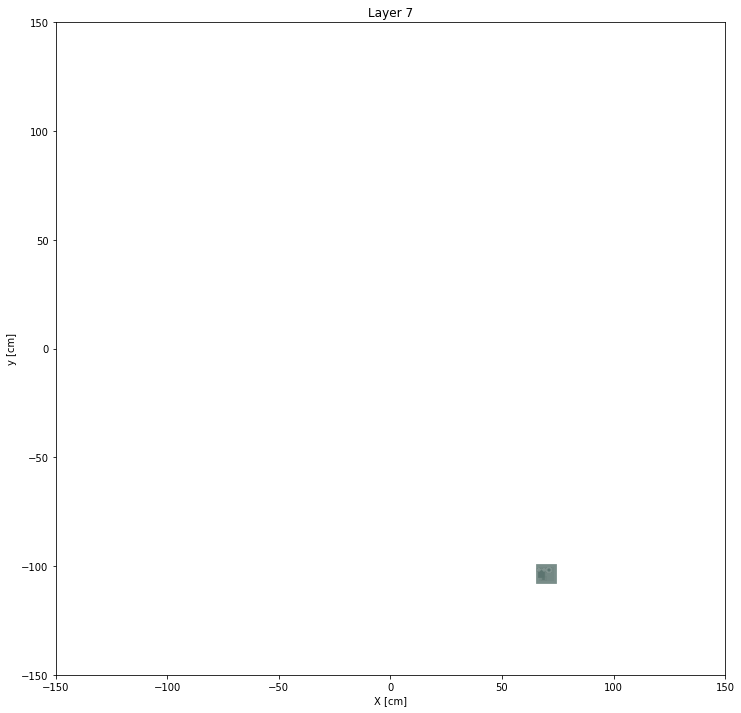

# layer 8, matched cells: 0


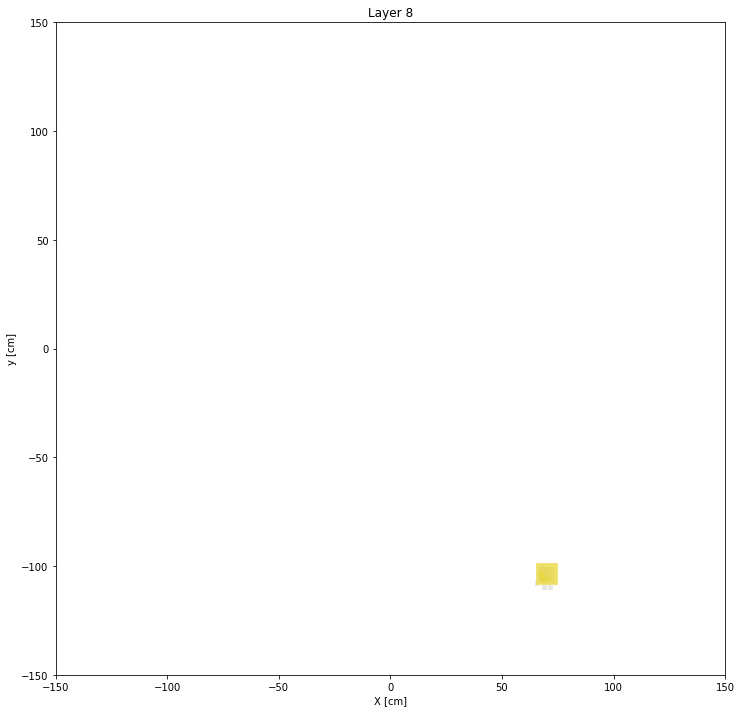

# layer 9, matched cells: 0


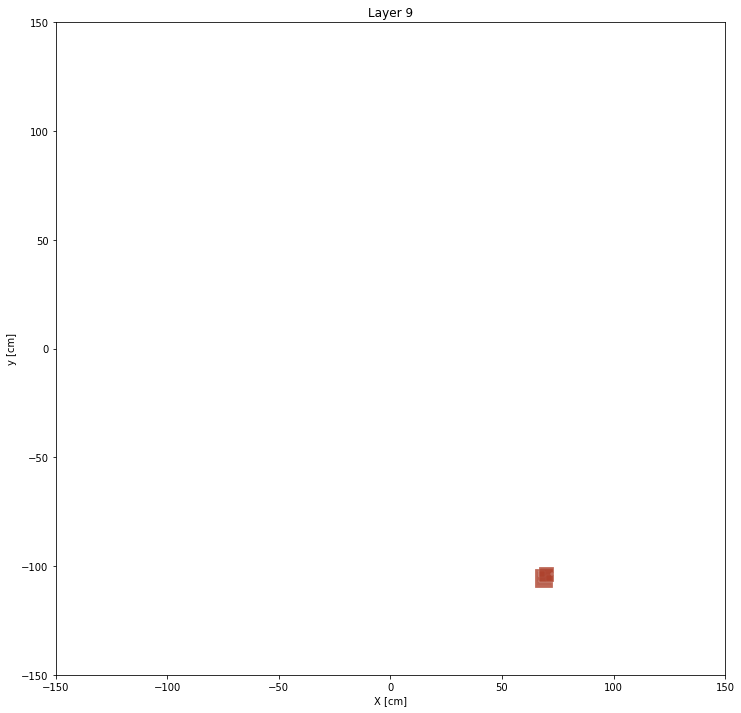

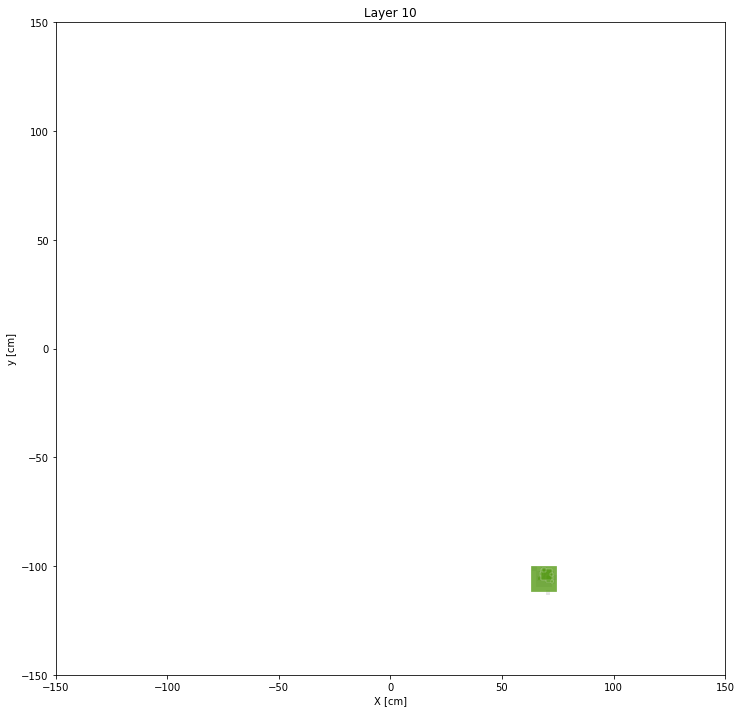

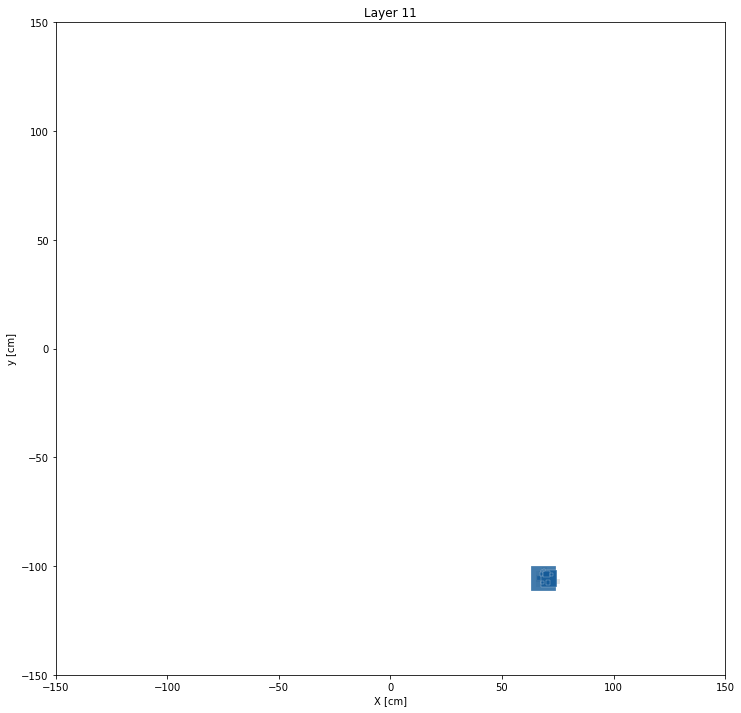

# layer 12, matched cells: 0


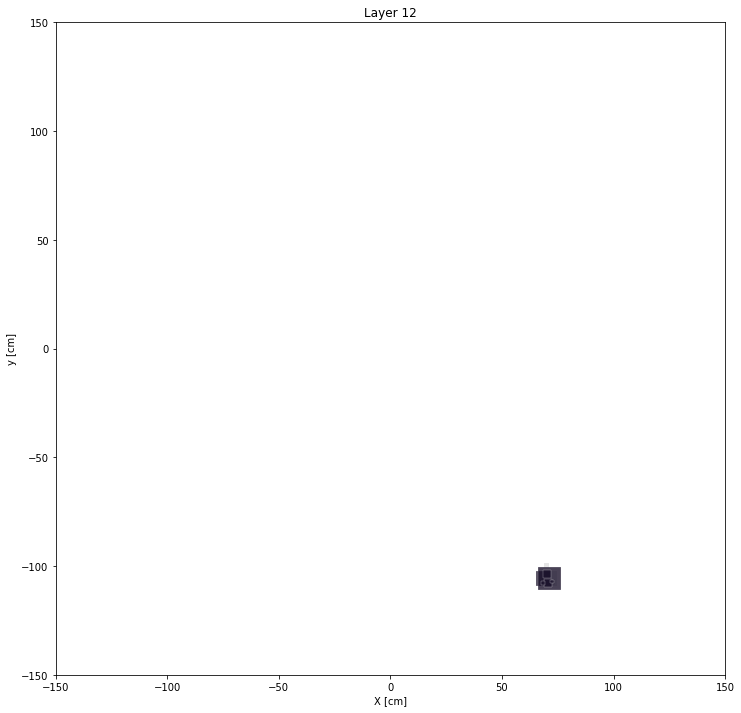

# layer 13, matched cells: 0


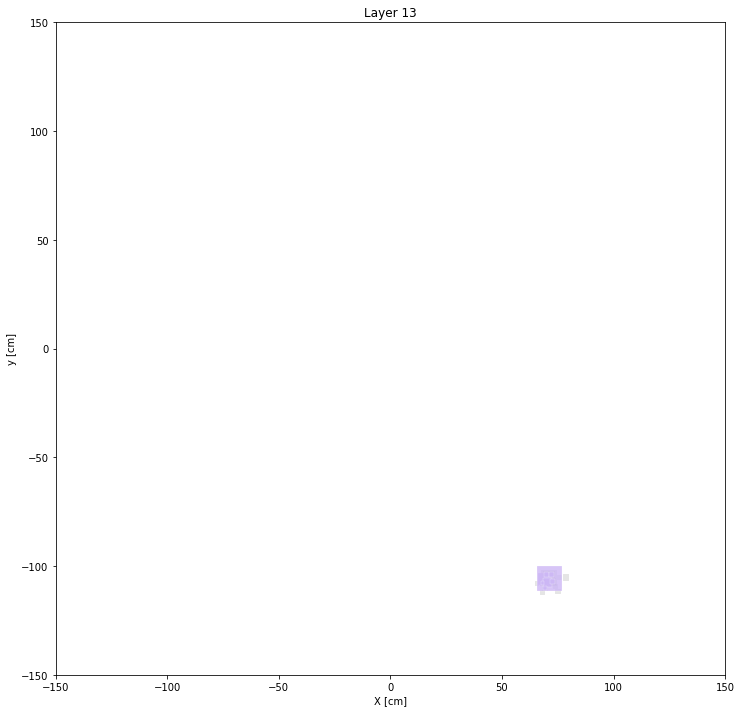

# layer 14, matched cells: 0


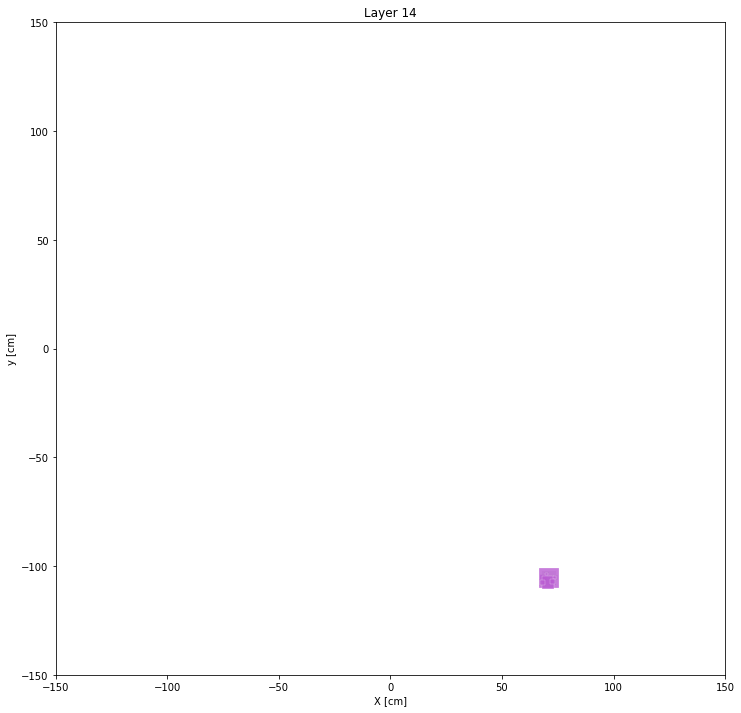

# layer 15, matched cells: 0


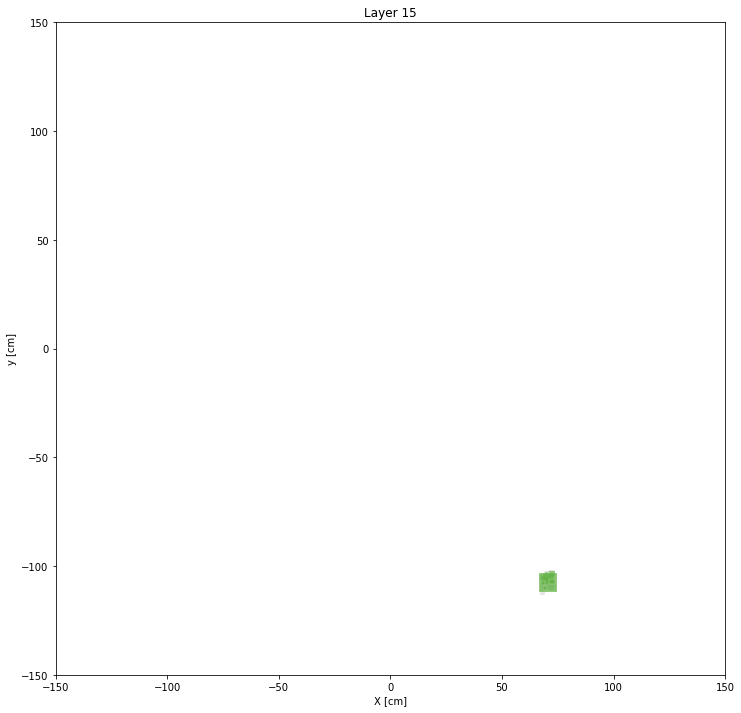

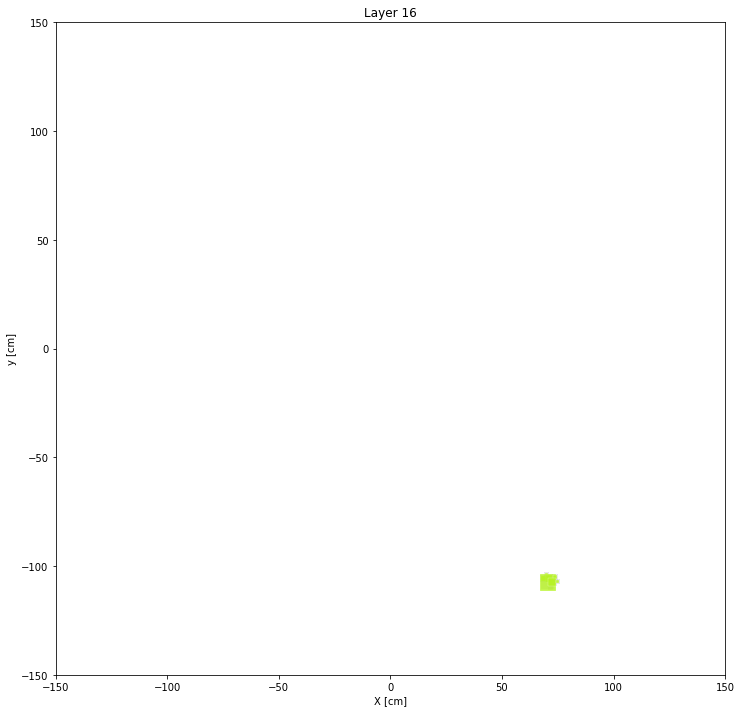

# layer 17, matched cells: 0


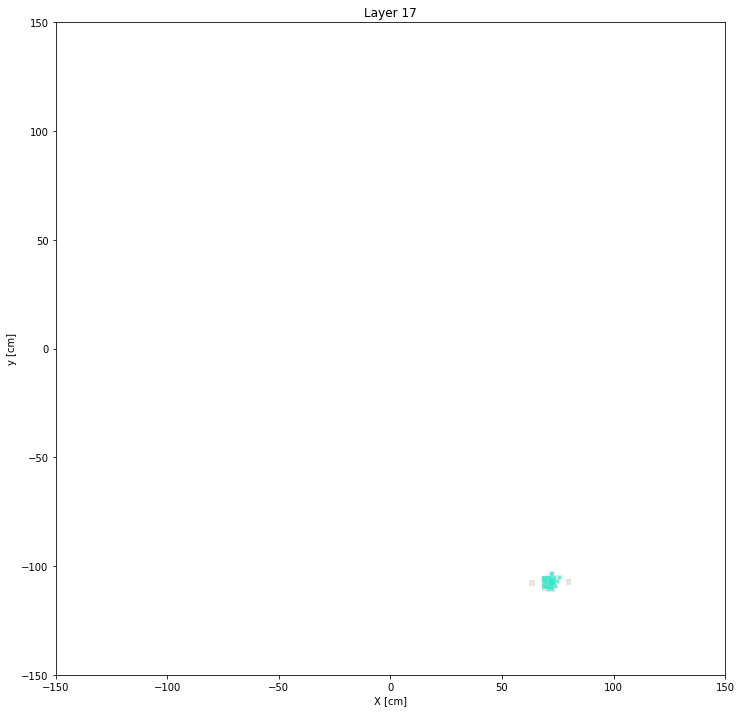

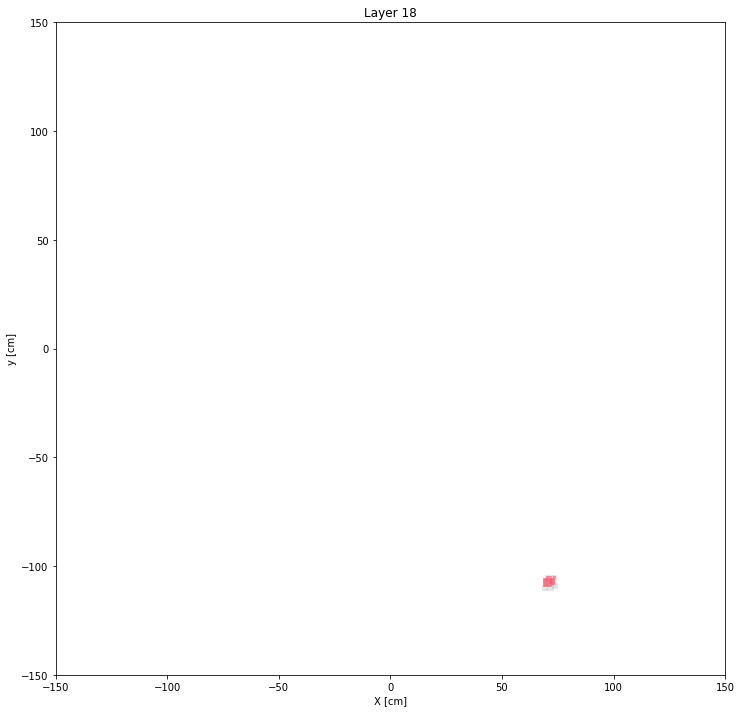

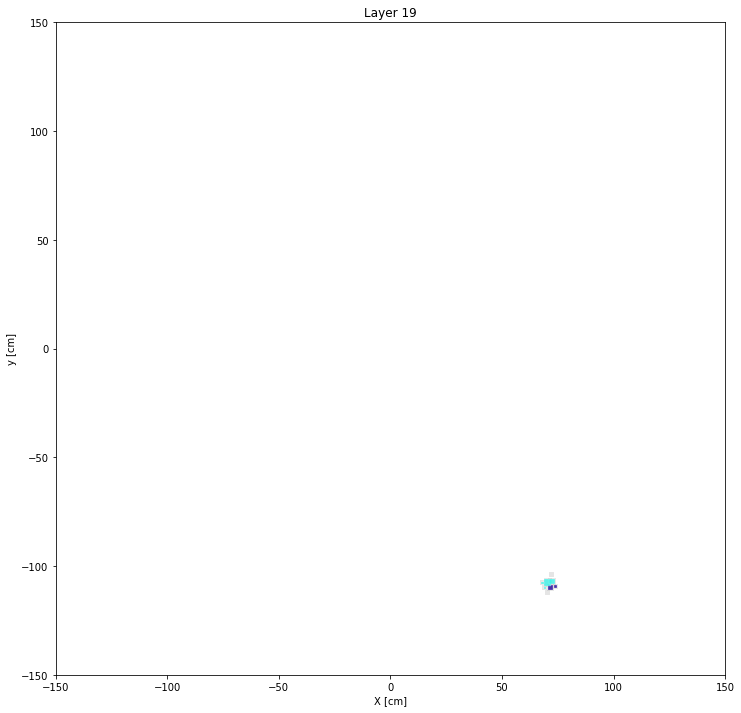

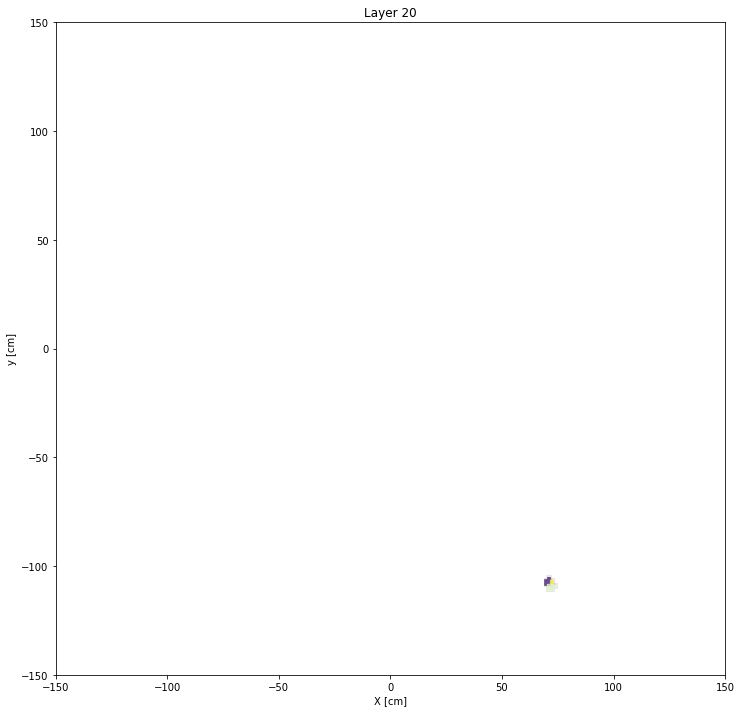

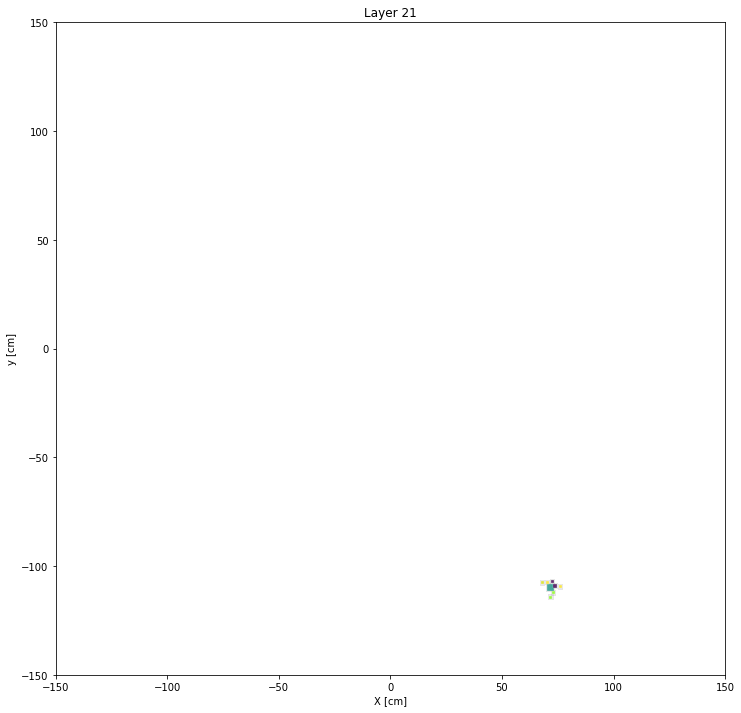

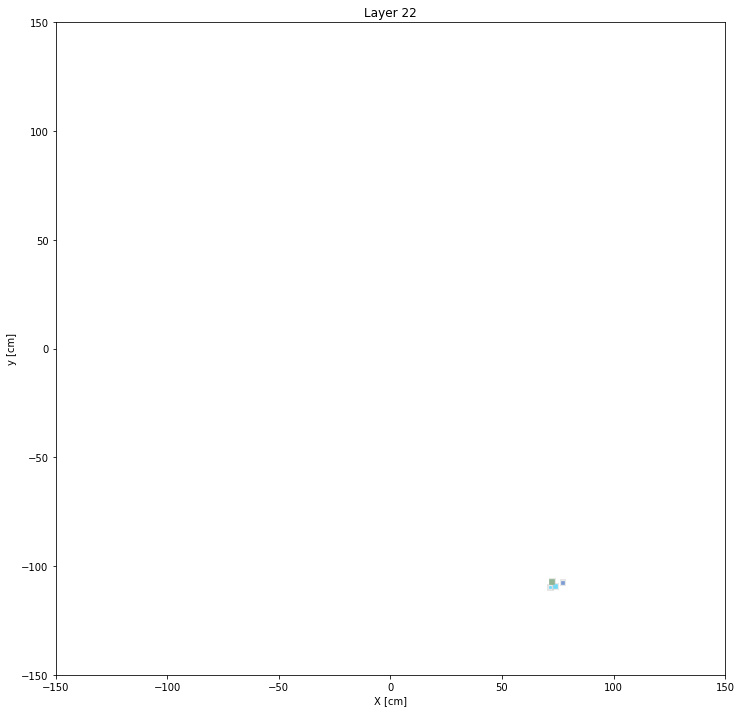

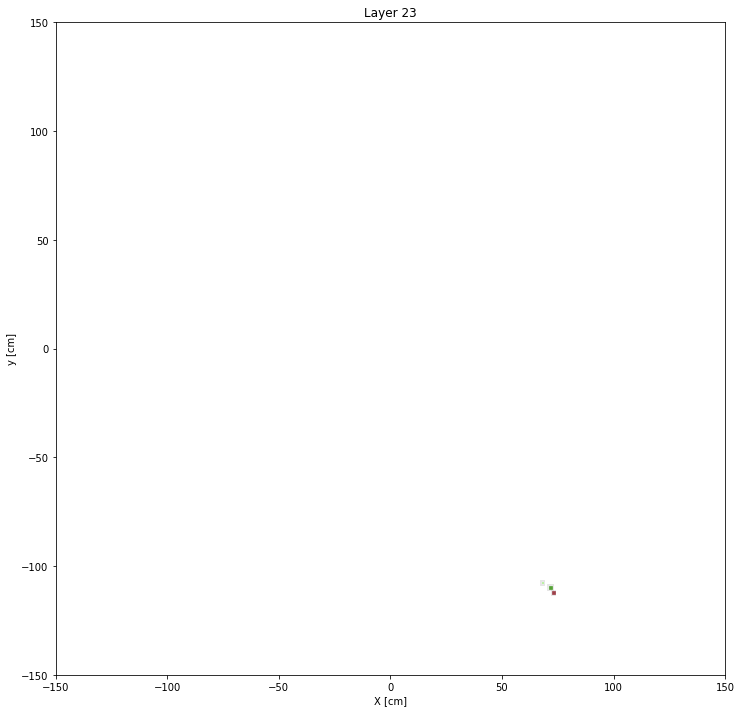

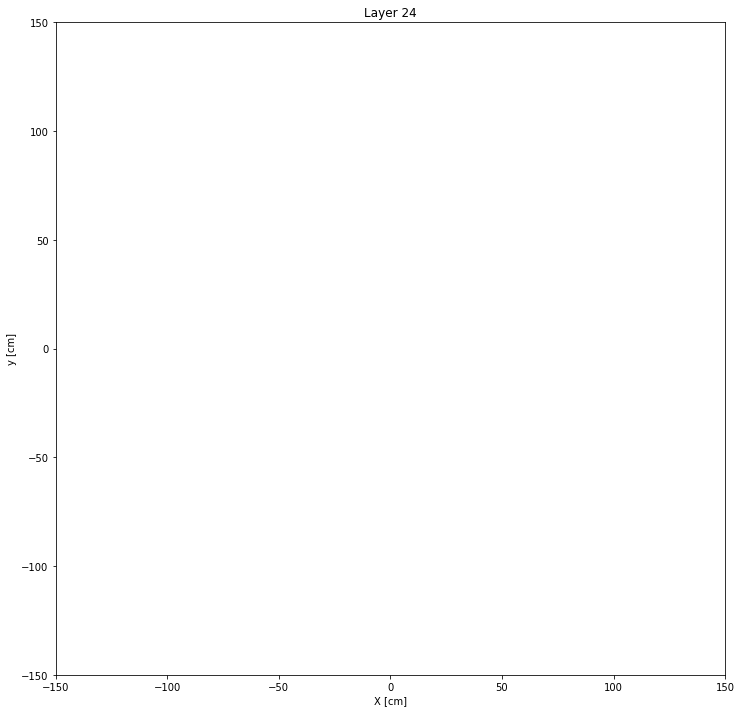

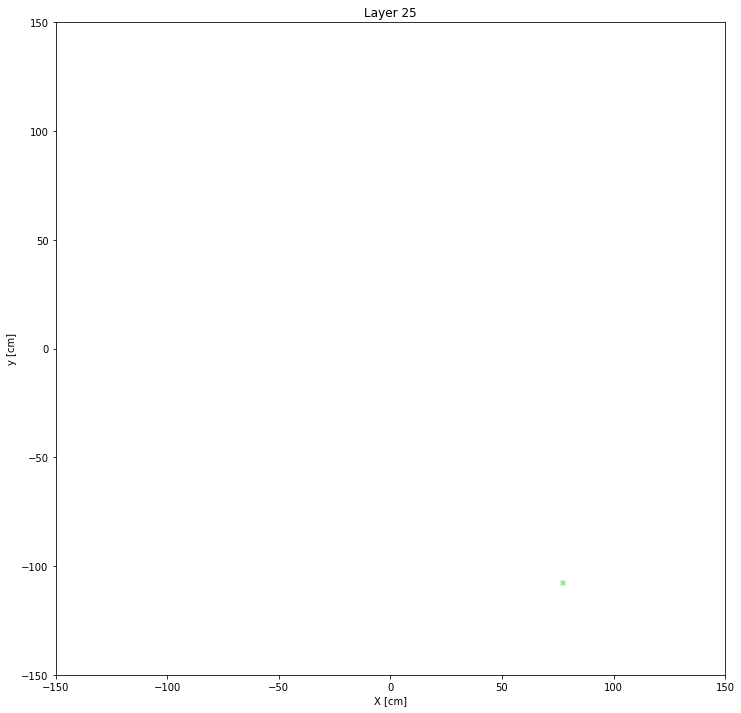

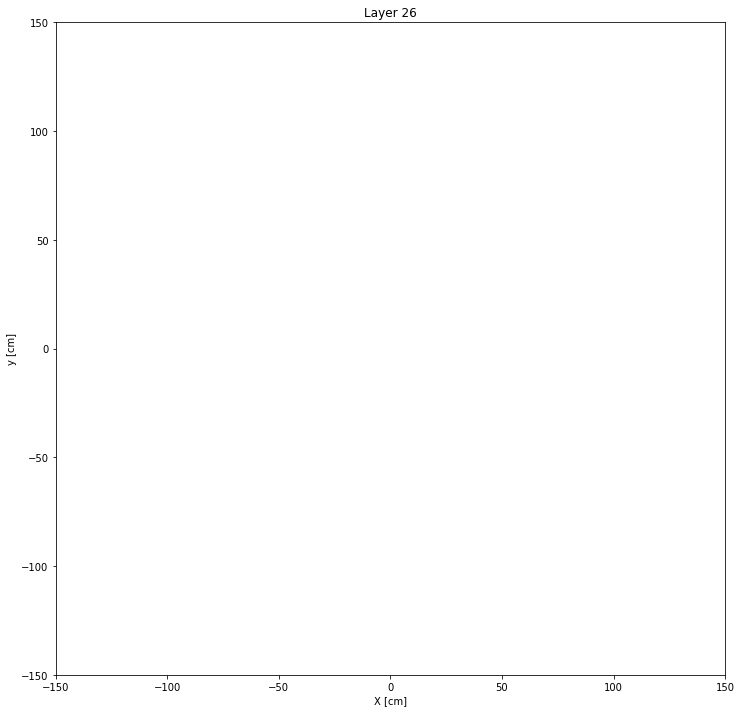

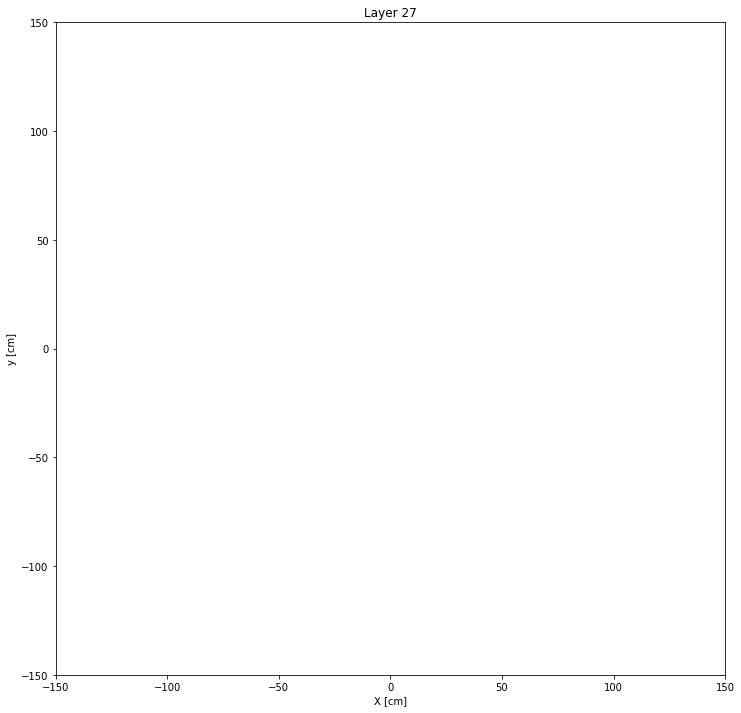

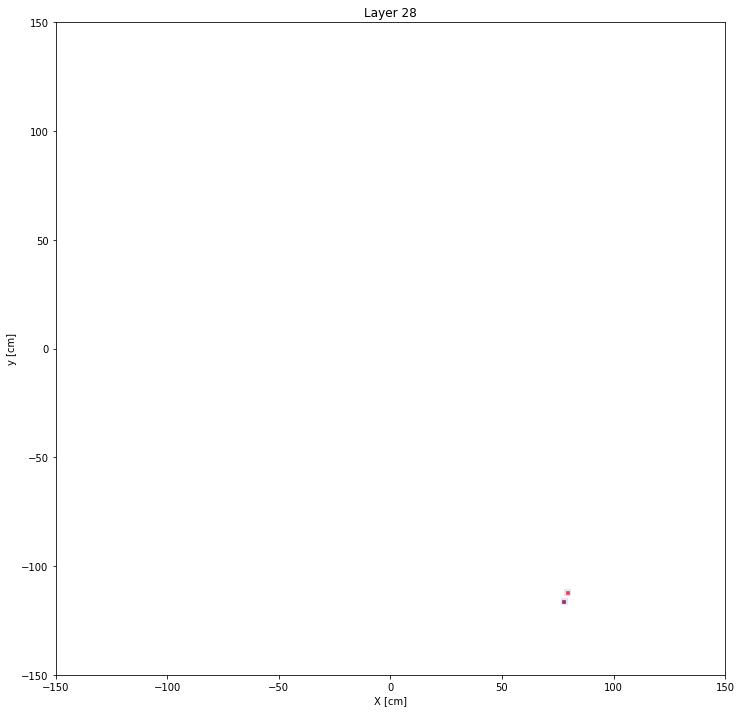

In [18]:
zside = 1
for layer in range(1, 29):
    plotLayer(layer, zside, tcs, new2Dcls, mcl2d)

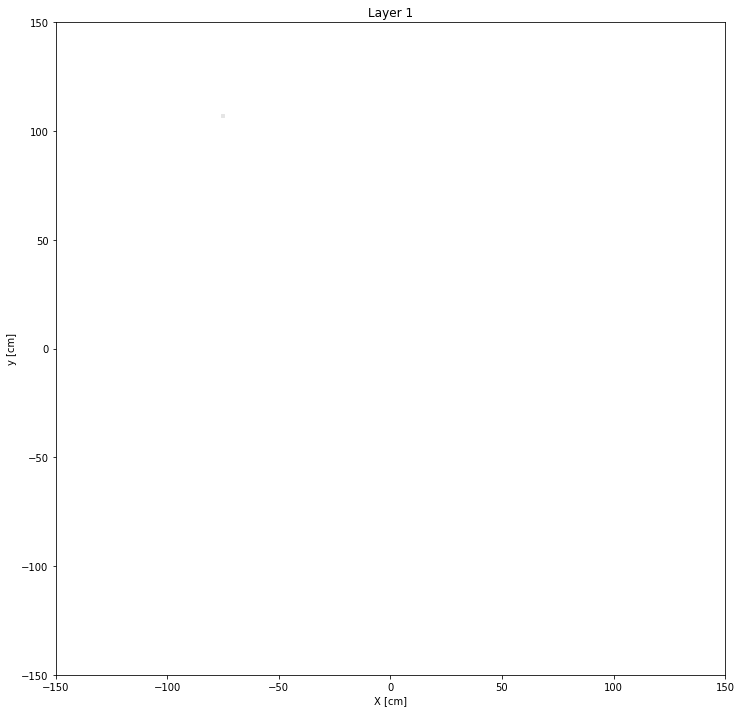

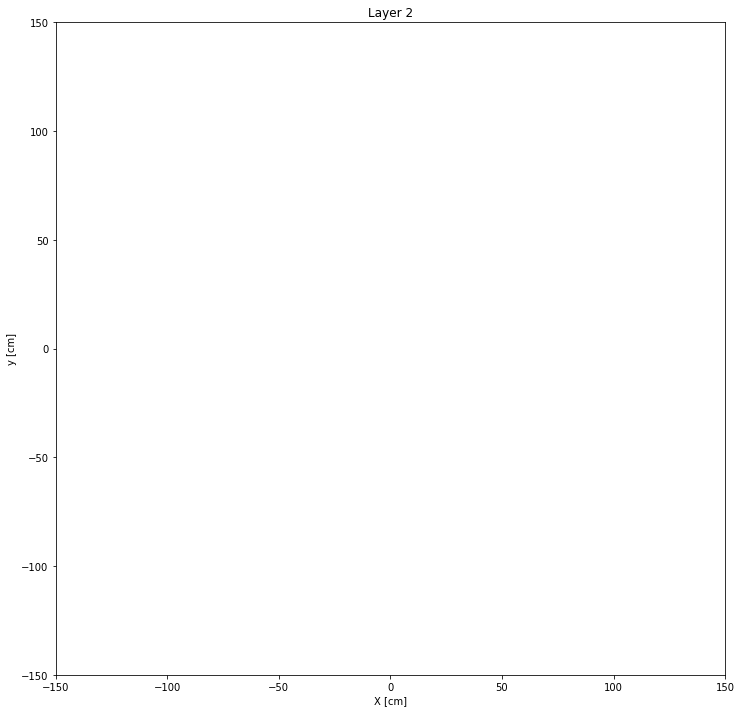

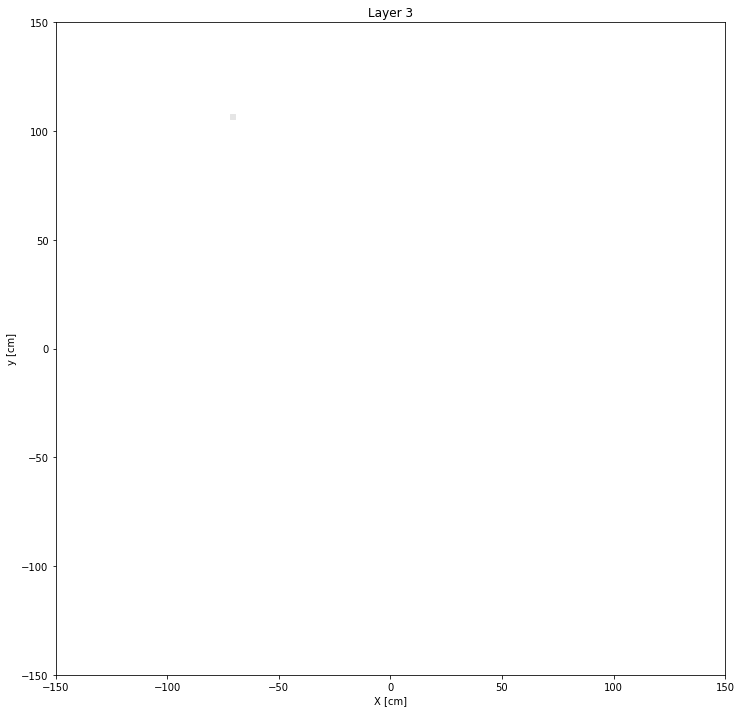

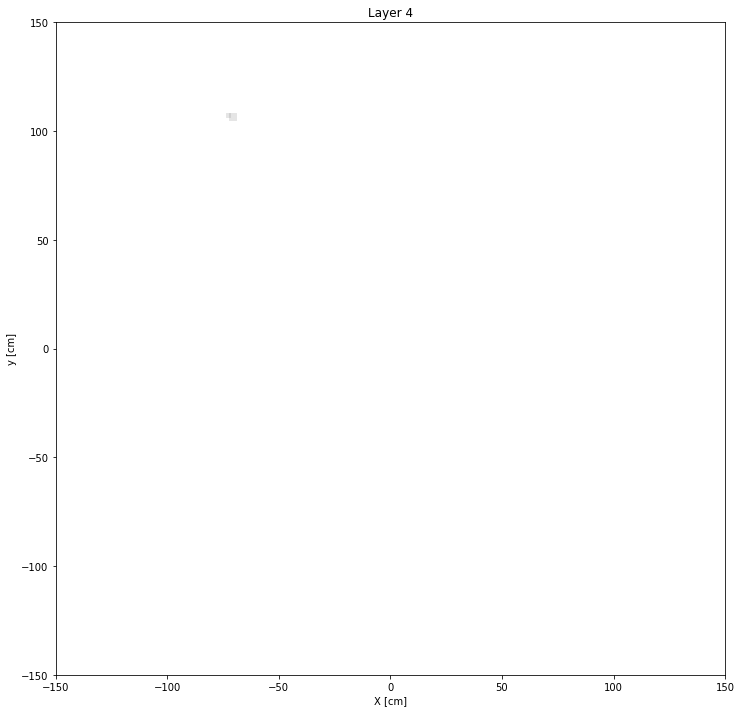

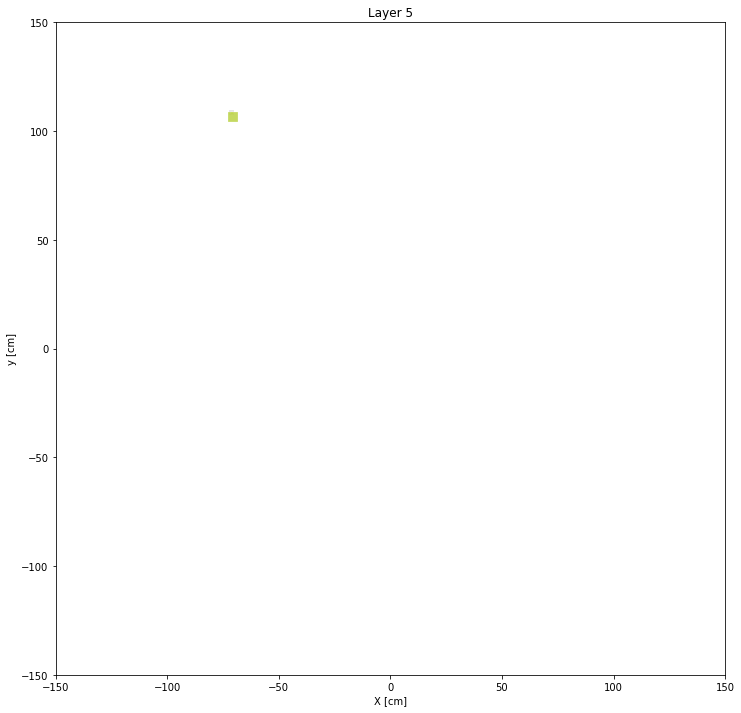

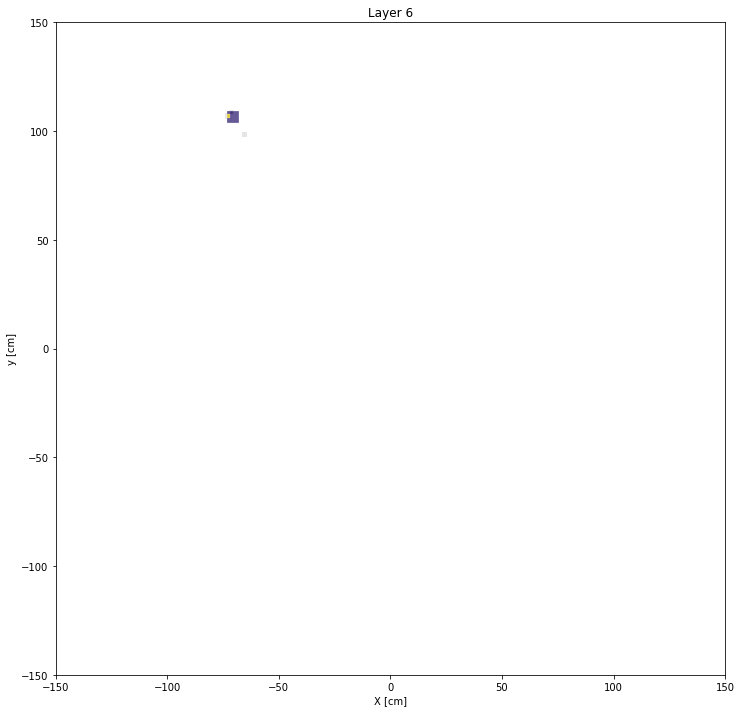

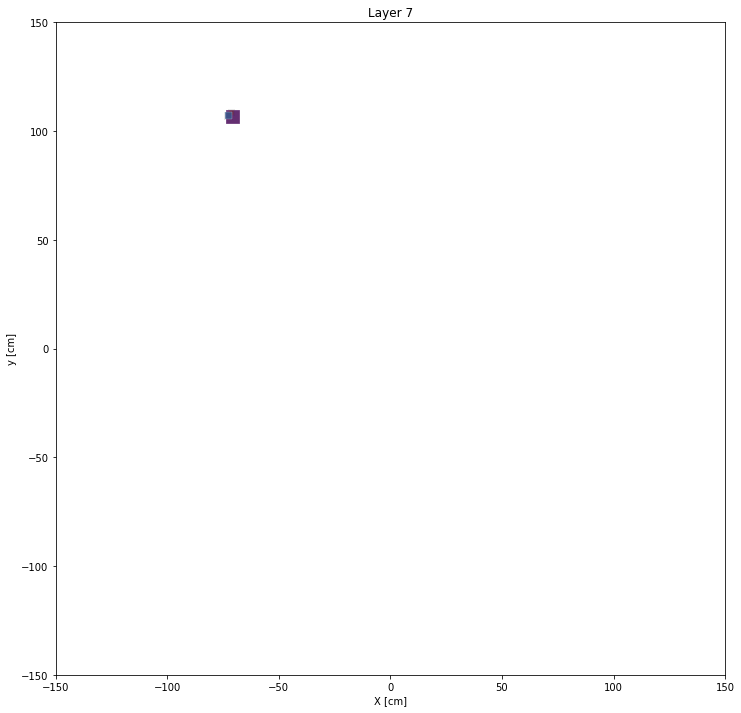

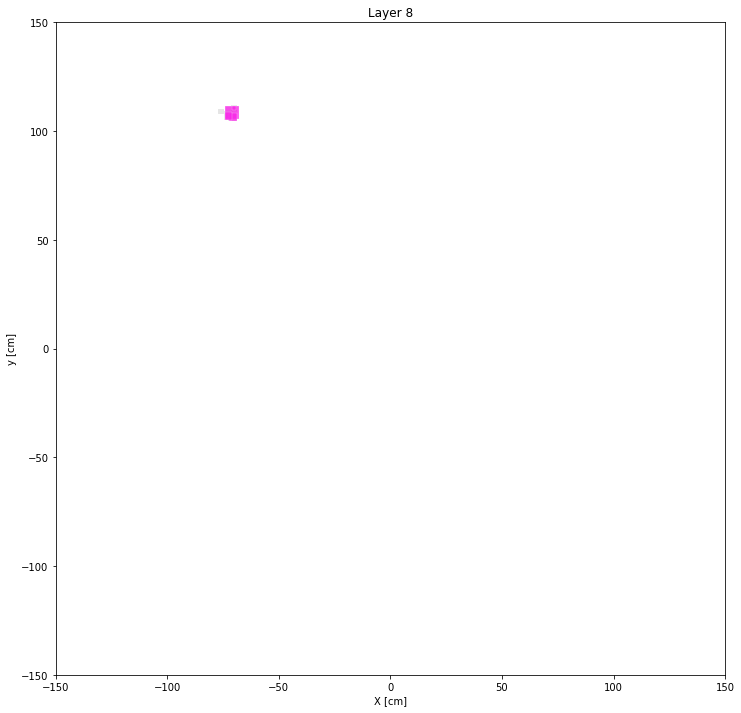

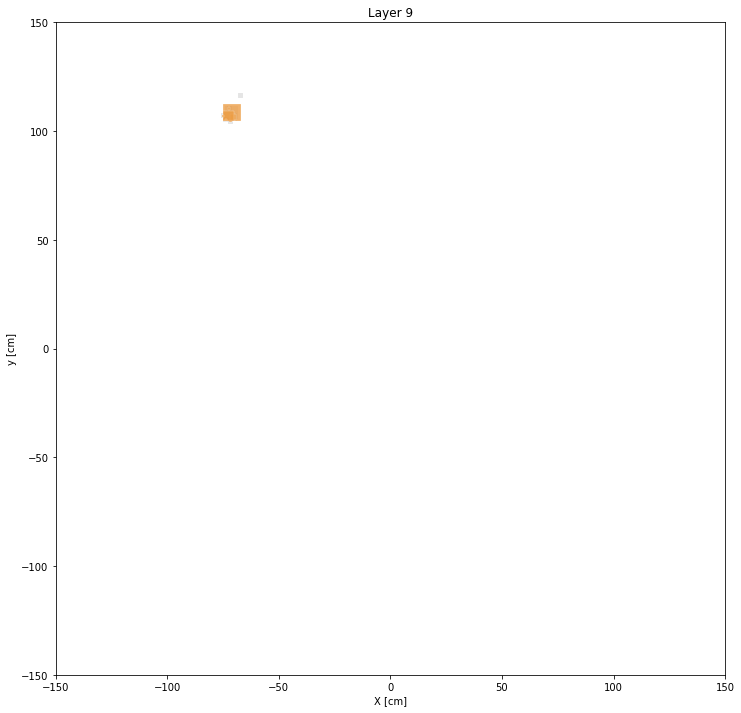

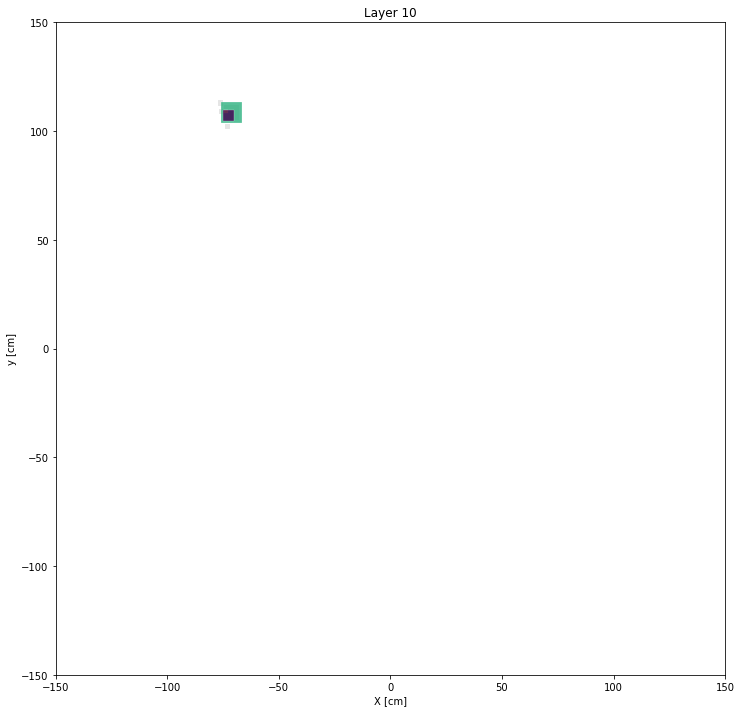

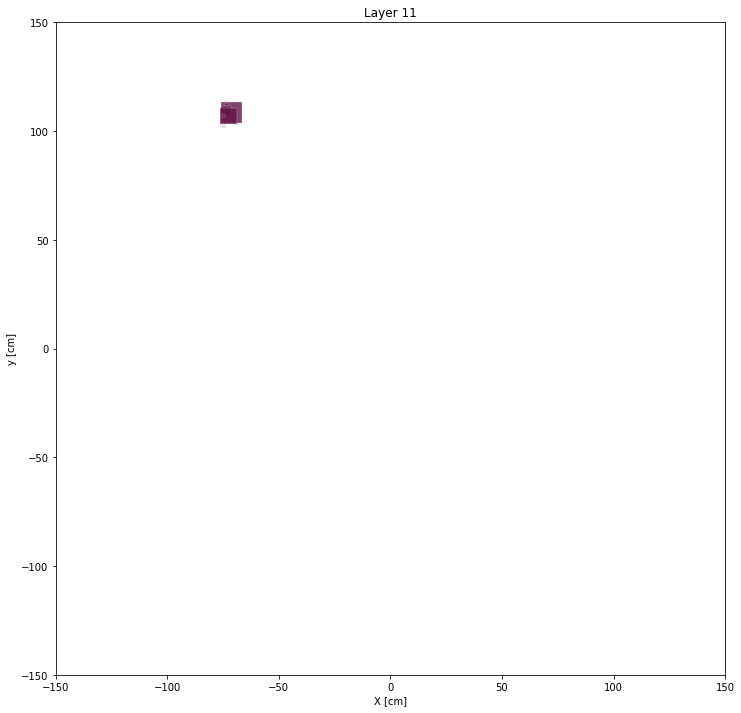

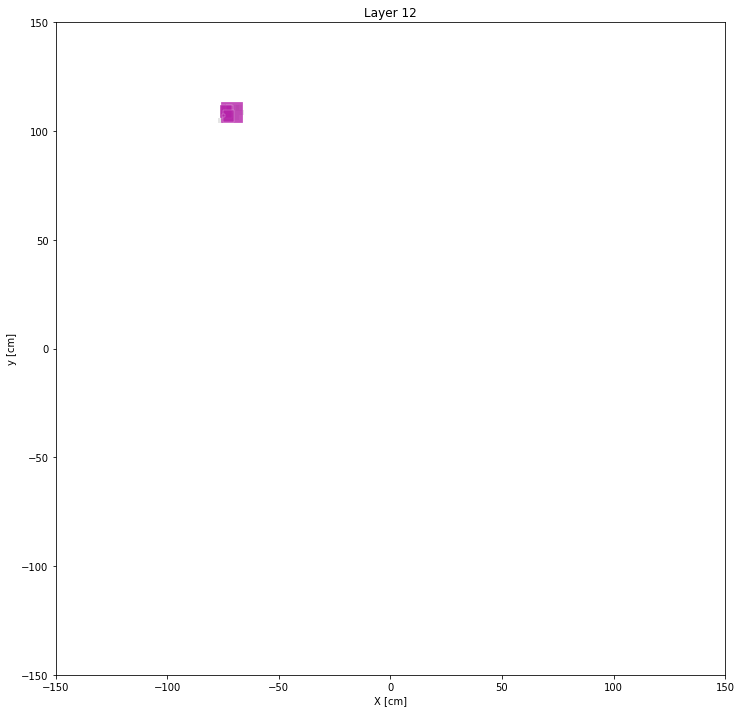

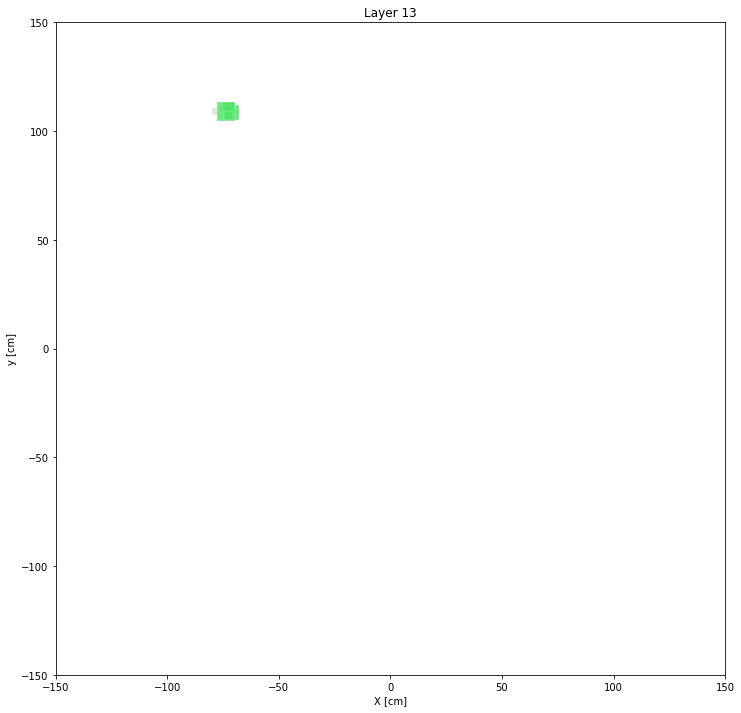

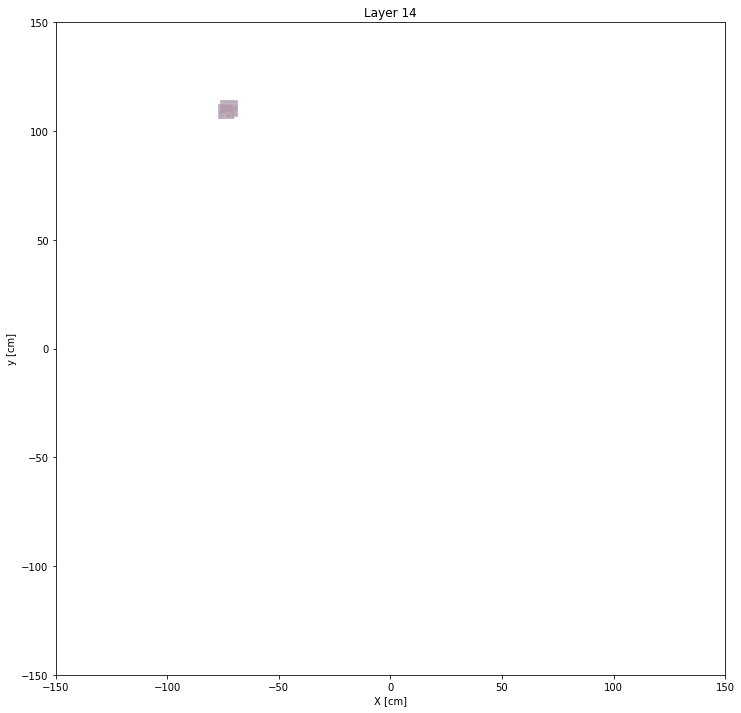

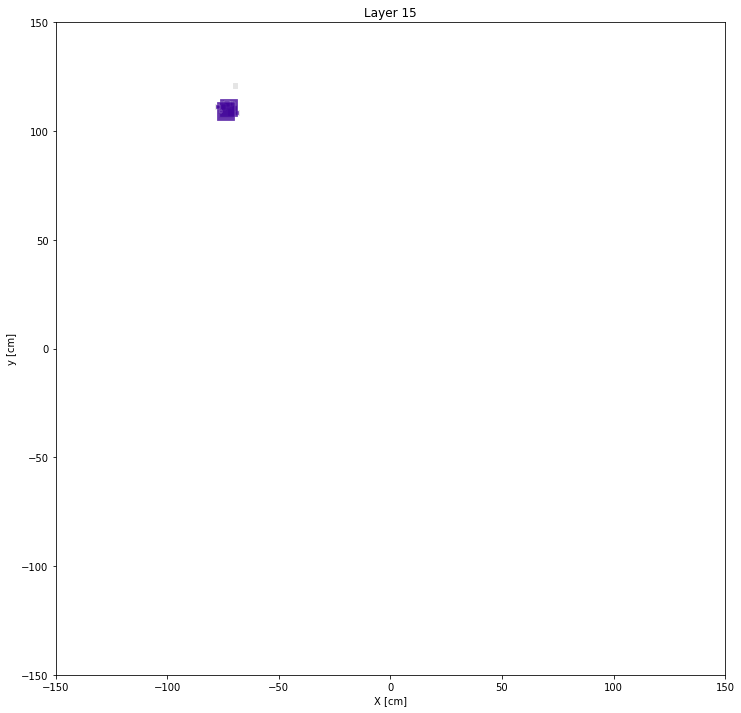

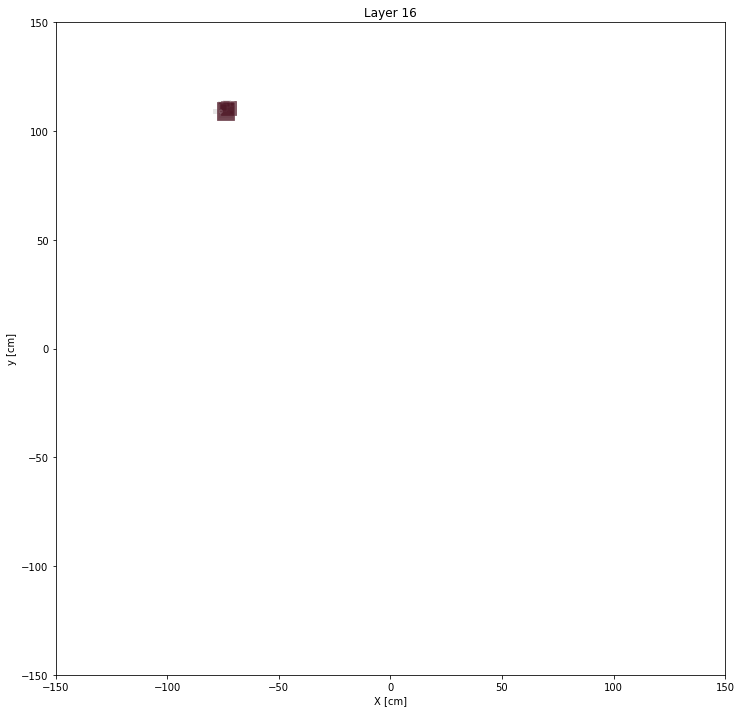

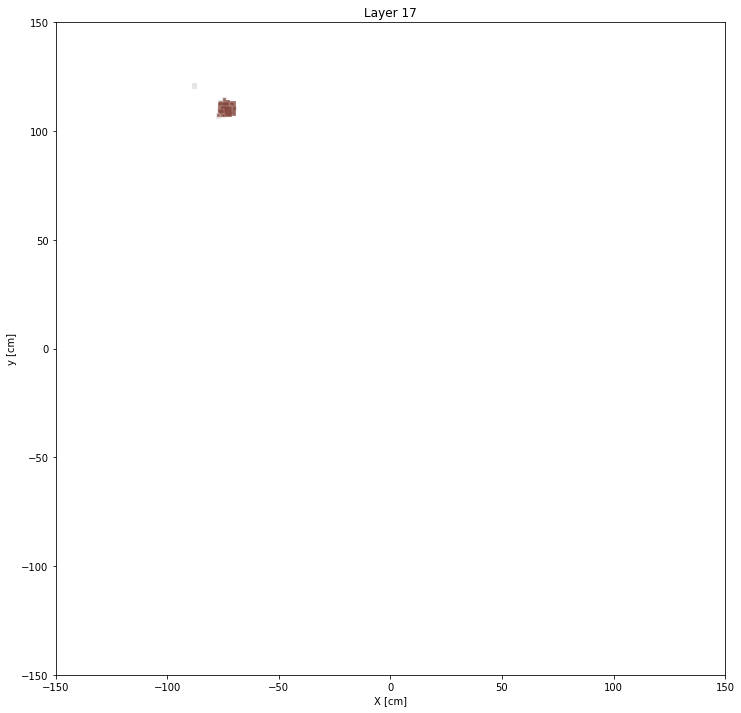

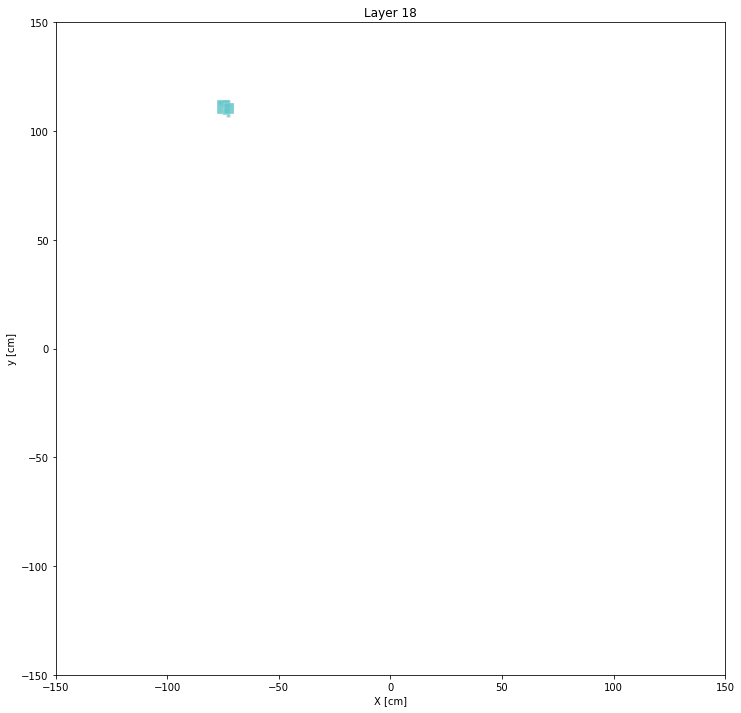

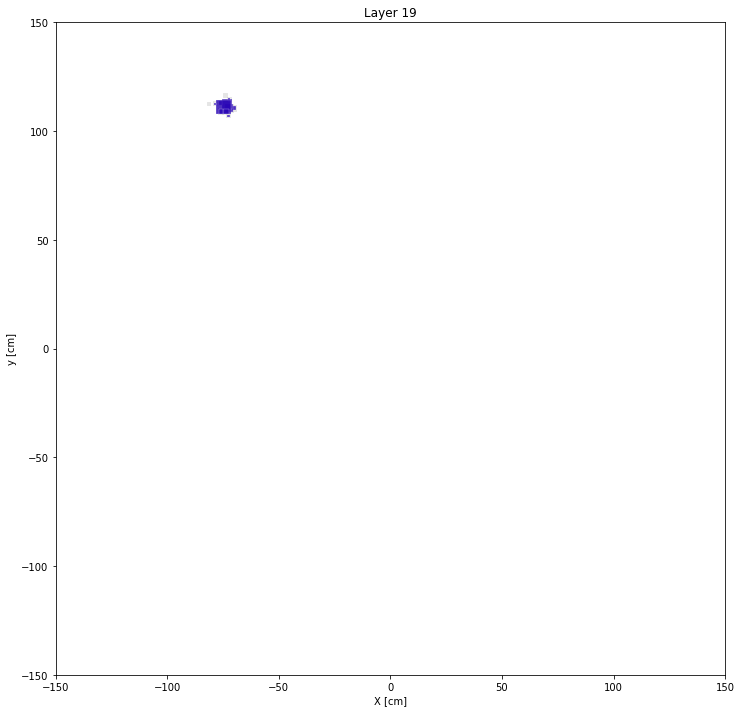

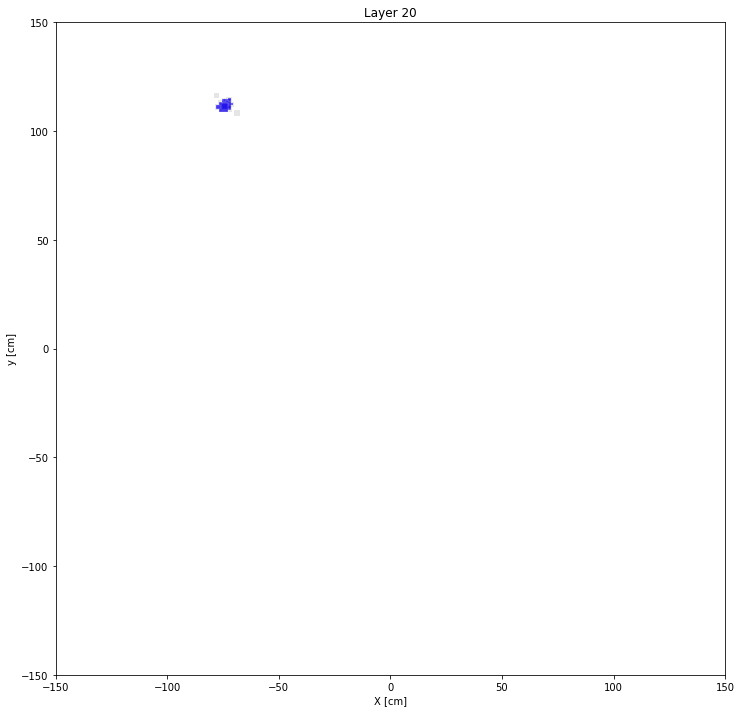

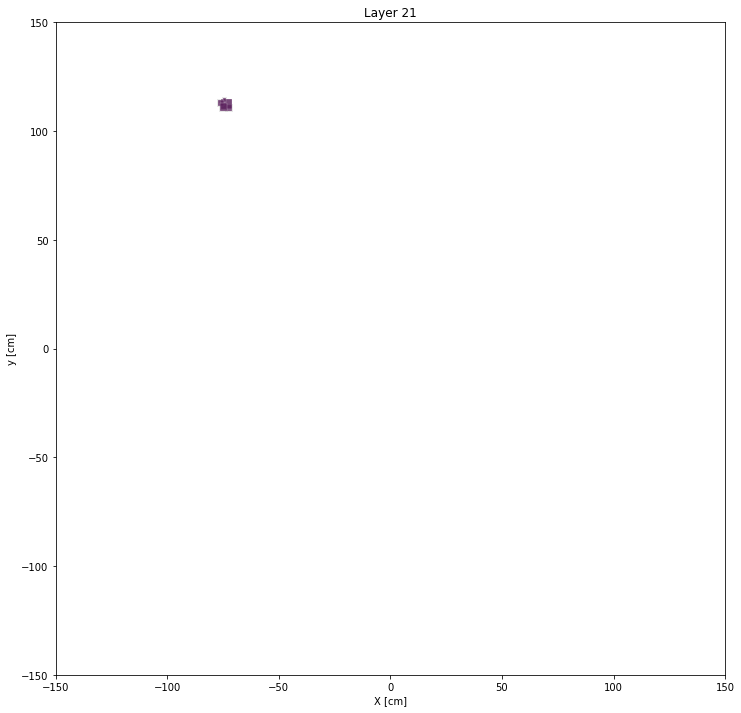

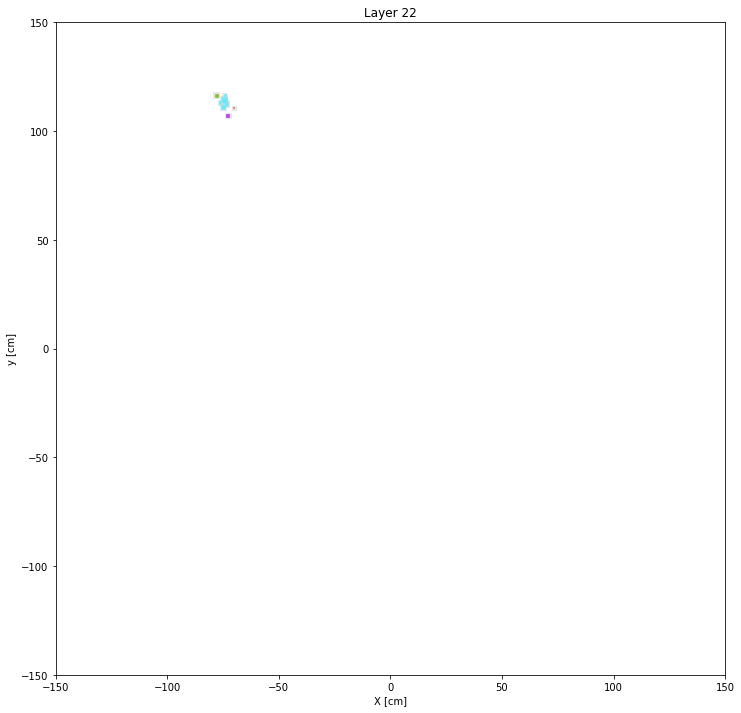

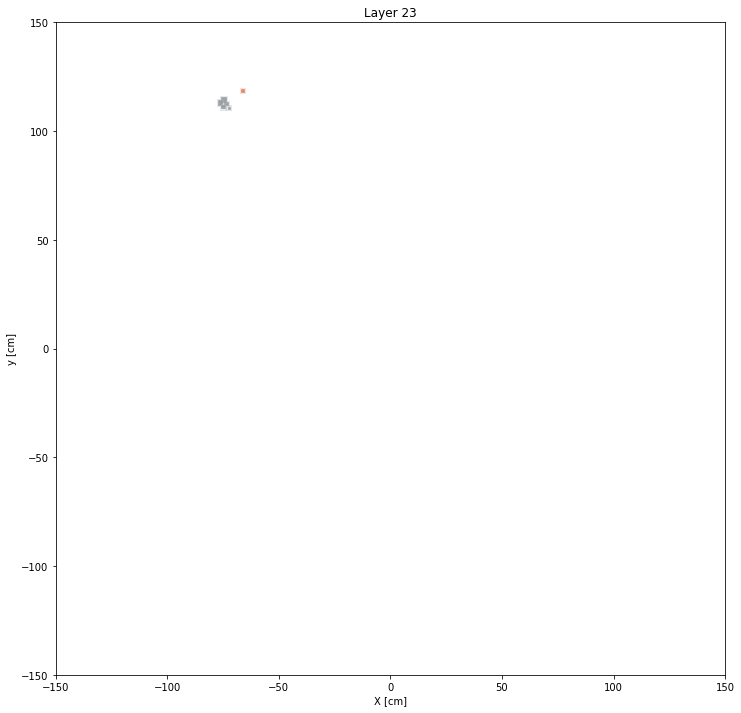

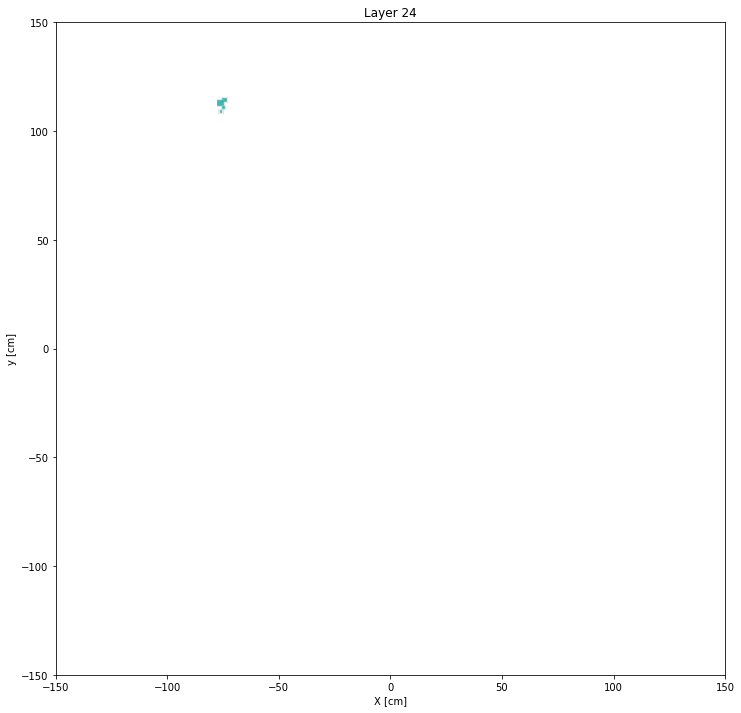

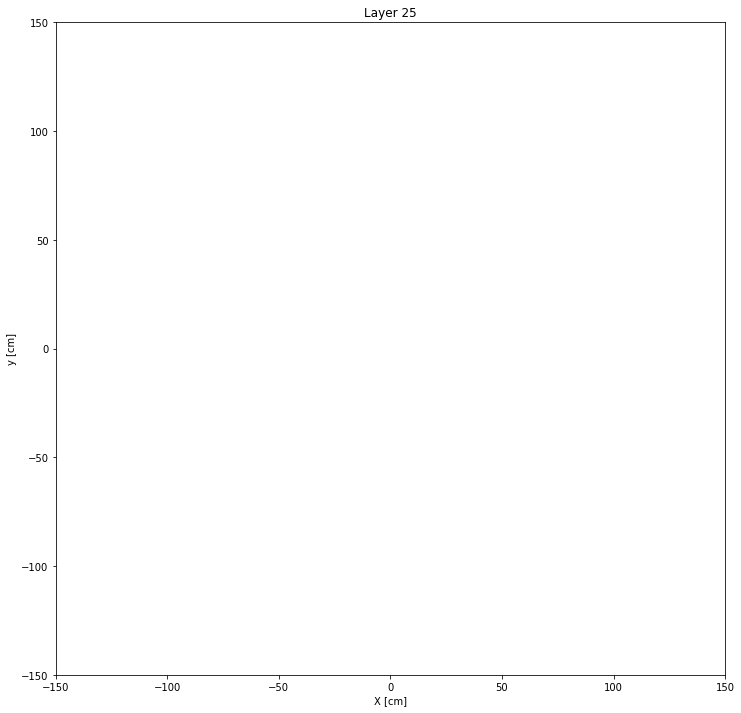

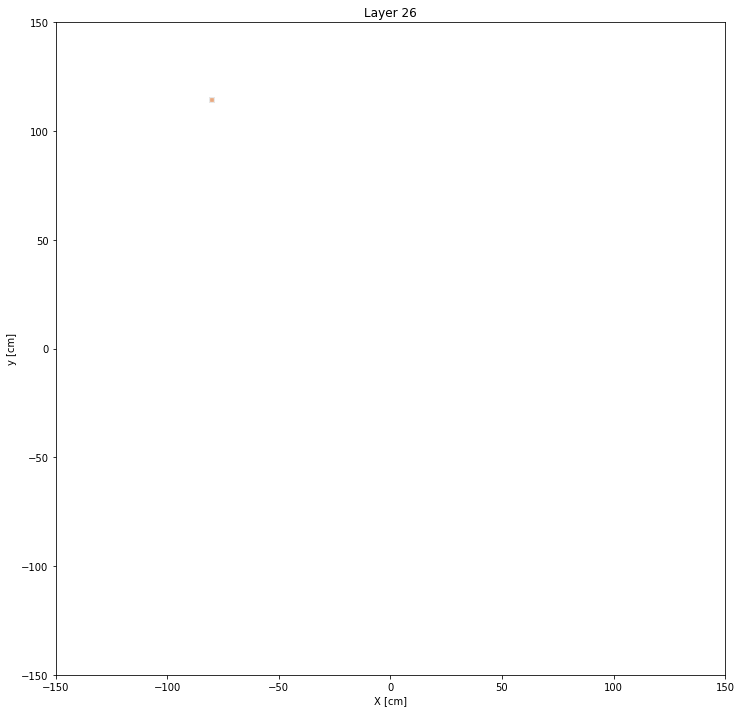

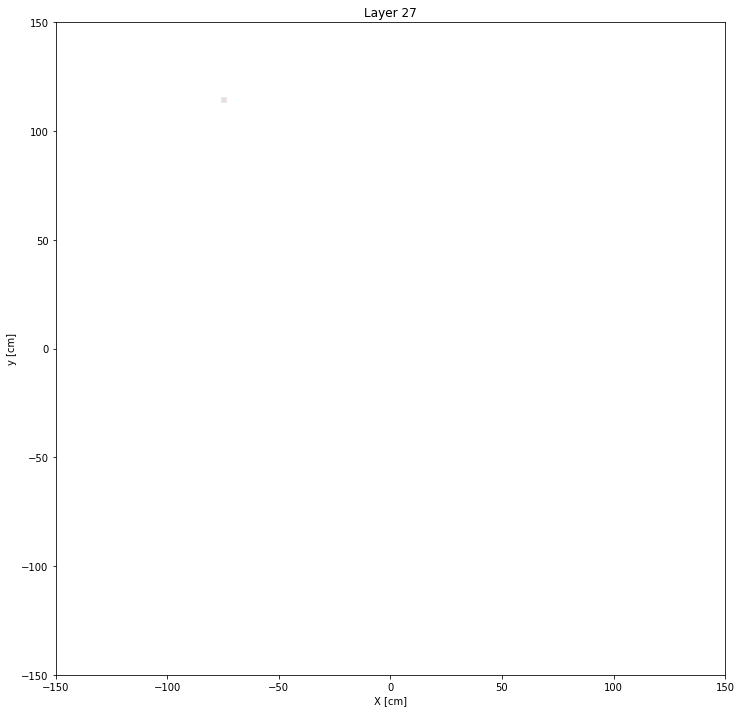

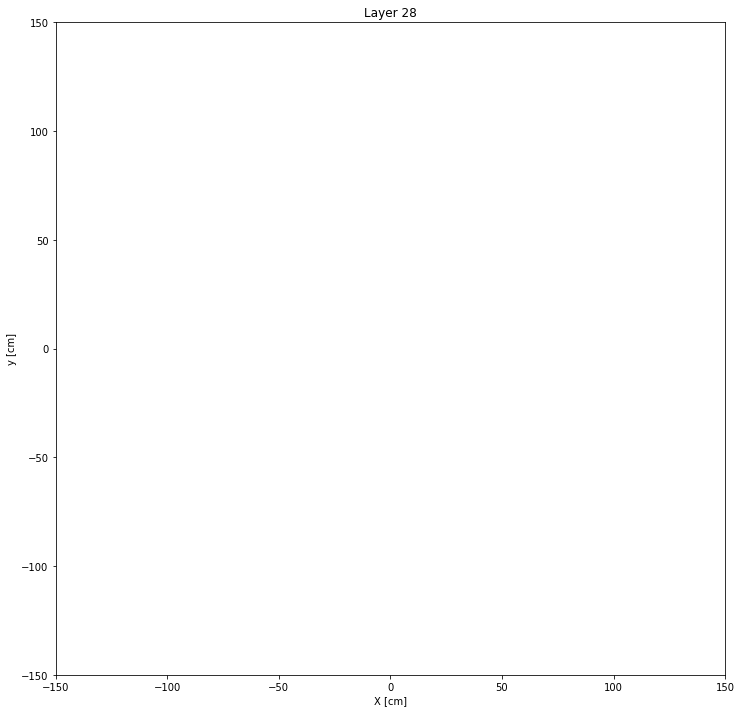

In [18]:
zside = -1

for layer in range(1, 29):
    plotLayer(layer, zside, tcs, new2Dcls, mcl2d)


In [38]:
def plotProj3DClusters(cl2d, cl3d):
    plt.figure(figsize=(12,12))
    plt.title('Projected 3D clusters')
    
    plt.scatter(cl2d['x'], cl2d['y'], label='all', marker="s", c="tab:gray",edgecolor="w",linewidth=0.3,
            s=100*cl2d['energy']**0.5,alpha = 0.2)
    for idx, cl in cl3d.iterrows():
        print '----------------'
        print cl
        print cl.clusters
        components = cl2d.loc[cl.clusters]
        print components
        plt.scatter(components['x'], components['y'], label='all', marker="s", c=cl.color,edgecolor="w",linewidth=0.3,
            s=100*components['energy']**0.5,alpha = 0.8)
     
    plt.xlabel("X [cm]")
    plt.ylabel("y [cm]")
        
    plt.xlim([-150,150])
    plt.ylim([-150,150])
    #plt.xlim([30,40])
    #plt.ylim([20,30])
    plt.show()
    

In [39]:
def plotProj3DClustersEtaPhi(cl2d, cl3d, xlim = None, ylim= None):
    plt.figure(figsize=(12,12))
    plt.title('Projected 3D clusters')
    
    plt.scatter(cl2d['eta'], cl2d['phi'], label='all', marker="s", c="tab:gray",edgecolor="w",linewidth=0.3,
            s=100*cl2d['energy']**0.5,alpha = 0.2)
    for idx, cl in cl3d.iterrows():
        print '----------------'
        print cl
        print cl.clusters
        components = cl2d.loc[cl.clusters]
        print components
        plt.scatter(components['eta'], components['phi'], label='all', marker="s", c=cl.color,edgecolor="w",linewidth=0.3,
            s=100*components['energy']**0.5,alpha = 0.8)
        plt.annotate(cl.pt, (cl['eta'], cl['phi']))
    plt.xlabel("Eta")
    plt.ylabel("Phi")
    if(xlim):
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)  
    plt.show()

In [40]:
print type(np.random.rand(2, 3))
print len(np.random.rand(2, 3))

<type 'numpy.ndarray'>
2


## DBSCAN 3D clusters


<IPython.core.display.Javascript object>


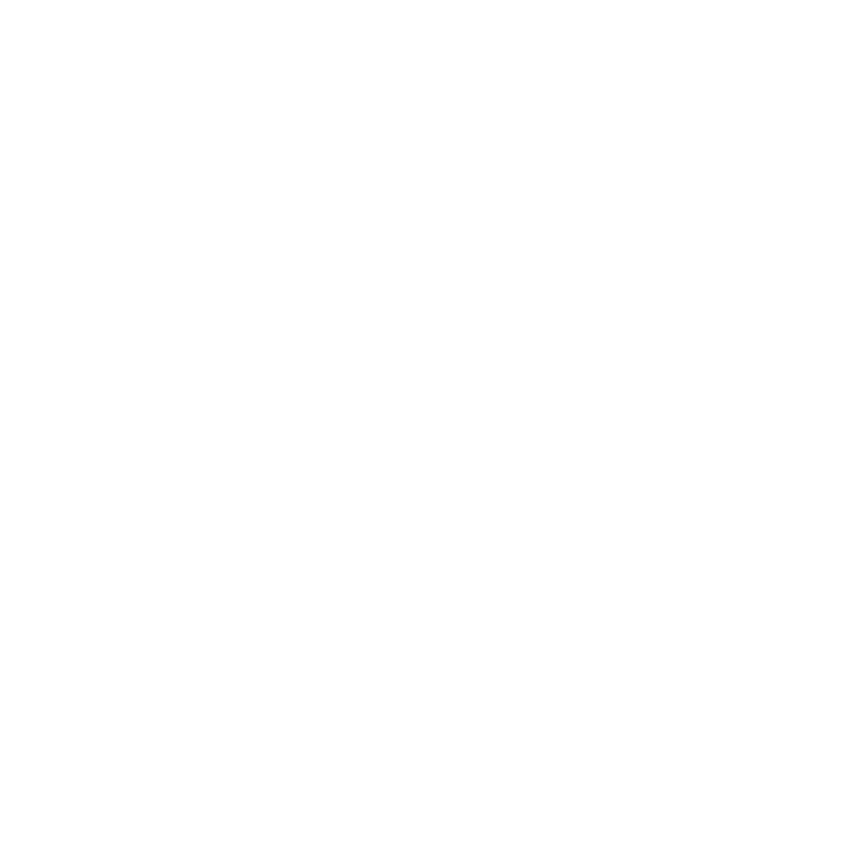

----------------
energy                                                     95.1039
eta                                                        1.68908
phi                                                      -0.984969
energyCore                                                 92.8593
energyCentral                                              68.2042
pt                                                         33.9707
ptCore                                                      33.169
layers           [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....
clusters         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
nclu                                                            25
firstlayer                                                       4
showerlength                                                     1
seetot                                                           1
seemax                                                           1
spptot                                       

<IPython.core.display.Javascript object>


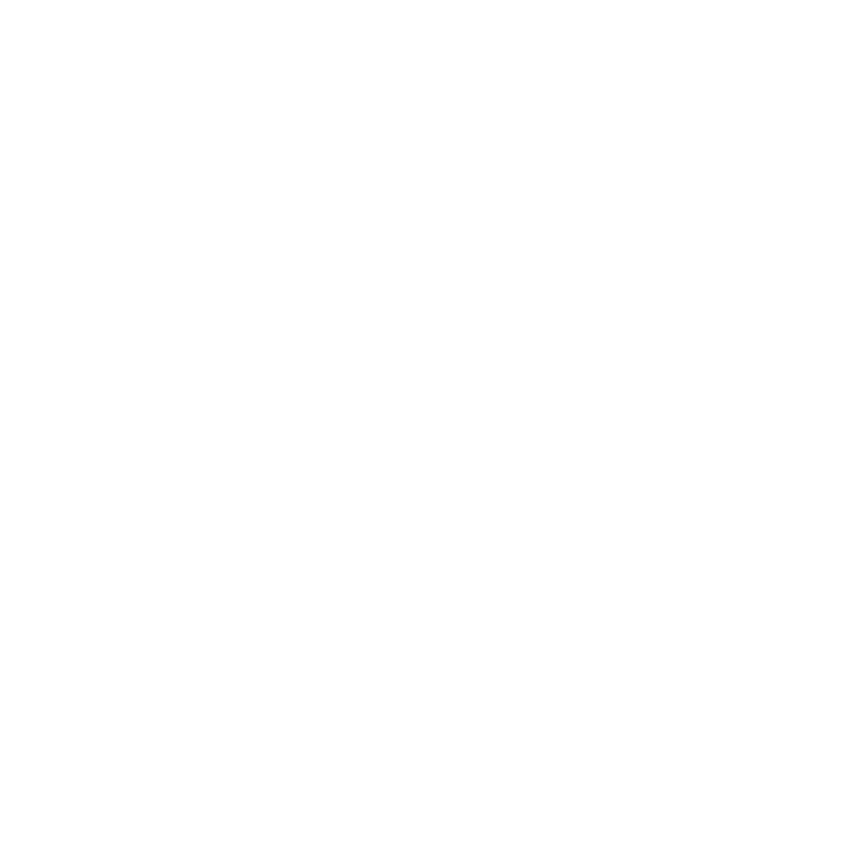

In [41]:
plotProj3DClusters(new2Dcls, cl3D)

----------------
energy                                                     95.1039
eta                                                        1.68908
phi                                                      -0.984969
energyCore                                                 92.8593
energyCentral                                              68.2042
pt                                                         33.9707
ptCore                                                      33.169
layers           [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....
clusters         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
nclu                                                            25
firstlayer                                                       4
showerlength                                                     1
seetot                                                           1
seemax                                                           1
spptot                                       

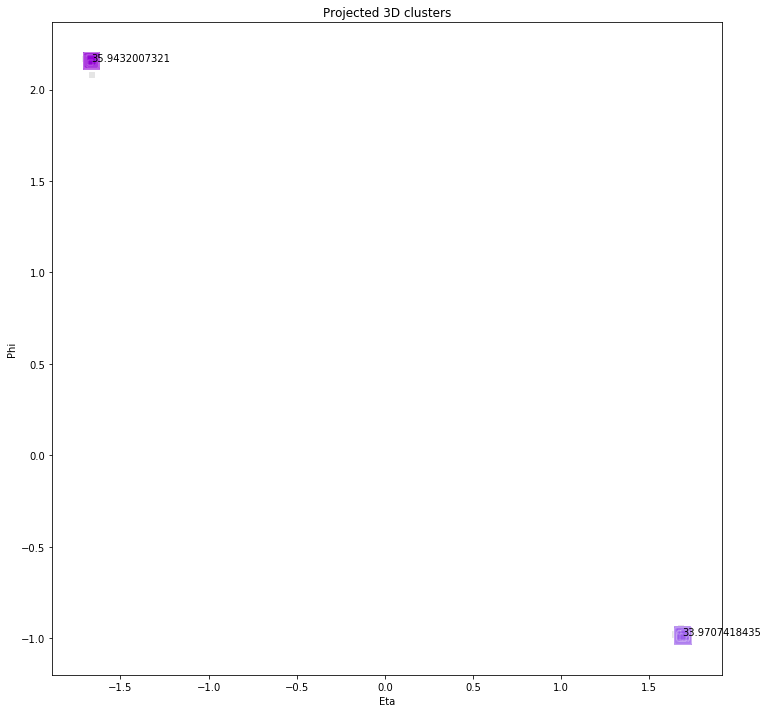

In [23]:
plotProj3DClustersEtaPhi(new2Dcls, cl3D)

In [24]:
my_mcl3D = pd.DataFrame(columns=['energy'])
my_mcl3D = my_mcl3D.append(clAlgo.build3DClustersProj(mcl2d))
print  my_mcl3D
print my_mcl3D.shape
print len(my_mcl3D)
print my_mcl3D.size

print len(mcl2d)

colorlista = [np.random.rand(3,) for range in (0, my_mcl3D.shape[0])]
print colorlista
my_mcl3D['color'] = colorlista

print my_mcl3D.sort(columns='energy', ascending=False)
print len(my_mcl3D.clusters.iloc[0])

AttributeError: 'DataFrame' object has no attribute 'x'

In [ ]:
plotProj3DClustersEtaPhi(mcl2d, my_mcl3D)

In [ ]:
my_cl3D = pd.DataFrame(columns=['energy'])
my_cl3D = my_cl3D.append(clAlgo.build3DClusters(cl2d))

colorlist = [np.random.rand(3,) for range in (0, my_cl3D.shape[0])]
my_cl3D['color'] = colorlist

print len(cl2d)
print my_cl3D.sort(columns='energy', ascending=False)
print len(my_cl3D.clusters.iloc[0])

In [ ]:
plotProj3DClustersEtaPhi(cl2d, my_cl3D, xlim=[1.5, 3])

# Estimate the energy density in the eps cone for DBSCAN tuning

### Signal Ele 50GeV PU0

In [ ]:

rfile = ROOT.TFile('testE50DENS.root','r')
#testBB.root -> alternatively takes the maximum per layer and ignores clustering...probably more suited for signal?
hDensity = rfile.Get('hDensityLayer')
drawAndProfileX(hDensity, options='COLZ',maxy=30)

hDensity_layer = [hDensity.ProjectionY(uuid.uuid4().hex[:6], layer, layer) for layer in range(2, 30)]

for idx in range(0,len(hDensity_layer)):
    hDensity_layer[idx].SetTitle('Layer {}'.format(idx+1))

#for layer in range(1, 29):
#    draw(hDensity.ProjectionY(uuid.uuid4().hex[:6], layer, layer))


In [ ]:
for hlayer in hDensity_layer:
    draw(hlayer)

In [ ]:
#testBB.root -> alternatively takes the maximum per layer and ignores clustering...probably more suited for signal?
hDensityTC = rfile.Get('hDensityTCLayer')
drawAndProfileX(hDensityTC, options='COLZ',maxy=30)

hDensityTC_layer = [hDensityTC.ProjectionY(uuid.uuid4().hex[:6], layer, layer) for layer in range(2, 30)]

for idx in range(0,len(hDensityTC_layer)):
    hDensityTC_layer[idx].SetTitle('Layer {}'.format(idx+1))

#fo

In [ ]:
for hlayer in hDensityTC_layer:
    draw(hlayer)

### Signal Ele 25GeV PU0

In [ ]:

rfile_e25 = ROOT.TFile('testE25DENS.root','r')
hDensity_e25 = rfile_e25.Get('hDensityLayer')
drawAndProfileX(hDensity_e25, options='COLZ',maxy=30)

hDensity_e25_layer = [hDensity_e25.ProjectionY(uuid.uuid4().hex[:6], layer, layer) for layer in range(2, 30)]
for idx in range(0,len(hDensity_e25_layer)):
    hDensity_e25_layer[idx].SetTitle('Layer {}'.format(idx+1))


In [ ]:
for hlayer in hDensity_e25_layer:
    draw(hlayer)

In [ ]:
hDensityTC_e25 = rfile_e25.Get('hDensityTCLayer')
drawAndProfileX(hDensityTC_e25, options='COLZ',maxy=30)

hDensityTC_e25_layer = [hDensityTC_e25.ProjectionY(uuid.uuid4().hex[:6], layer, layer) for layer in range(2, 30)]
for idx in range(0,len(hDensityTC_e25_layer)):
    hDensityTC_e25_layer[idx].SetTitle('Layer {}'.format(idx+1))


In [ ]:
for hlayer in hDensityTC_e25_layer:
    draw(hlayer)

### NuGUN PU200

In [ ]:

rfilePU = ROOT.TFile('testBBB.root','r')
hDensityPU = rfilePU.Get('hDensity')
drawAndProfileX(hDensityPU, options='COLZ',maxy=30)

hDensityPU_layer = [hDensityPU.ProjectionY(uuid.uuid4().hex[:6], layer, layer) for layer in range(2, 30)]
for idx in range(0,len(hDensityPU_layer)):
    hDensityPU_layer[idx].SetTitle('Layer {}'.format(idx+1))


In [ ]:
for hlayer in hDensityPU_layer:
    draw(hlayer)

In [ ]:
#print hDensity_layer
#print hDensityPU_layer
for layer in range(0, 28):
    drawSame([hDensityPU_layer[layer], hDensity_layer[layer], hDensity_e25_layer[layer]], 
             ['nu gun PU200', 'signal E50', 'signal E25'], options="hist", norm=True)

In [ ]:
# testAAA -> PU0 E50 using clusters
# testCCC -> PU0 E25 using clusters
# testBB  -> PU0 E50 not using cluisters
# testBBB -> PU 200 nugun using clusters


In [ ]:
for layer in range(0, 28):
    drawSame([hDensityTC_layer[layer], hDensityTC_e25_layer[layer]], 
             ['signal E50', 'signal E25'], options="hist", norm=True)